In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib
import datetime

timer = mypackage.Timer()

def print_current_time():
    print(datetime.datetime.now())

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
import datetime

def print_current_time():
    print(datetime.datetime.now())
    
print_current_time()

2020-05-15 00:29:35.003164


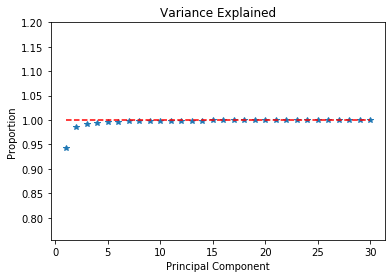

In [4]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

X_train_orig, X_test_orig = mypackage.Dataset.PCA(X_train_orig, X_test_orig, n_components=30, plot=True, whiten=True)

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# load the scaler from disk
scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [5]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=0.0)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=0.0)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 30), (57, 56, 56, 30))

# Test HybridSN

2020-05-15 00:29:56.274508
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (No

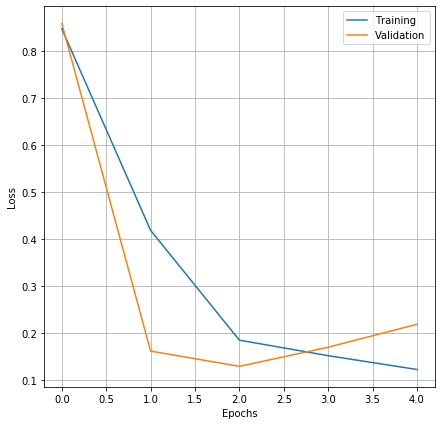

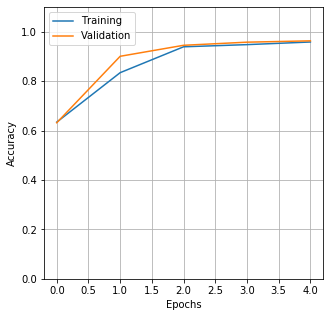

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     36845
         1.0       0.95      0.94      0.95     20071
         2.0       0.71      0.73      0.72      1452

    accuracy                           0.96     58368
   macro avg       0.88      0.89      0.88     58368
weighted avg       0.96      0.96      0.96     58368



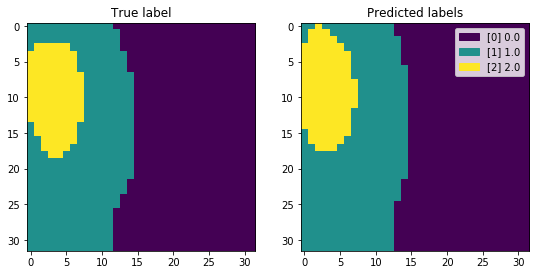

Elapsed time: 474.5073 seconds
Fasle positive blobs 38.
Fasle positive blobs per image 0.6667


In [6]:
print_current_time()

model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [7]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-18.315460205078125, 24.86631965637207) (570, 32, 32, 30) (1260, 32, 32, 30)
(array([0., 1., 2.]), array([875465, 377266,  37509]))
(array([0., 1., 2.]), array([363781, 203584,  16315]))


# Testing SVM

In [8]:
# Started the training at ~16:30
# Finished training at ~17:00

In [9]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 30))

2020-05-15 03:00:31.651152
[LibSVM]Elapsed time: 6309.9024 seconds
Elapsed time: 1388.9911 seconds
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    363781
         1.0       0.94      0.98      0.96    203584
         2.0       0.94      0.33      0.49     16315

    accuracy                           0.97    583680
   macro avg       0.95      0.77      0.81    583680
weighted avg       0.97      0.97      0.96    583680

Fasle positive blobs 77.
Fasle positive blobs per image 0.1351


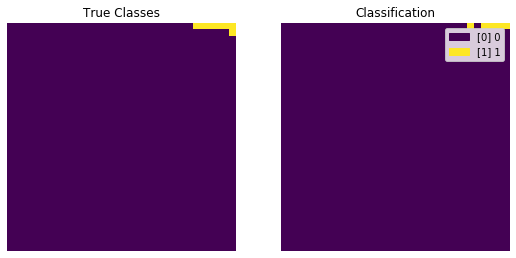

In [10]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=10, kernel='rbf', gamma=0.1)
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

### Linear - SVM

2020-05-15 05:08:51.423108
[LibSVM]Elapsed time: 310.9428 seconds
Elapsed time: 158.3181 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    363781
         1.0       0.97      0.97      0.97    203584
         2.0       0.89      0.69      0.78     16315

    accuracy                           0.98    583680
   macro avg       0.95      0.89      0.91    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 229.
Fasle positive blobs per image 0.4018


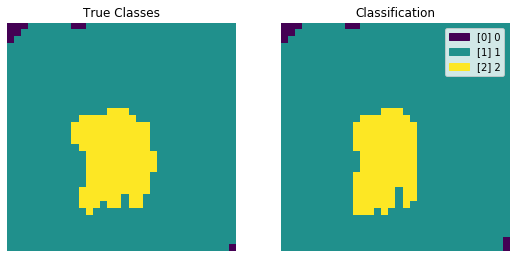

In [11]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=0.1, kernel='linear')
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [12]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

2020-05-15 05:16:41.581013
Elapsed time: 4.8415 seconds
Elapsed time: 0.1552 seconds
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    875465
         1.0       0.95      0.97      0.96    377266
         2.0       0.91      0.61      0.73     37509

    accuracy                           0.98   1290240
   macro avg       0.95      0.86      0.89   1290240
weighted avg       0.98      0.98      0.97   1290240

Elapsed time: 0.0656 seconds
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    363781
         1.0       0.97      0.96      0.96    203584
         2.0       0.88      0.68      0.77     16315

    accuracy                           0.98    583680
   macro avg       0.94      0.88      0.91    583680
weighted avg       0.97      0.98      0.97    583680

Fasle positive blobs 258.
Fasle positive blobs per image 0.4526


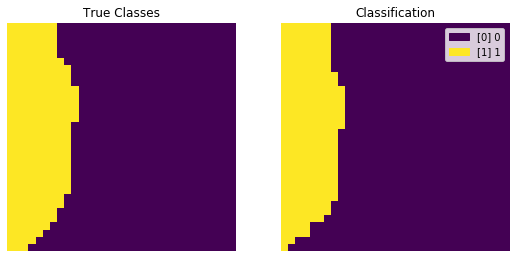

In [13]:
print_current_time()

logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l2', saved_mode_name="latest_LogisticReg_l2_model.sav")# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

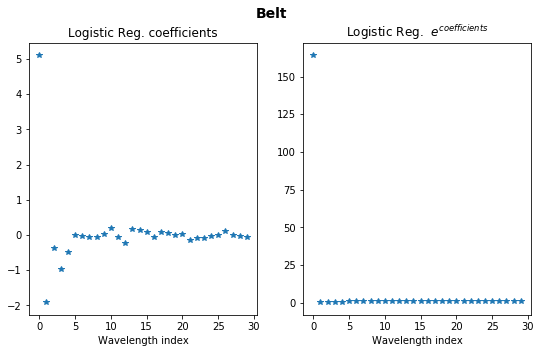

Ordered four most useful wavelengths are: [928, 964, 975, 978]nm
There corresponding indexes are: [ 0 10 13 14]


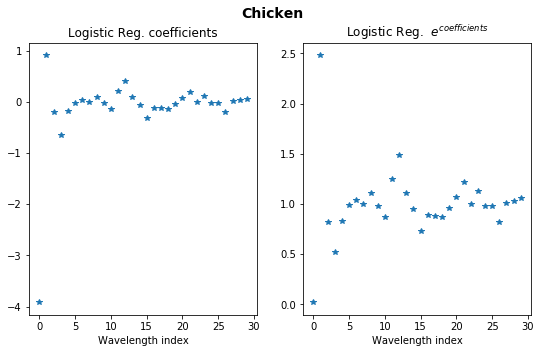

Ordered four most useful wavelengths are: [932, 971, 968, 1004]nm
There corresponding indexes are: [ 1 12 11 21]


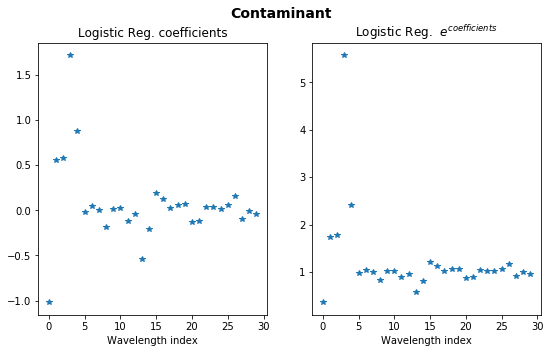

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [14]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [15]:
np.unique(Y_train_orig, return_counts=True)

(array([0, 1, 2], dtype=int32), array([361057,  54747,   4196]))

2020-05-15 05:16:50.081189


/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Elapsed time: 6.4402 seconds
2020-05-15 05:16:56.522834
Elapsed time: 0.0658 seconds
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    363781
         1.0       0.97      0.96      0.96    203584
         2.0       0.89      0.68      0.77     16315

    accuracy                           0.98    583680
   macro avg       0.95      0.88      0.91    583680
weighted avg       0.97      0.98      0.97    583680

2020-05-15 05:16:57.253589
Fasle positive blobs 255.
Fasle positive blobs per image 0.4474


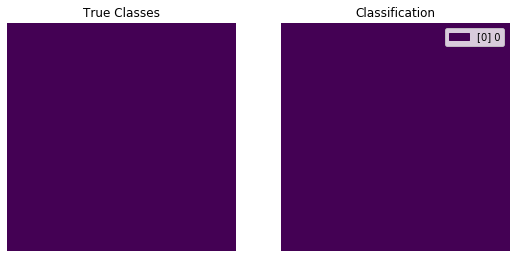

In [16]:
print_current_time()

logreg_l1 = mypackage.LogReg(X_train_orig, Y_train_orig, C=1, penalty='l1', max_iter=10, saved_mode_name="latest_LogisticReg_l1_model.sav")# , max_iter=1000)
logreg_l1.train()
# logreg_l1.predict(X_train, Y_train, plot=False)
print_current_time()
Y_hat = logreg_l1.predict(X_test, Y_test)
print_current_time()

mypackage.report_count_false_positive(Y_hat, Y_test)

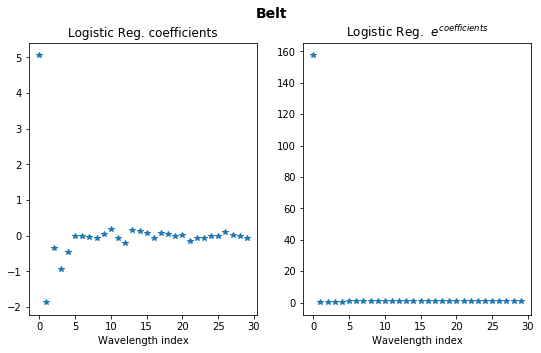

Ordered four most useful wavelengths are: [928, 964, 975, 978]nm
There corresponding indexes are: [ 0 10 13 14]


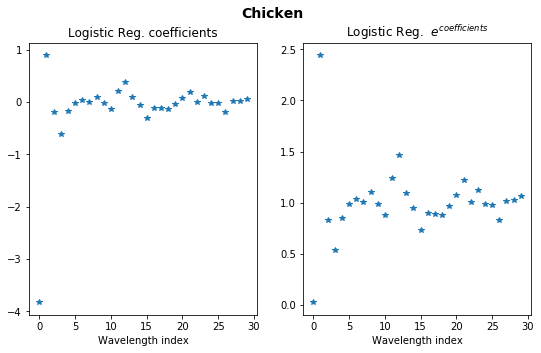

Ordered four most useful wavelengths are: [932, 971, 968, 1004]nm
There corresponding indexes are: [ 1 12 11 21]


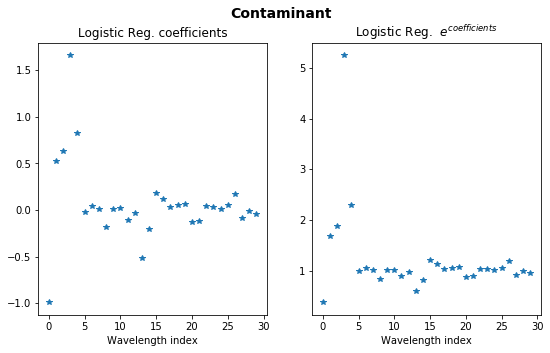

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [17]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg_l1.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg_l1.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [18]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [19]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

2020-05-15 05:16:58.609431
Start training
Elapsed time: 288.6727 seconds


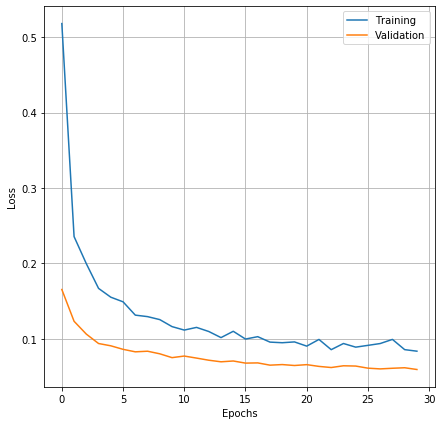

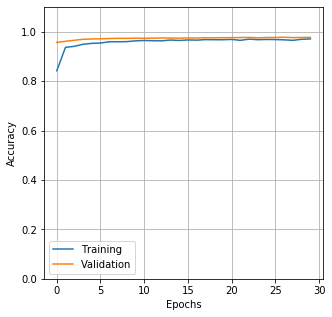

Predicting for train data
Elapsed time: 2.8944 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    875465
           1       0.96      0.97      0.96    377266
           2       0.86      0.75      0.80     37509

    accuracy                           0.98   1290240
   macro avg       0.94      0.90      0.92   1290240
weighted avg       0.98      0.98      0.98   1290240



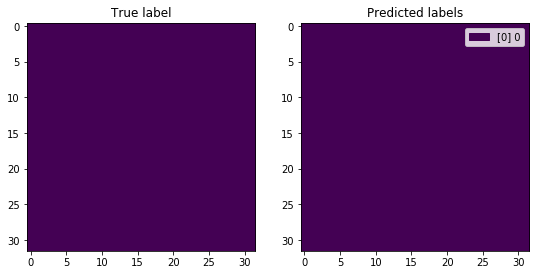

Predicting for test data
Elapsed time: 1.1774 seconds
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    363781
           1       0.97      0.95      0.96    203584
           2       0.76      0.77      0.76     16315

    accuracy                           0.97    583680
   macro avg       0.90      0.91      0.90    583680
weighted avg       0.97      0.97      0.97    583680



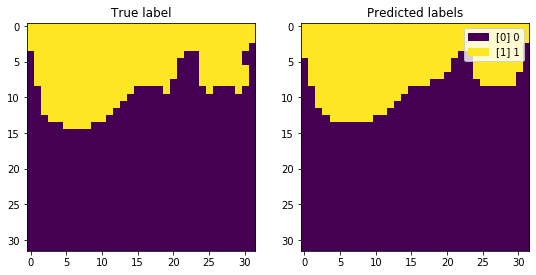

Elapsed time: 2.0243 seconds
Fasle positive blobs 6.
Fasle positive blobs per image 0.0105


In [20]:
print_current_time()

spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [21]:
# spectral_unet.summary()

### Test 2D UNet on the same data

2020-05-15 05:21:54.753620
(1260, 32, 32, 30)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.5224 - accuracy: 0.8346
Epoch 00001: val_loss improved from inf to 0.13027, saving model to latest_unet.hdf5
1134/1134 [==============================] - 5s 4ms/sample - loss: 0.5198 - accuracy: 0.8355 - val_loss: 0.1303 - val_accuracy: 0.9707
Epoch 2/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9588
Epoch 00002: val_loss improved from 0.13027 to 0.08308, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.1668 - accuracy: 0.9589 - val_loss: 0.0831 - val_accuracy: 0.9753
Epoch 3/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9638
Epoch 00003: val_loss improved from 0.08308 to 0.07272, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss

1125/1134 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9758
Epoch 00027: val_loss did not improve from 0.05408
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0692 - accuracy: 0.9759 - val_loss: 0.0566 - val_accuracy: 0.9799
Epoch 28/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9782
Epoch 00028: val_loss improved from 0.05408 to 0.05325, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0669 - accuracy: 0.9773 - val_loss: 0.0533 - val_accuracy: 0.9799
Epoch 29/30
1120/1134 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9777
Epoch 00029: val_loss improved from 0.05325 to 0.05254, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.0641 - accuracy: 0.9777 - val_loss: 0.0525 - val_accuracy: 0.9810
Epoch 30/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0638 -

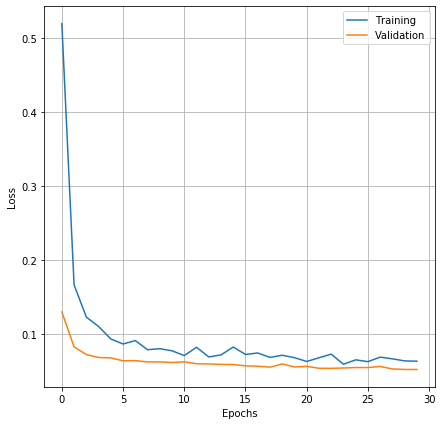

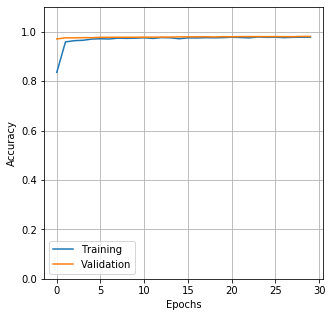

Predicting for train data
Elapsed time: 0.8404 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    875465
           1       0.97      0.97      0.97    377266
           2       0.84      0.85      0.84     37509

    accuracy                           0.98   1290240
   macro avg       0.93      0.94      0.94   1290240
weighted avg       0.98      0.98      0.98   1290240



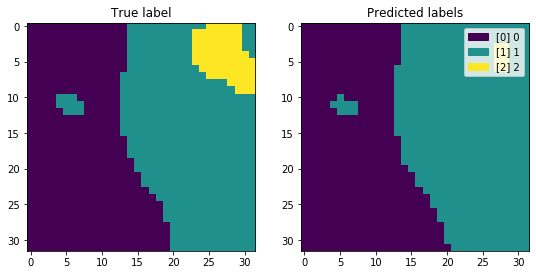

Predicting for test data
Elapsed time: 0.4362 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    363781
           1       0.98      0.96      0.97    203584
           2       0.78      0.85      0.81     16315

    accuracy                           0.98    583680
   macro avg       0.92      0.93      0.92    583680
weighted avg       0.98      0.98      0.98    583680



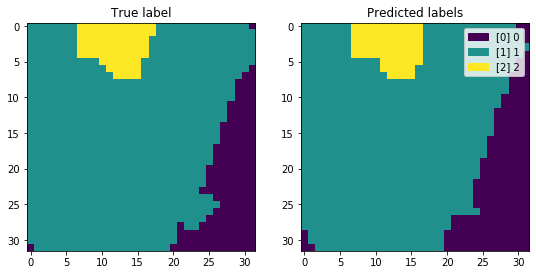

Elapsed time: 1.2861 seconds
Fasle positive blobs 92.
Fasle positive blobs per image 0.1614
Number of layers in the base model:  49


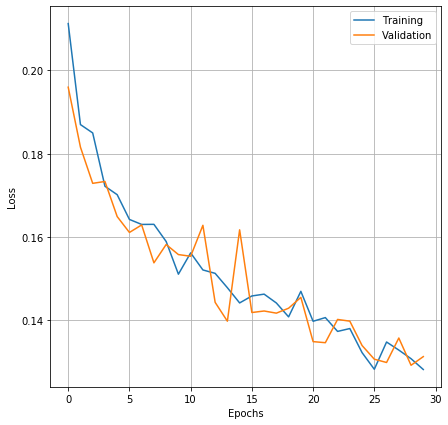

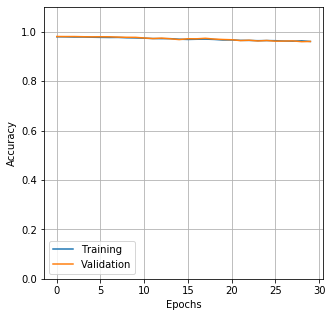

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.5027 seconds
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    363781
           1       0.95      0.92      0.93    203584
           2       0.77      0.87      0.82     16315

    accuracy                           0.95    583680
   macro avg       0.90      0.92      0.91    583680
weighted avg       0.95      0.95      0.95    583680



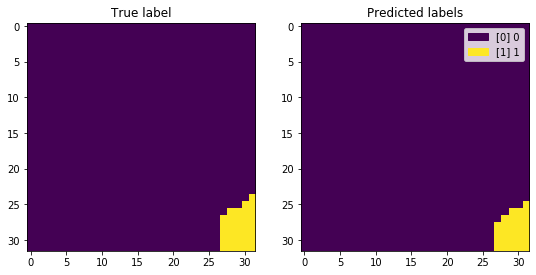

Fasle positive blobs 90.
Fasle positive blobs per image 0.1579


In [22]:
print_current_time()

# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


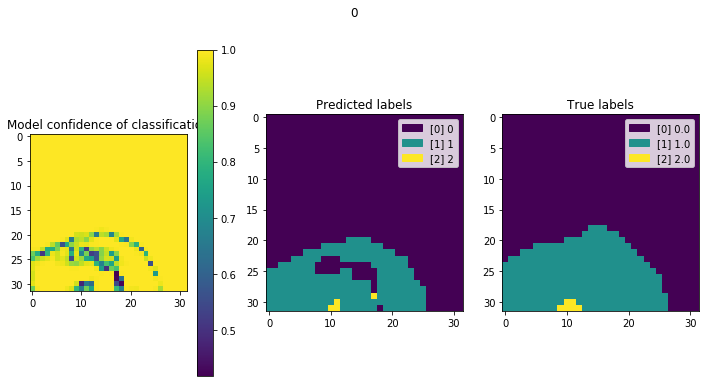

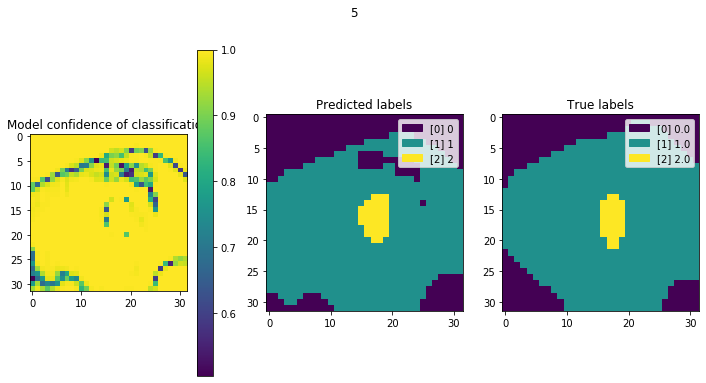

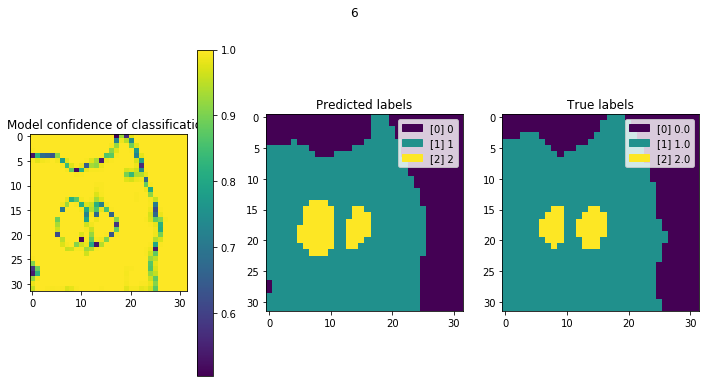

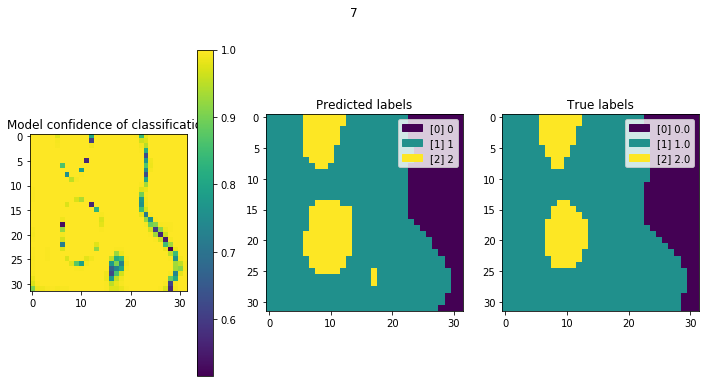

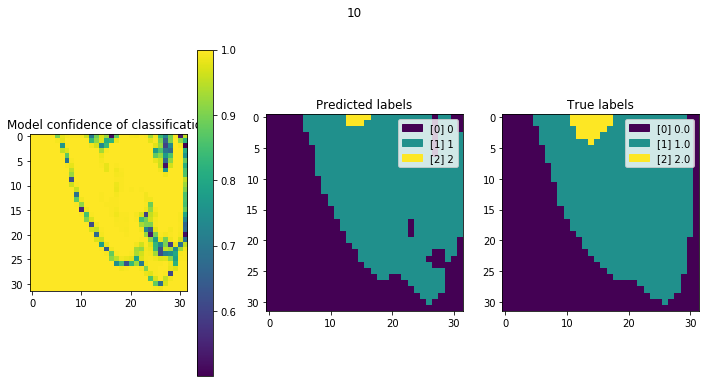

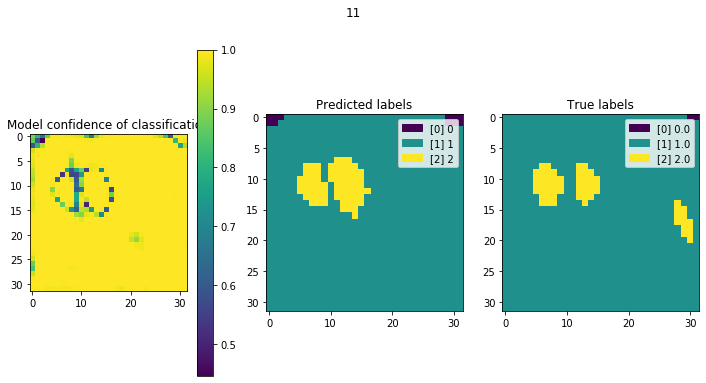

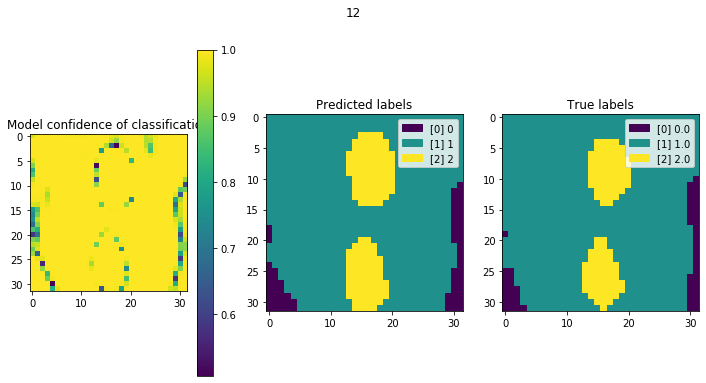

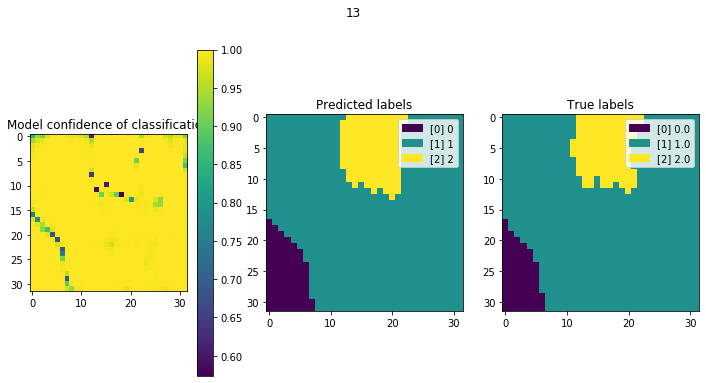

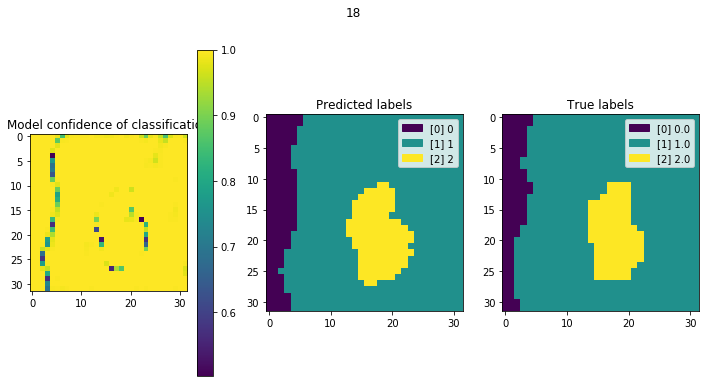

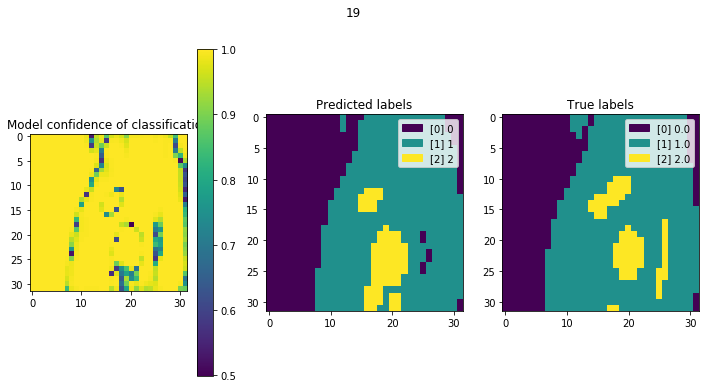

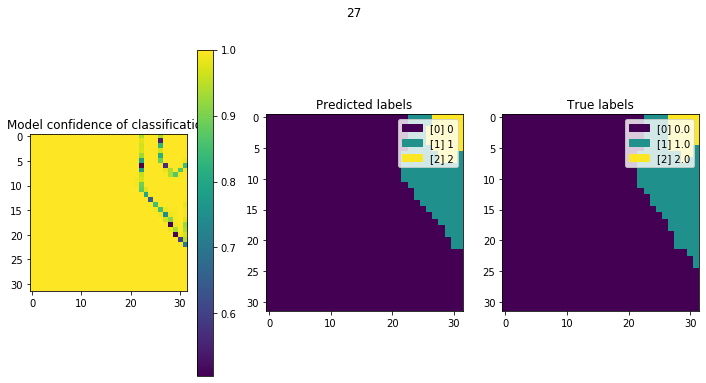

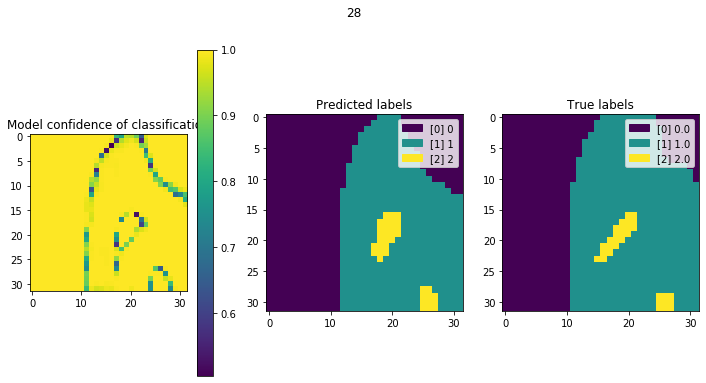

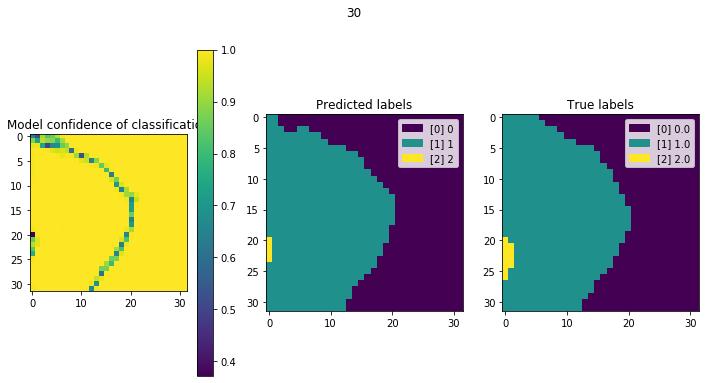

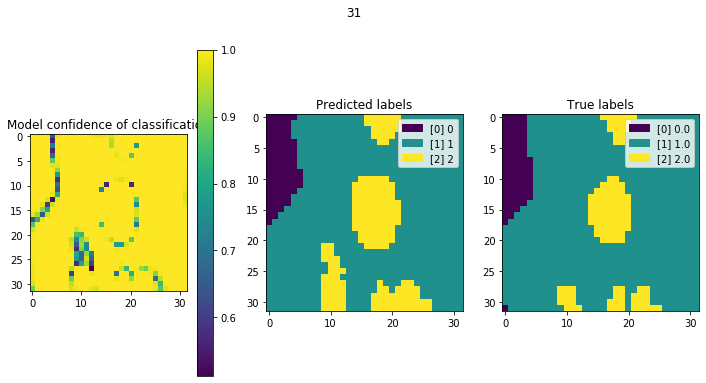

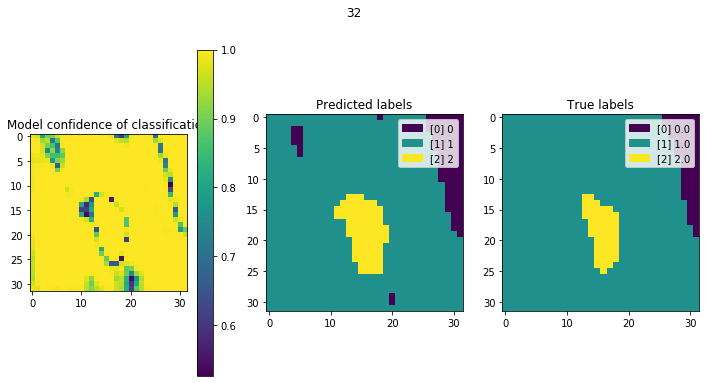

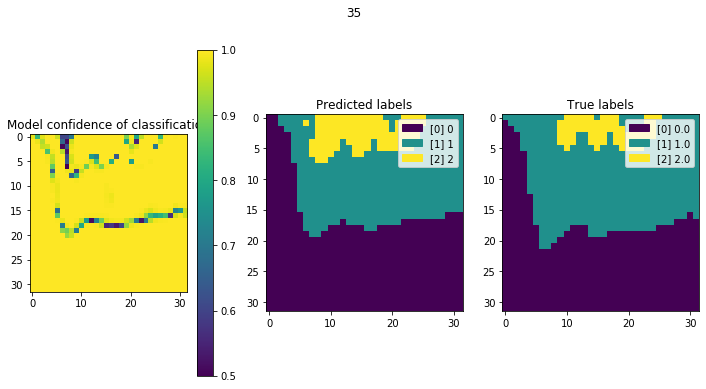

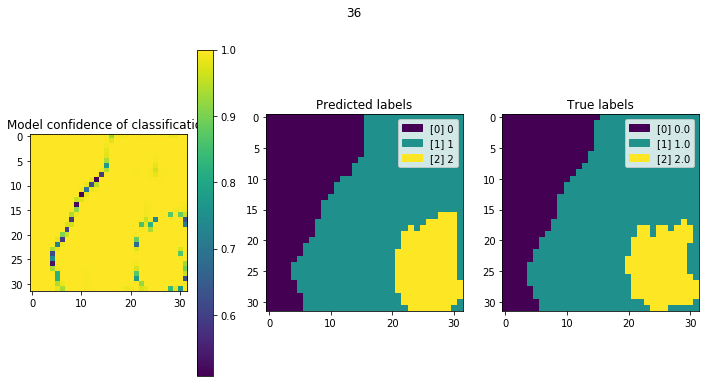

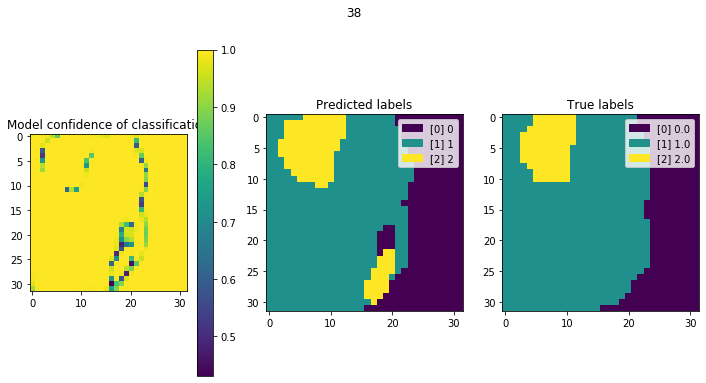

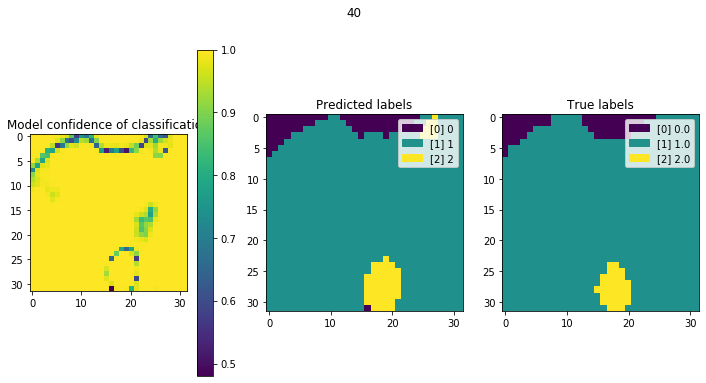

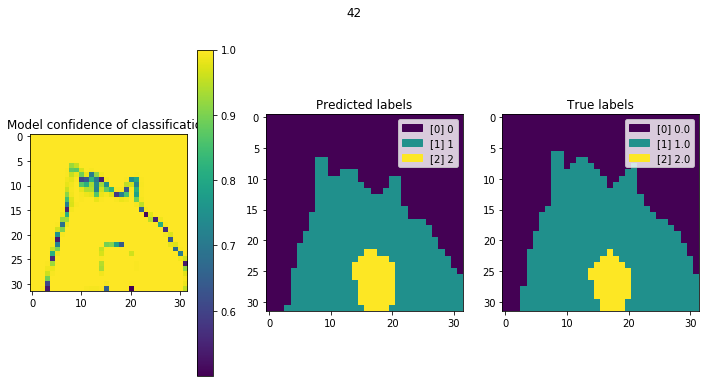

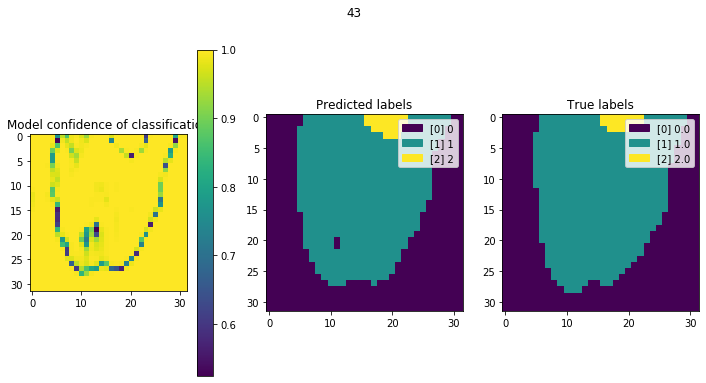

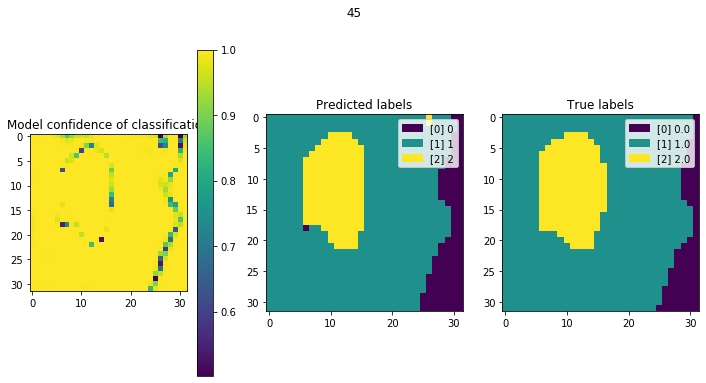

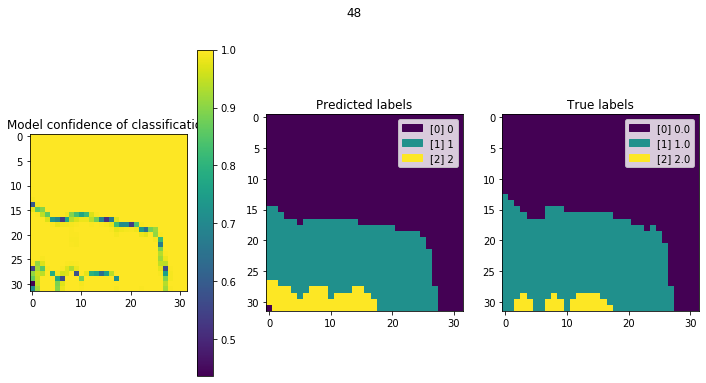

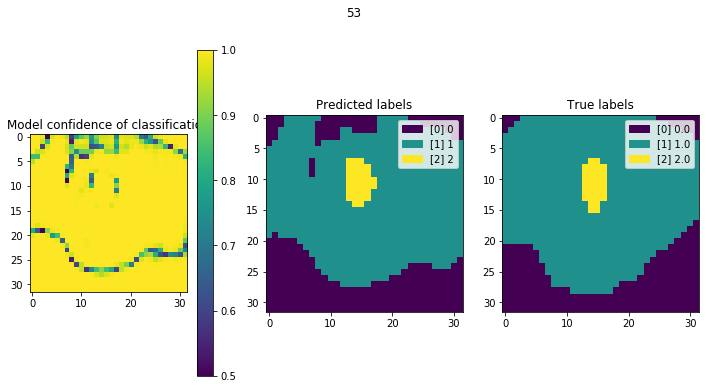

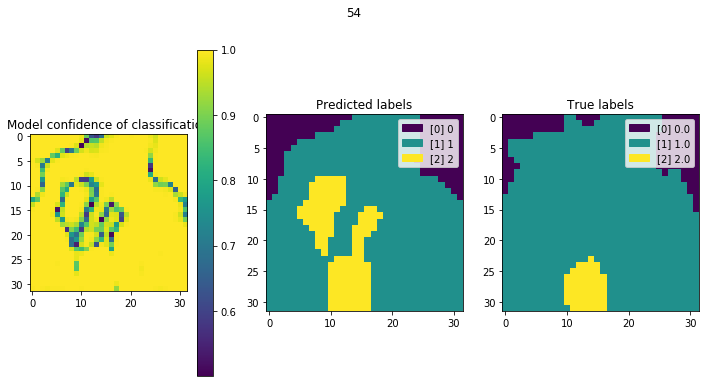

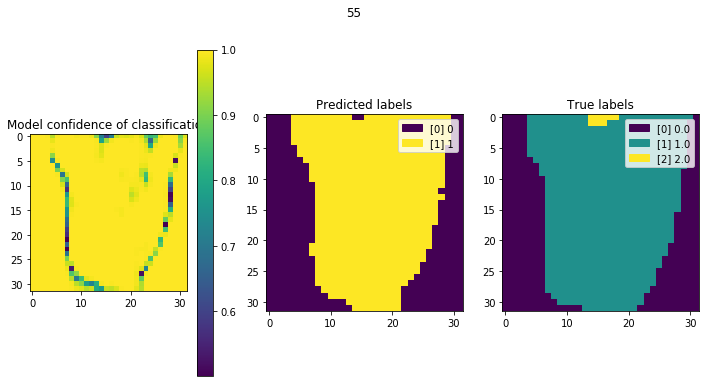

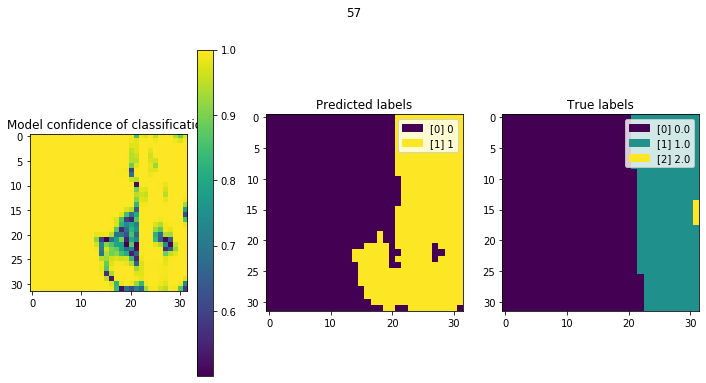

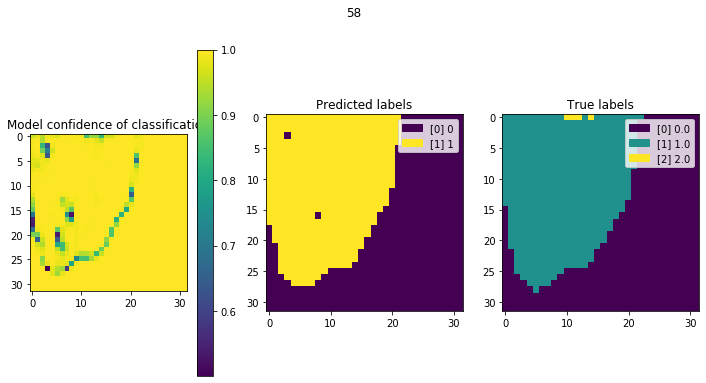

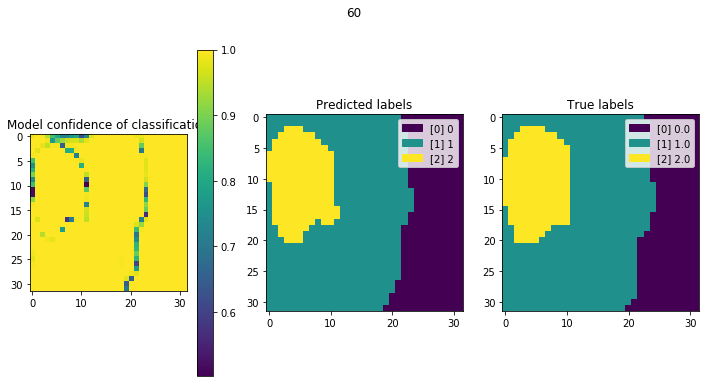

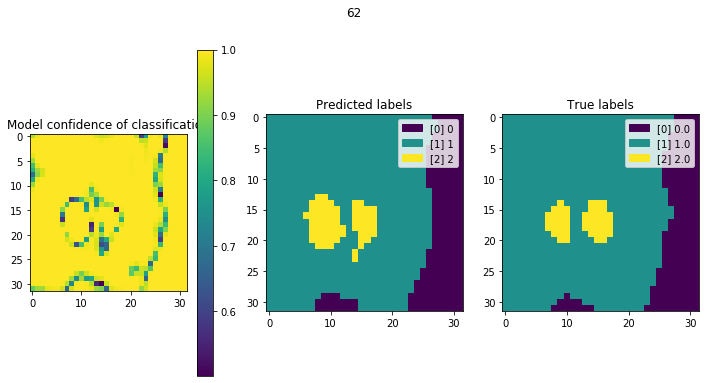

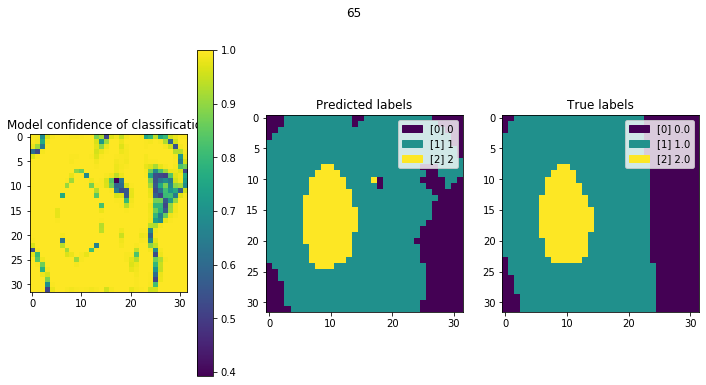

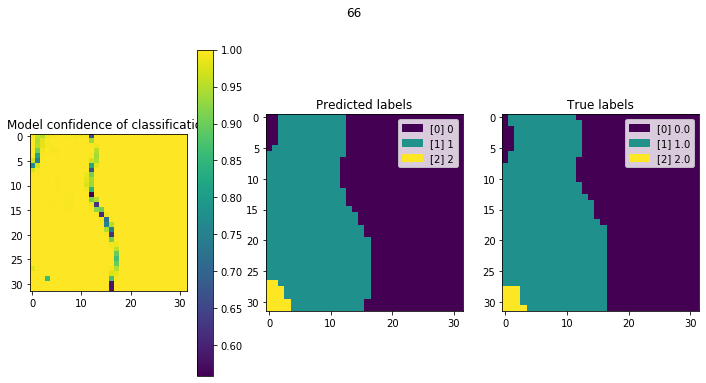

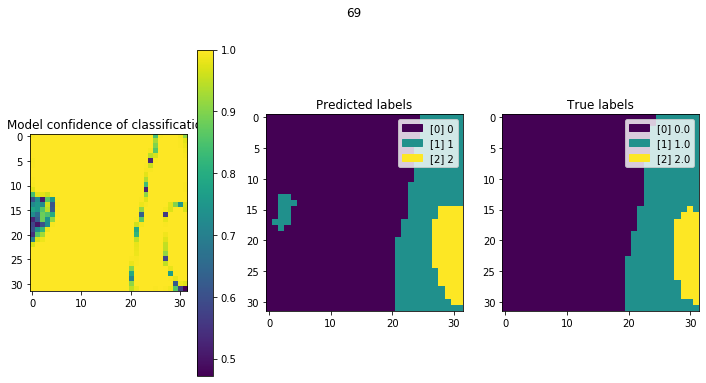

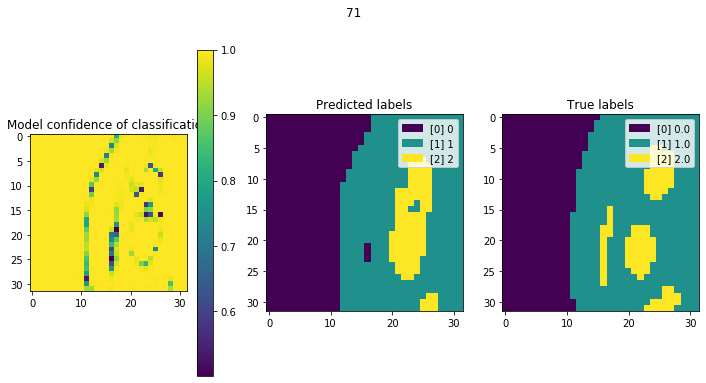

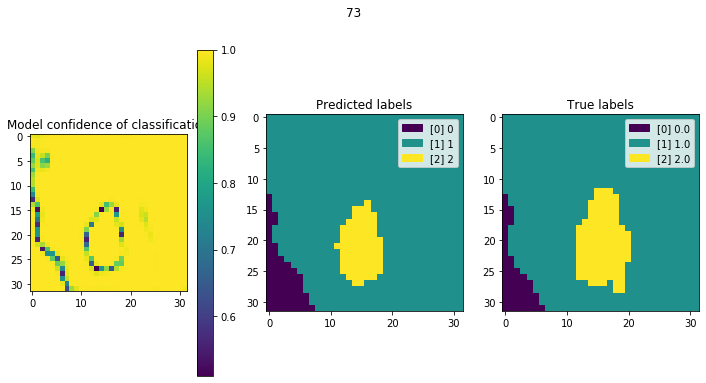

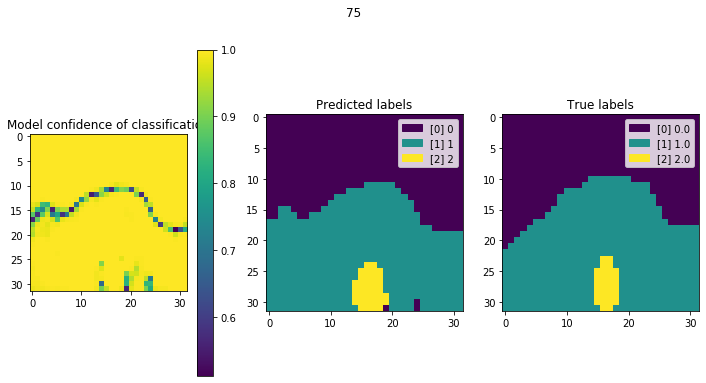

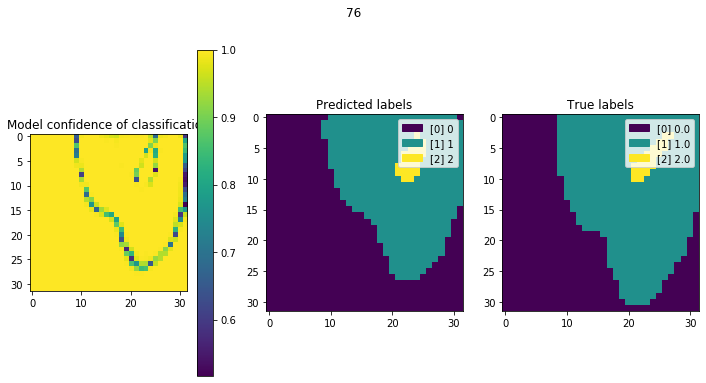

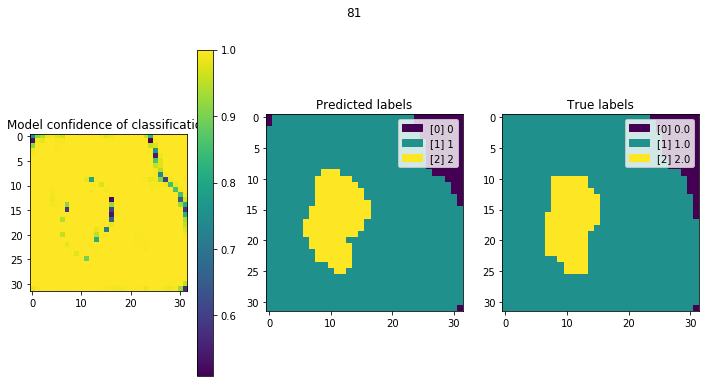

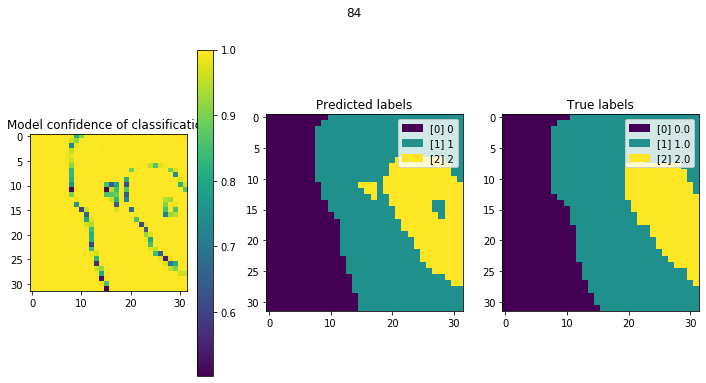

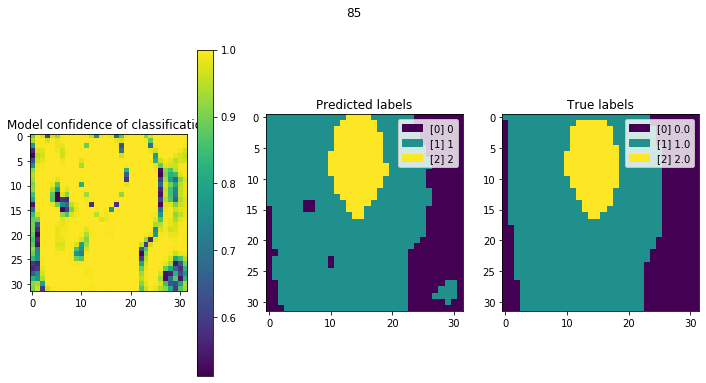

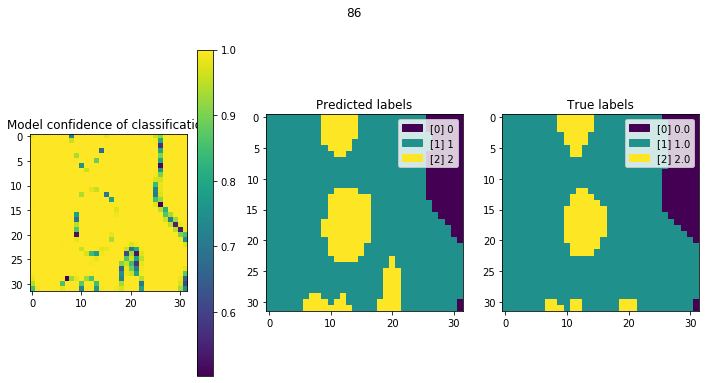

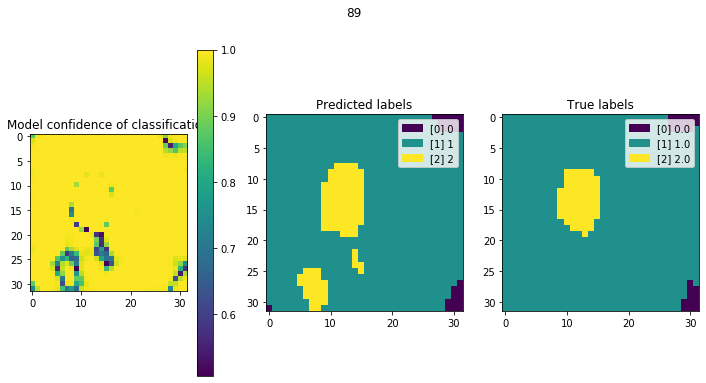

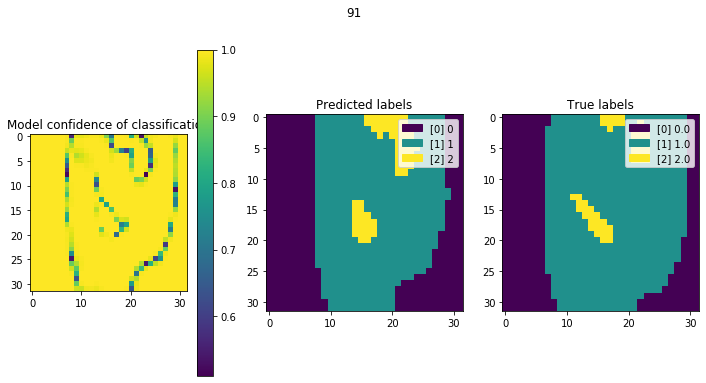

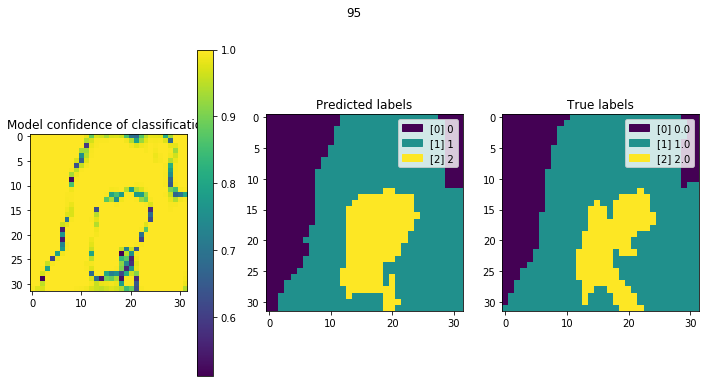

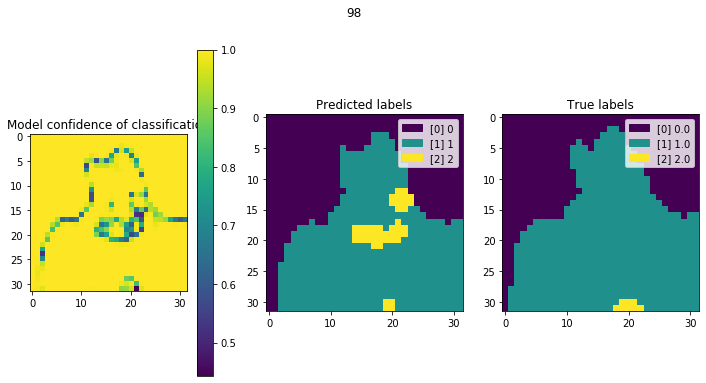

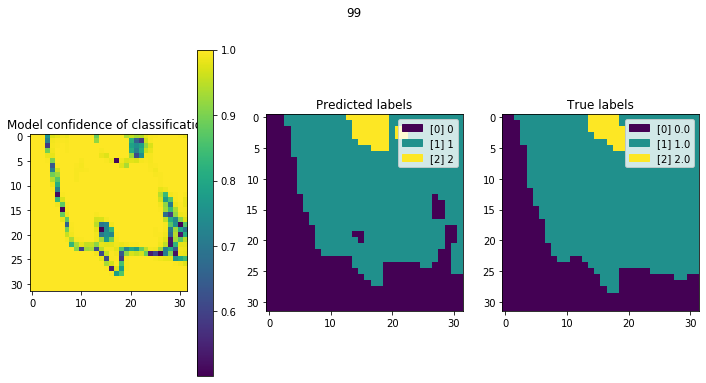

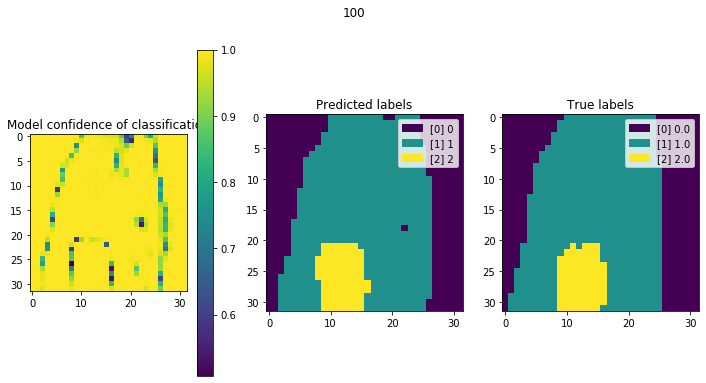

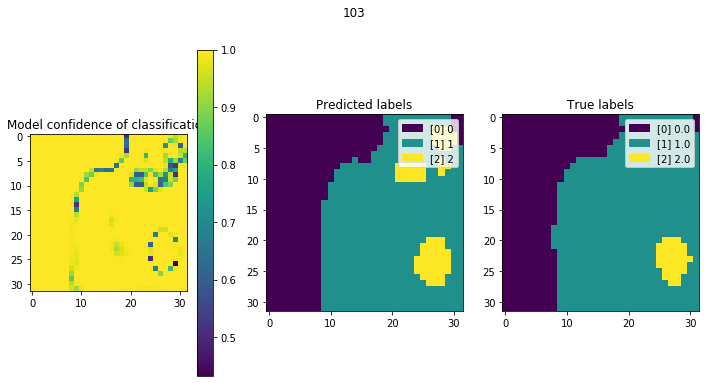

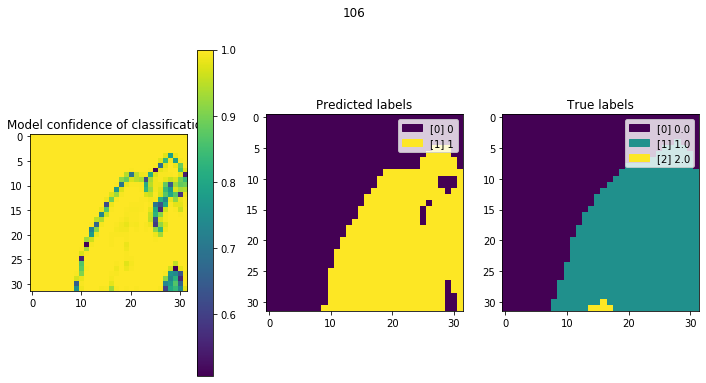

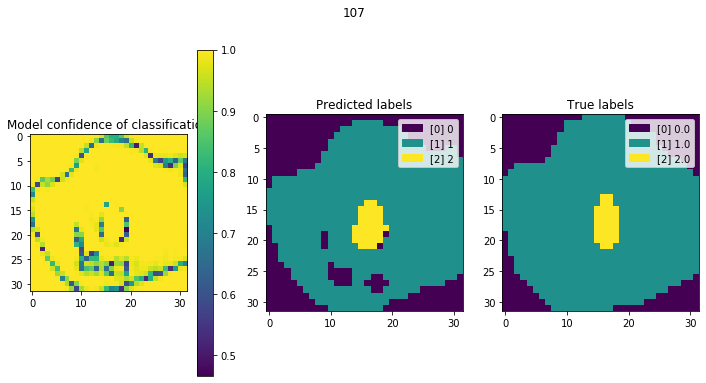

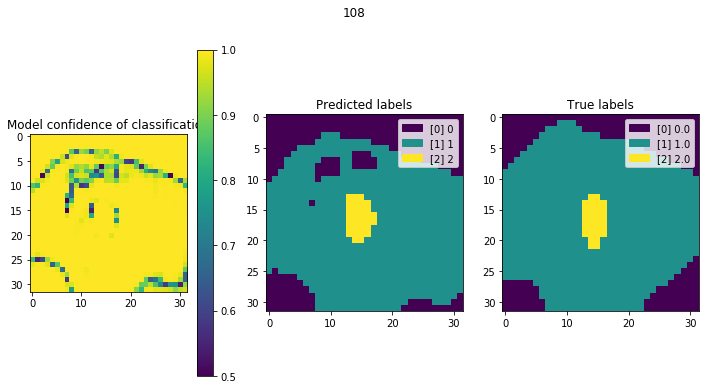

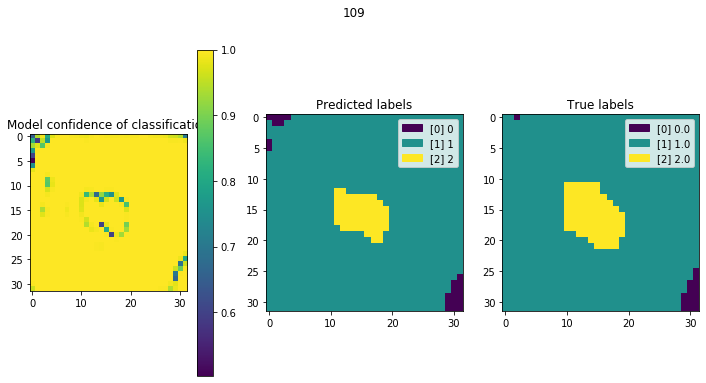

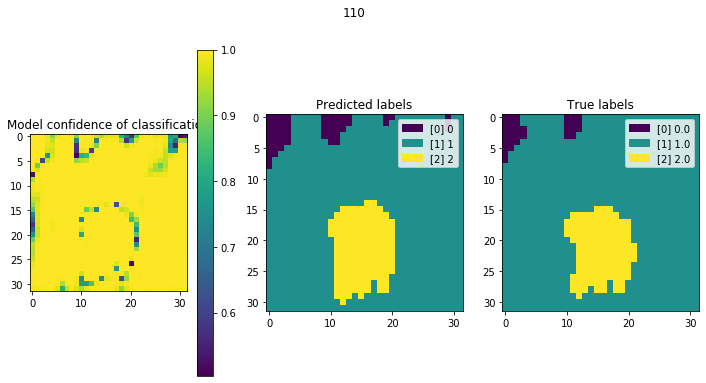

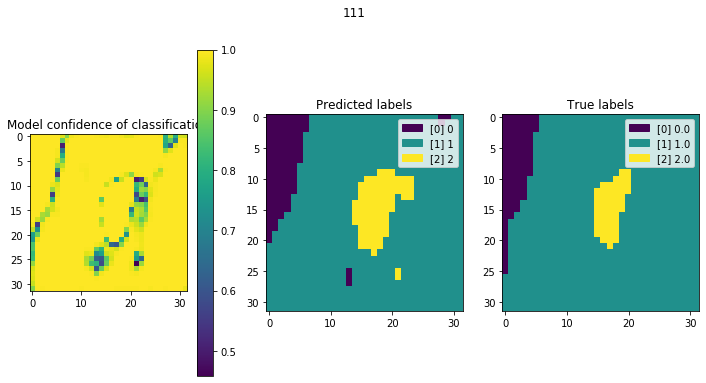

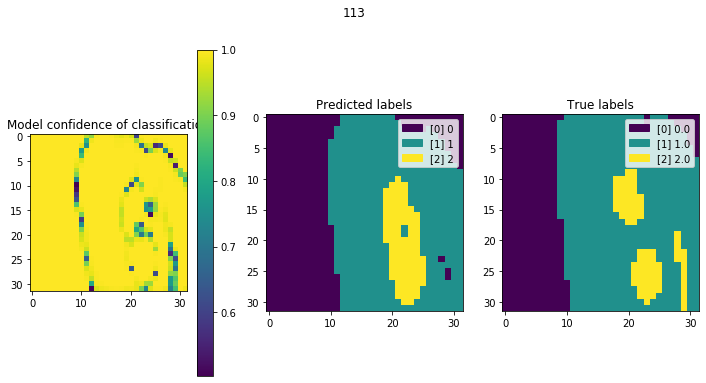

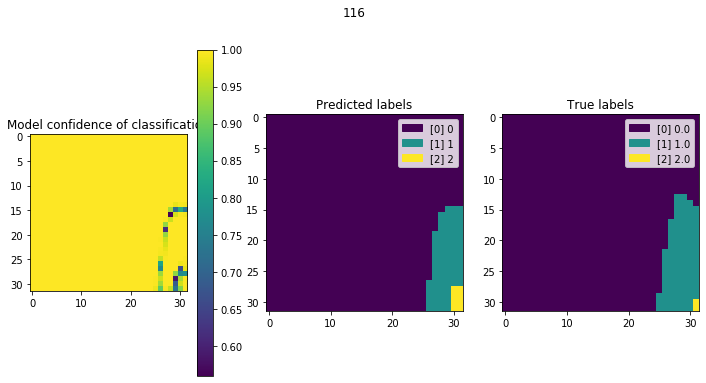

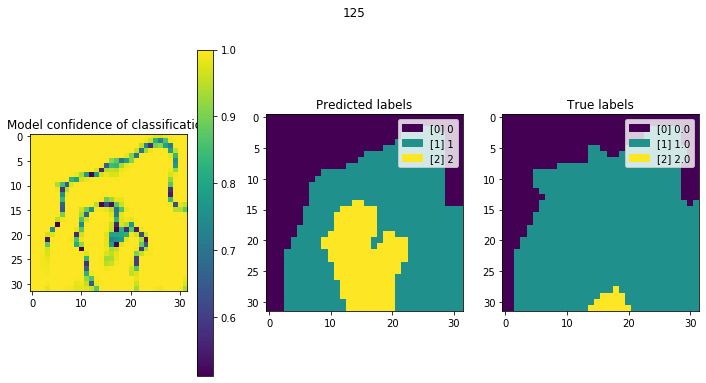

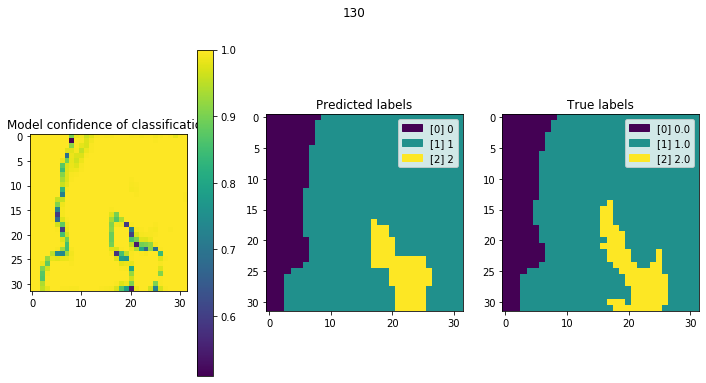

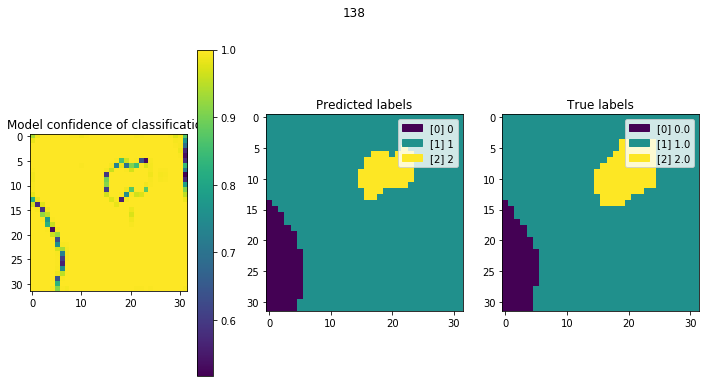

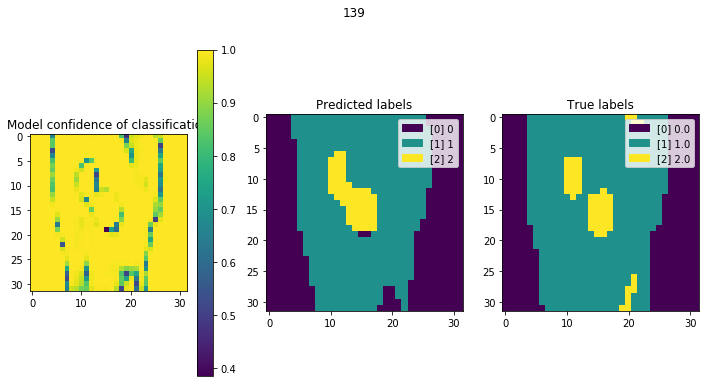

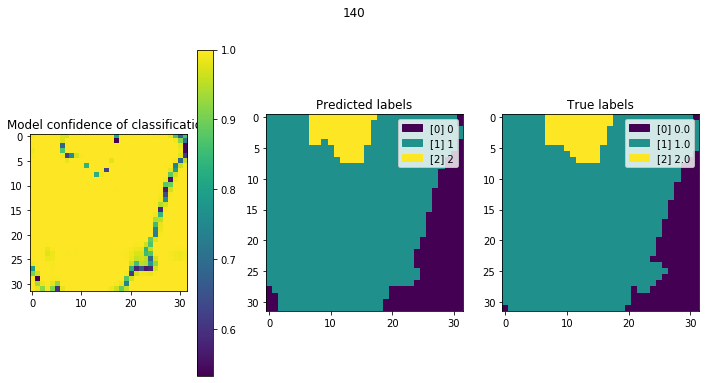

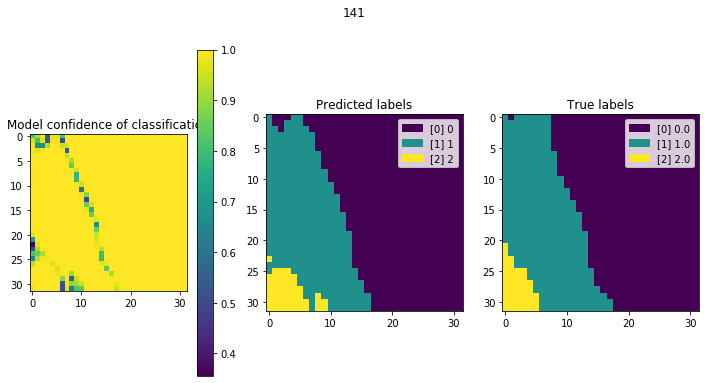

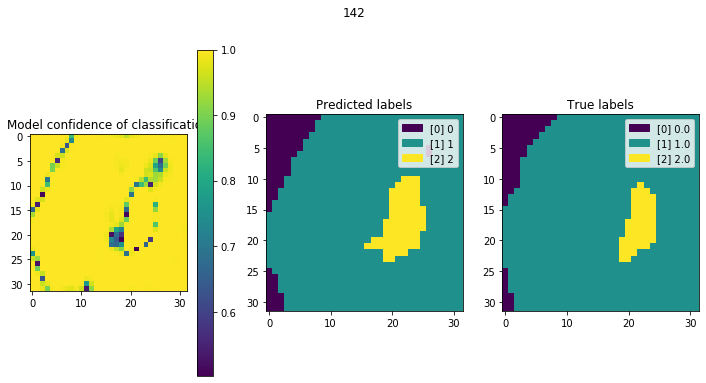

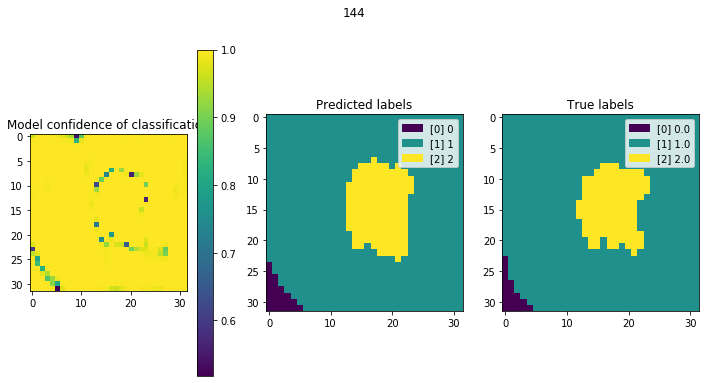

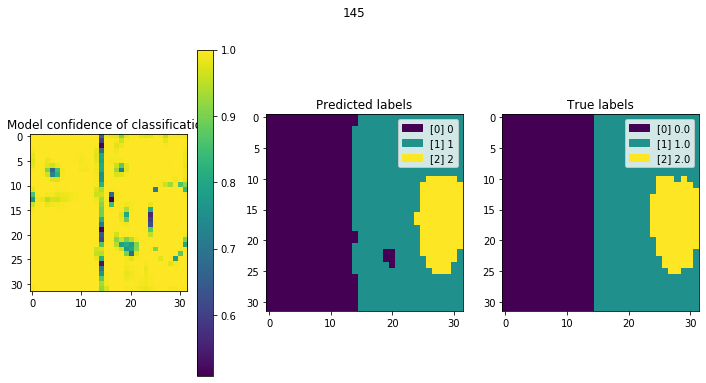

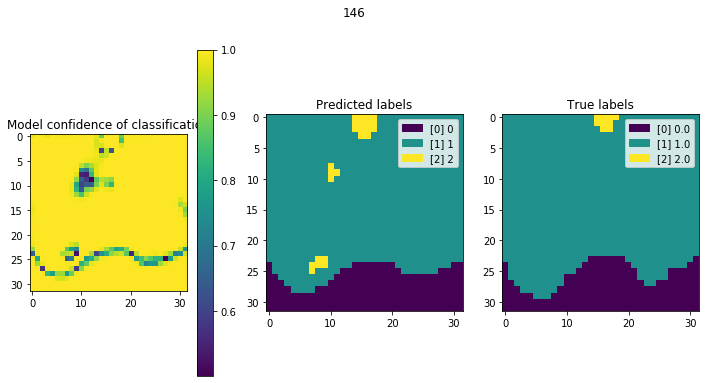

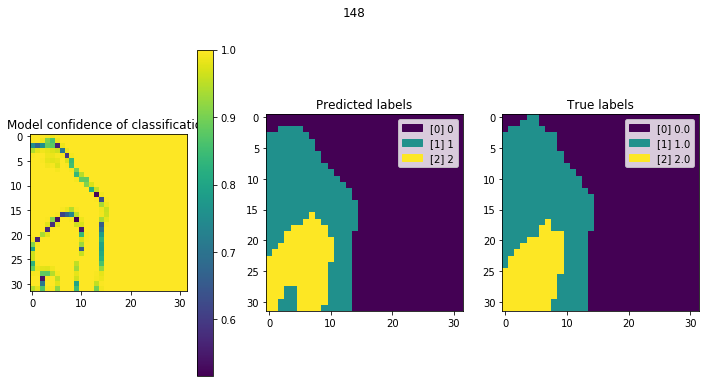

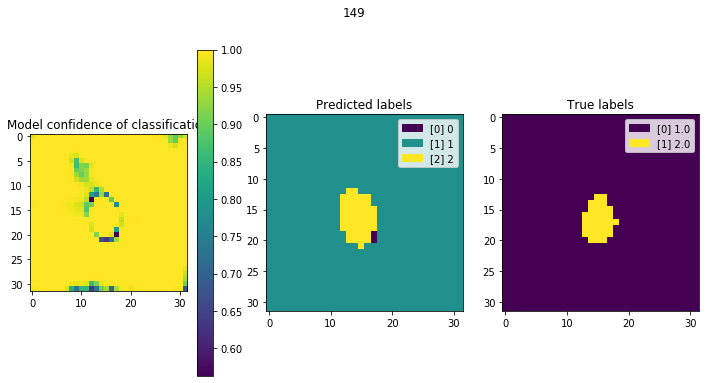

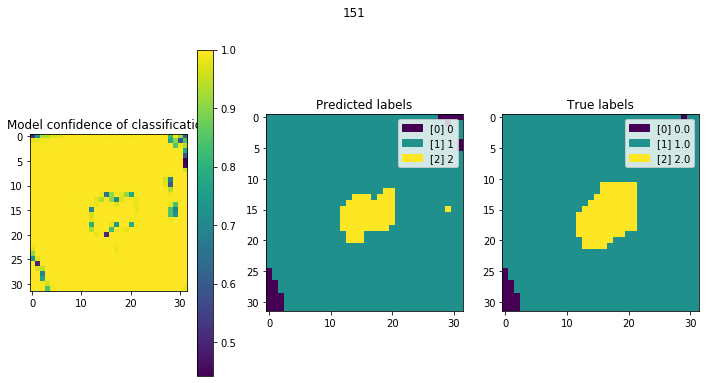

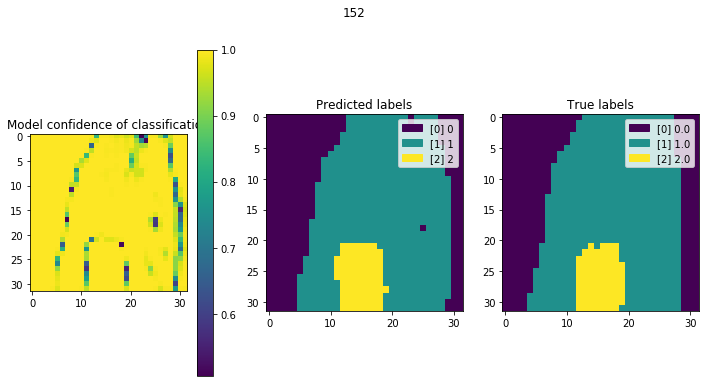

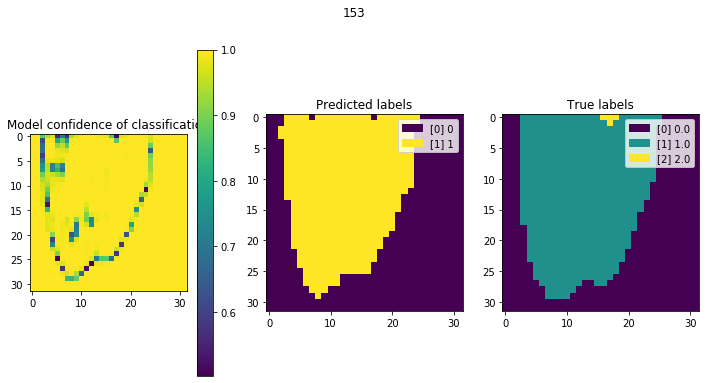

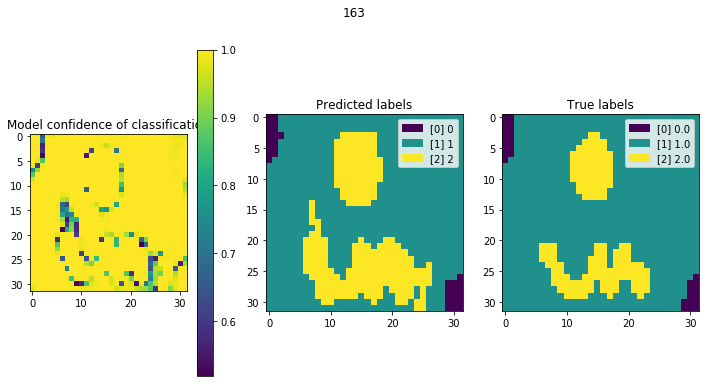

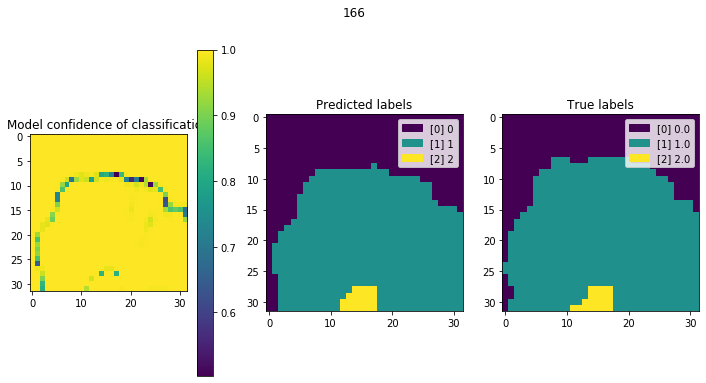

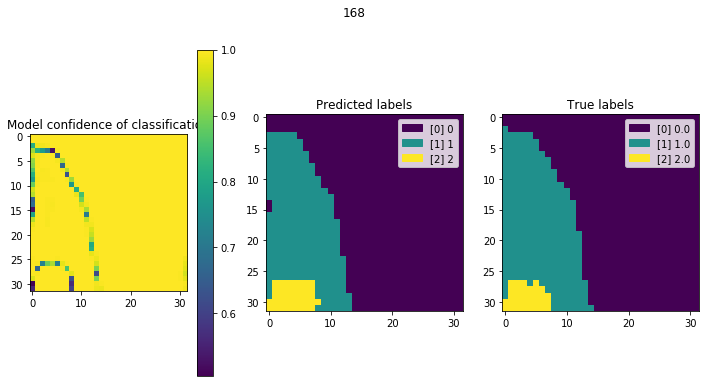

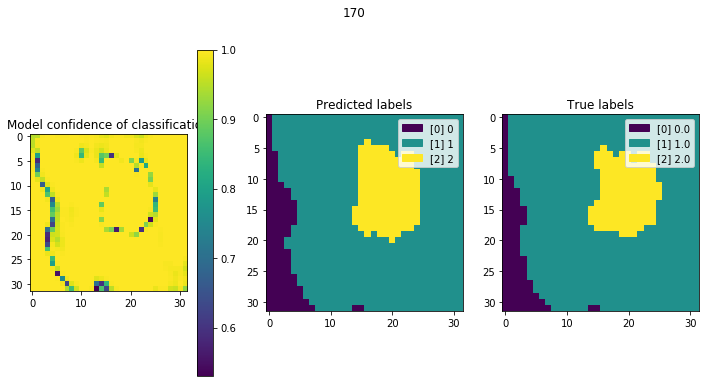

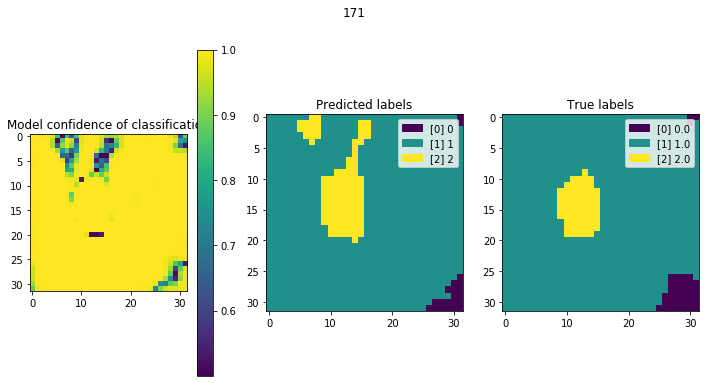

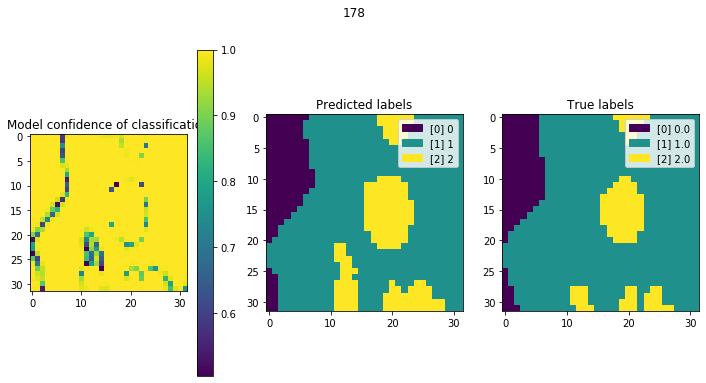

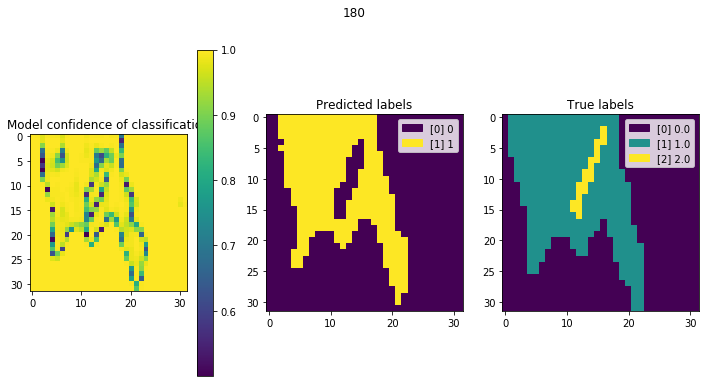

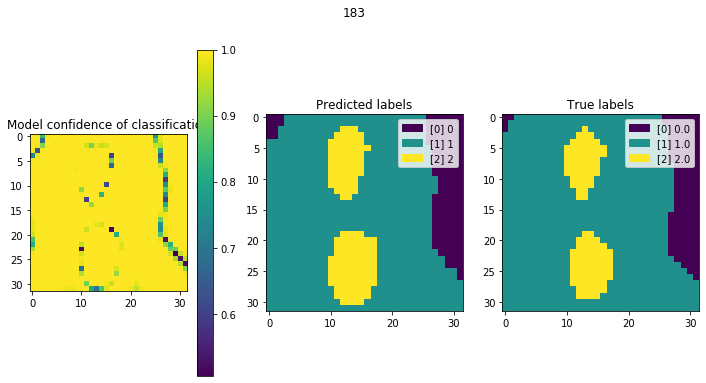

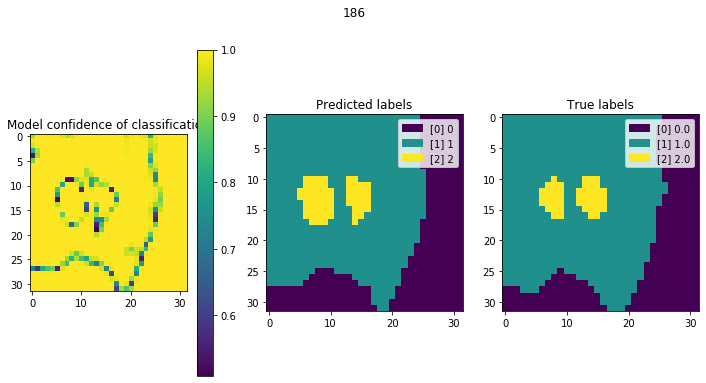

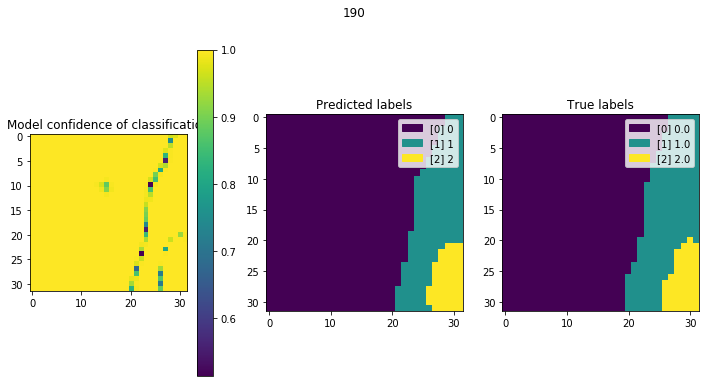

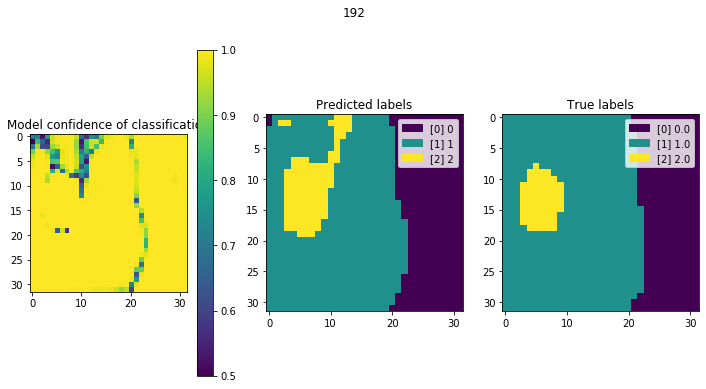

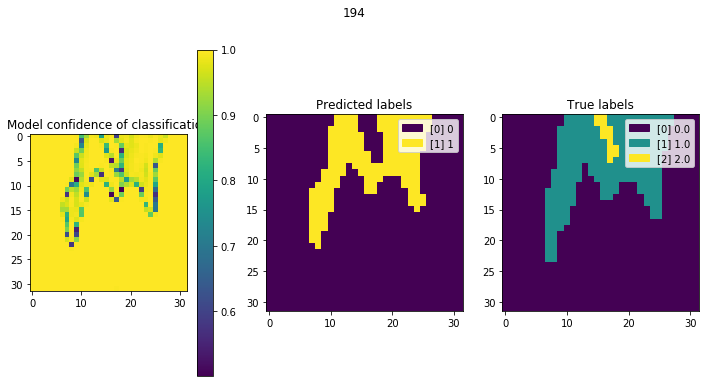

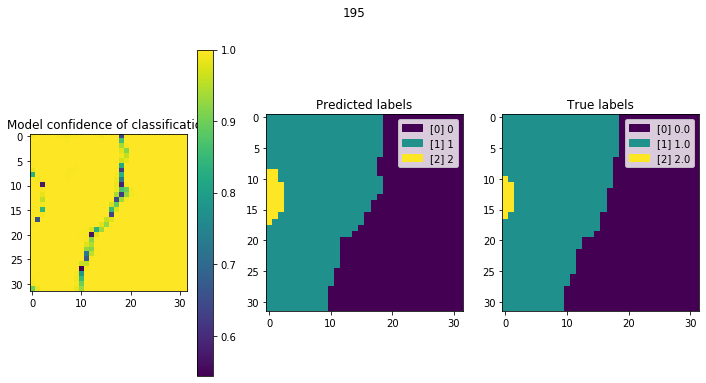

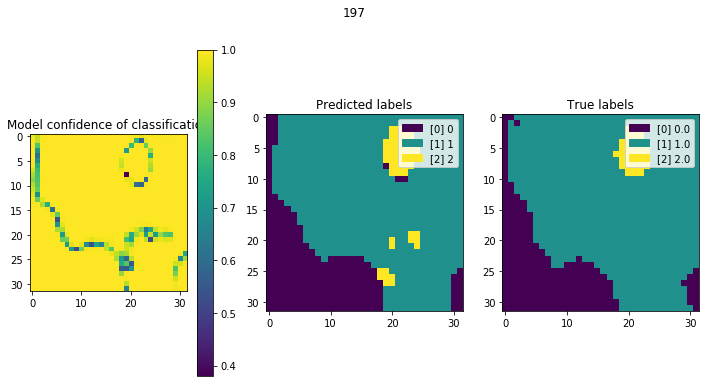

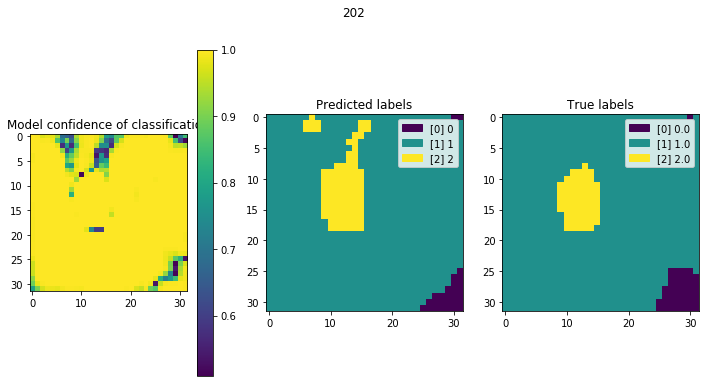

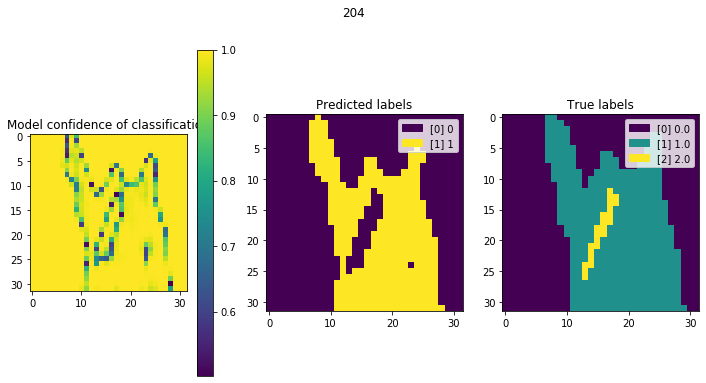

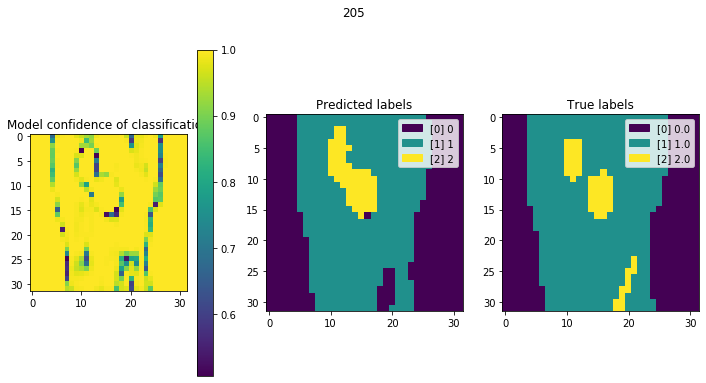

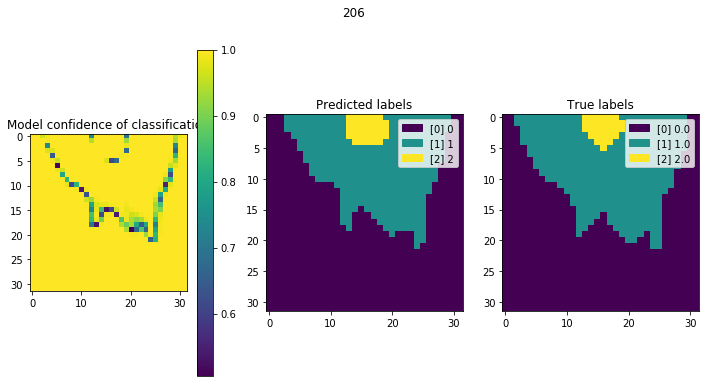

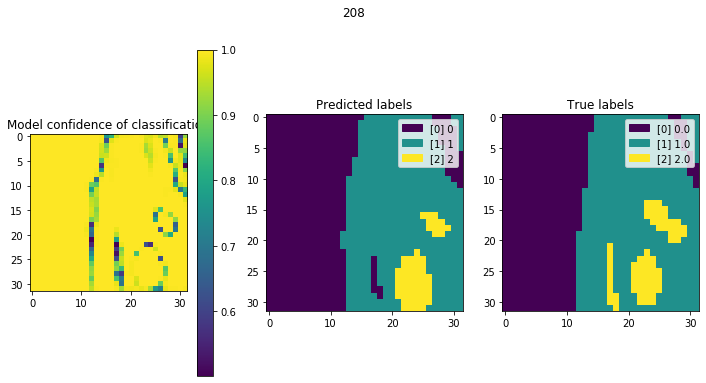

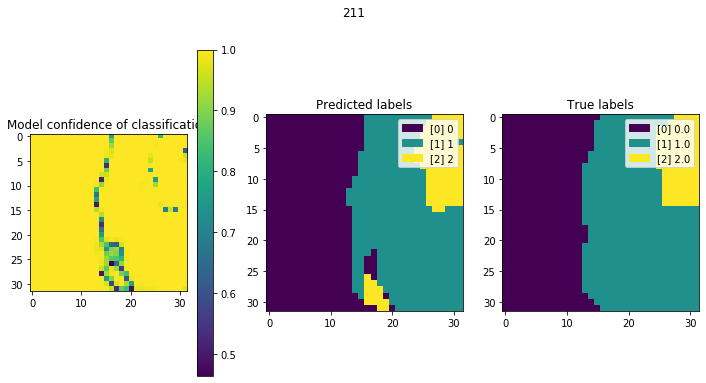

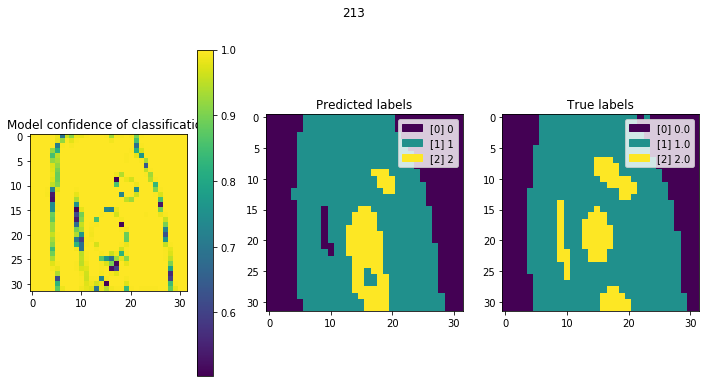

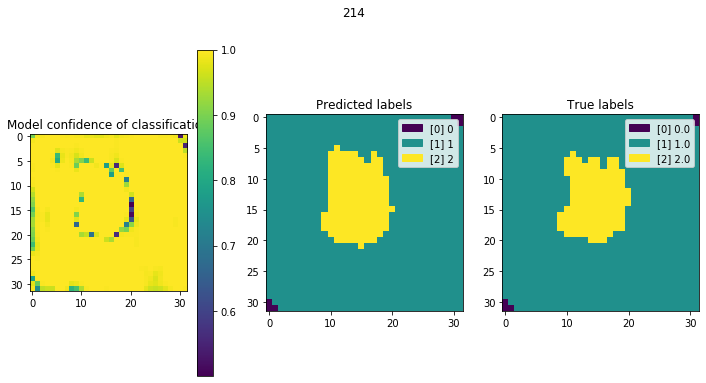

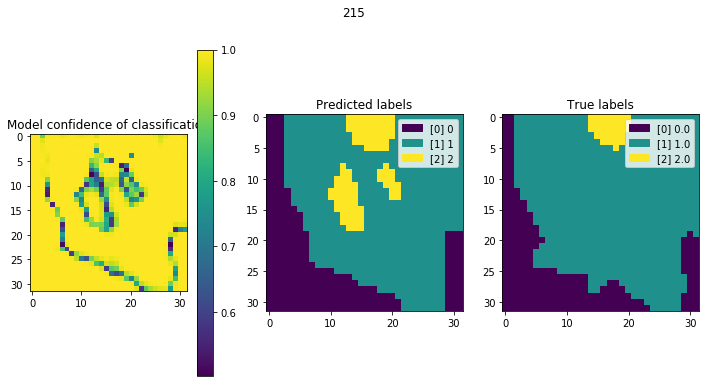

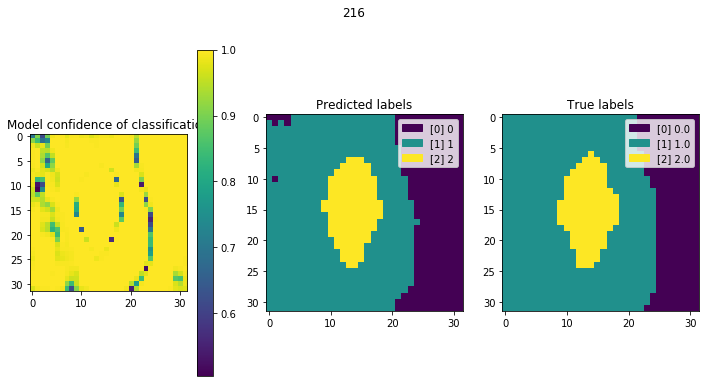

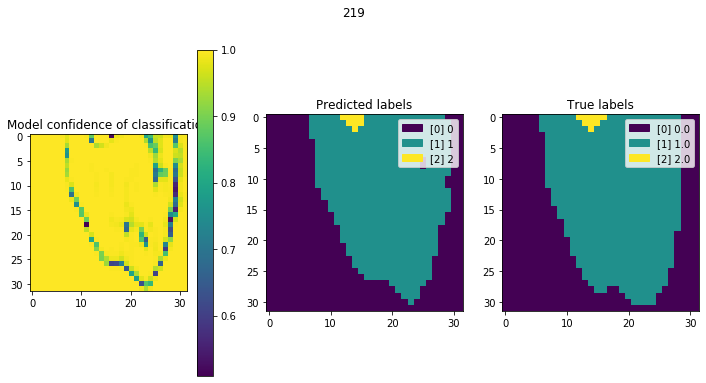

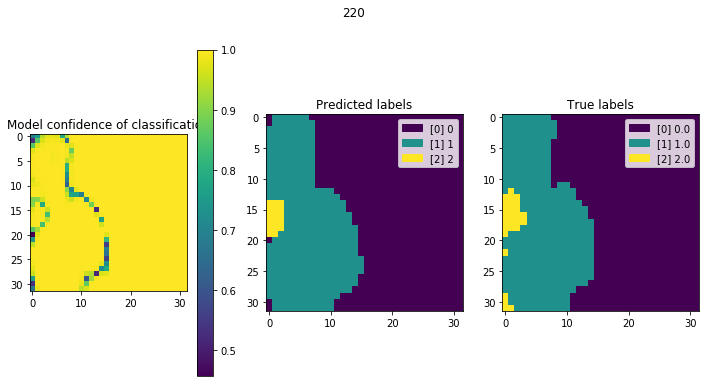

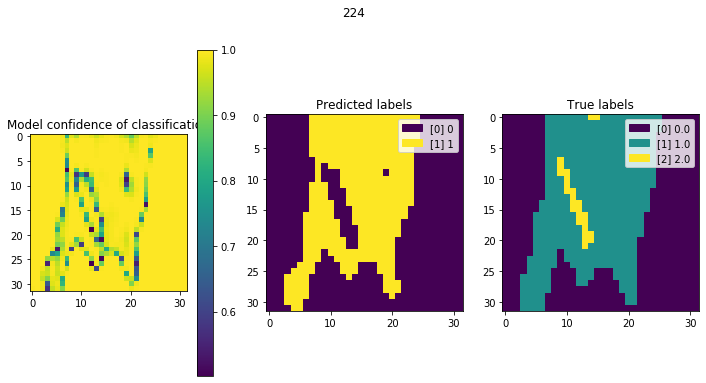

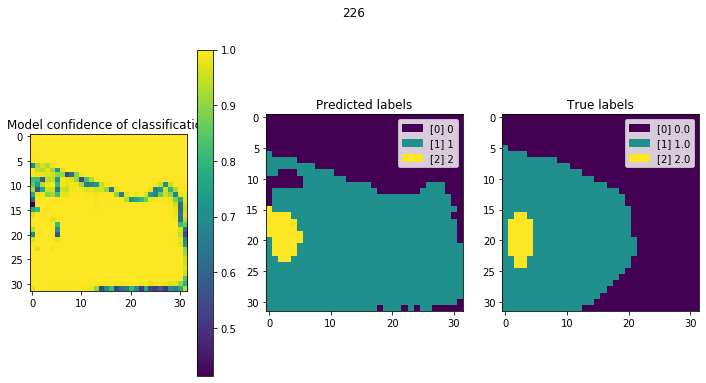

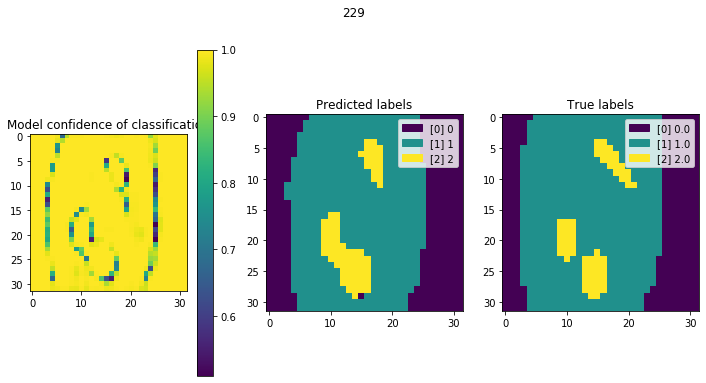

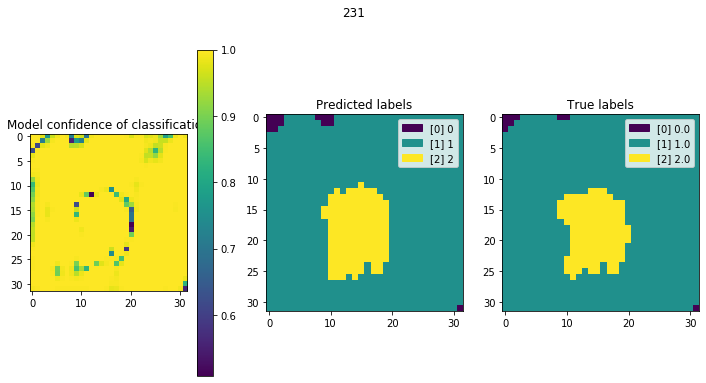

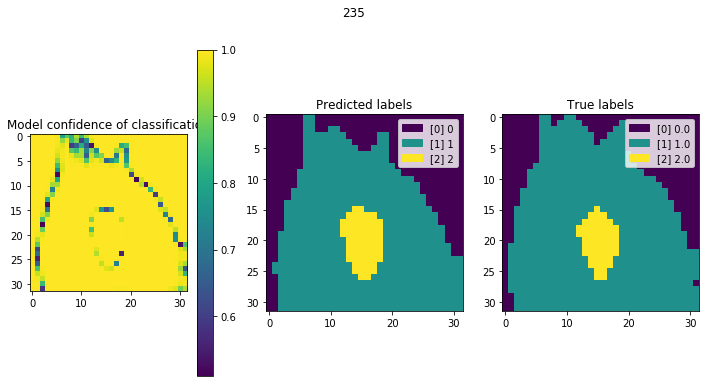

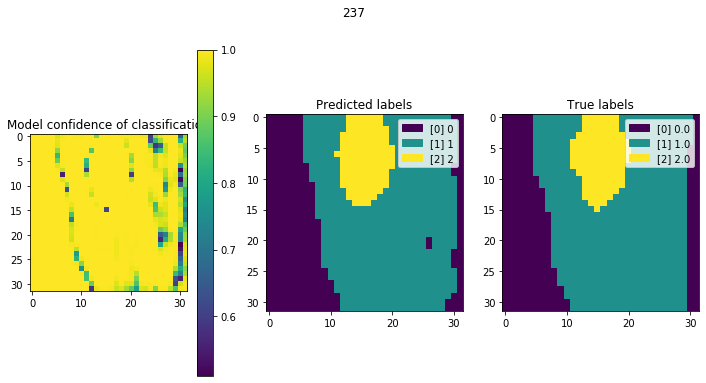

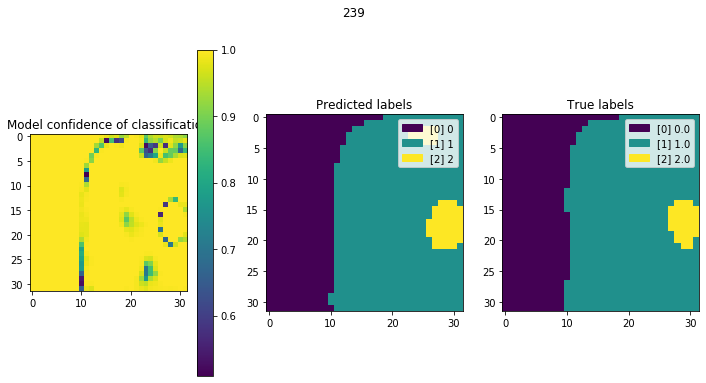

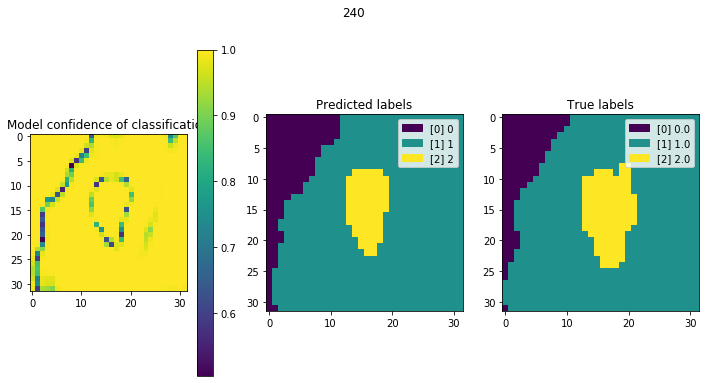

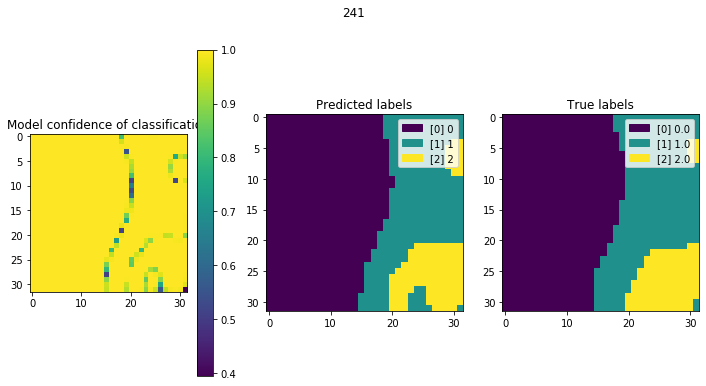

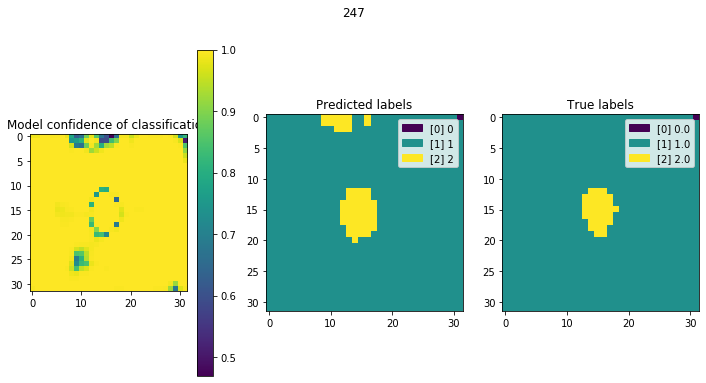

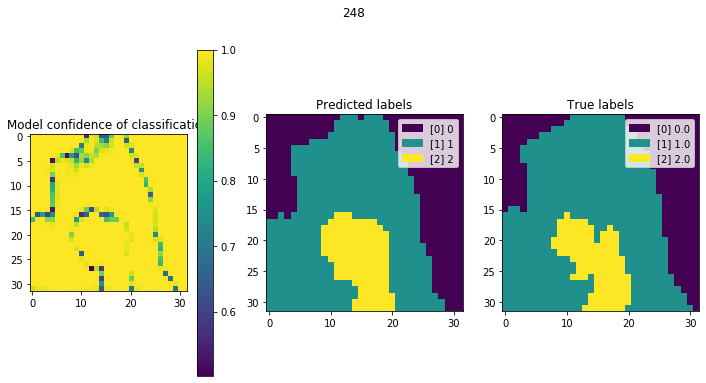

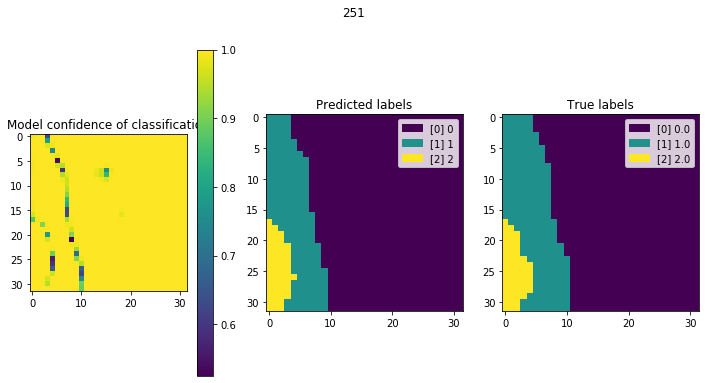

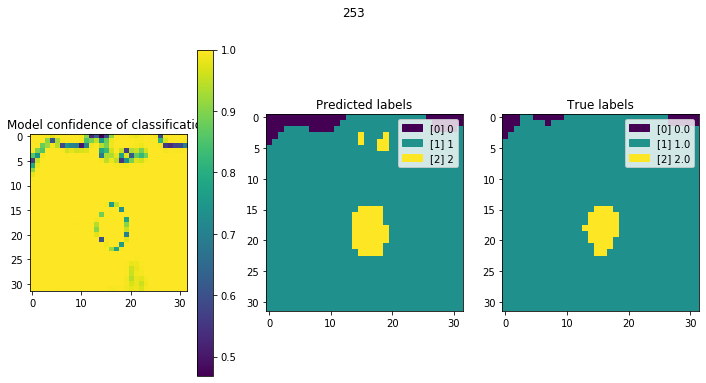

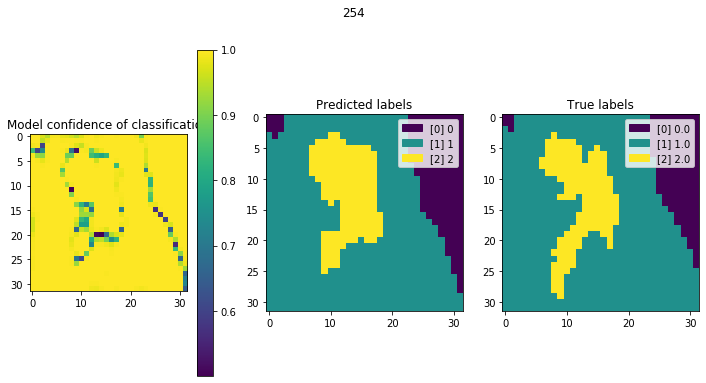

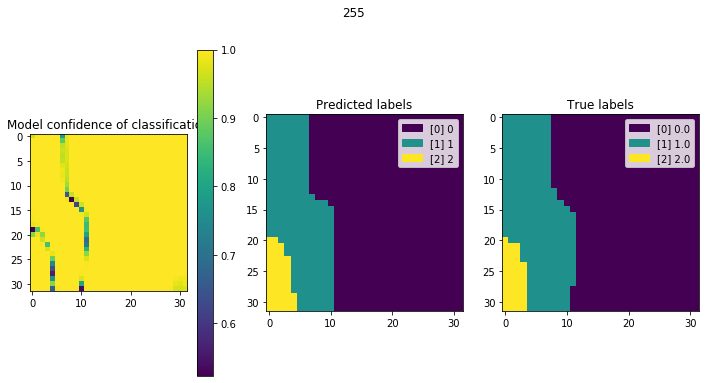

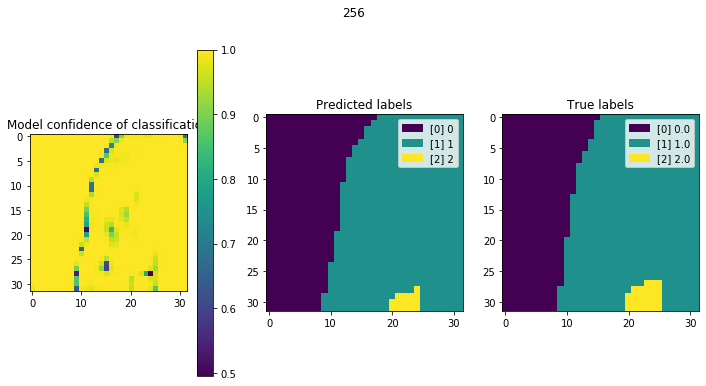

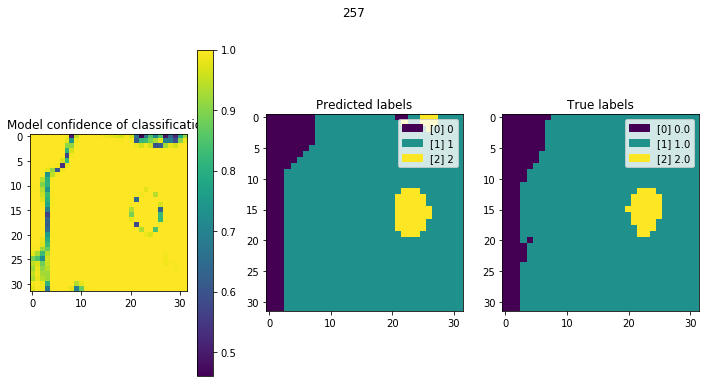

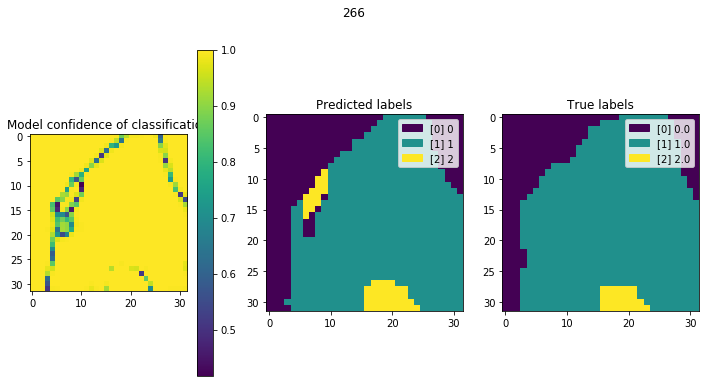

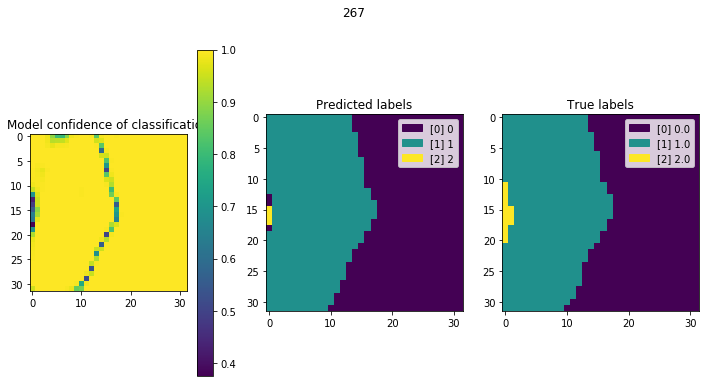

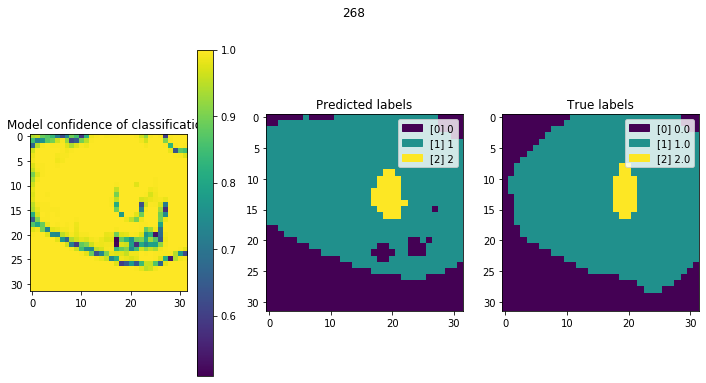

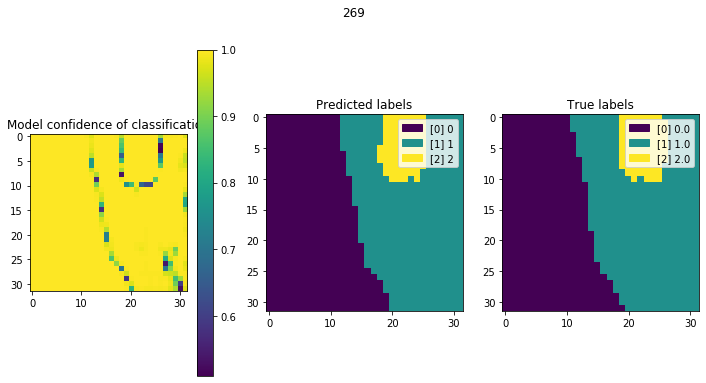

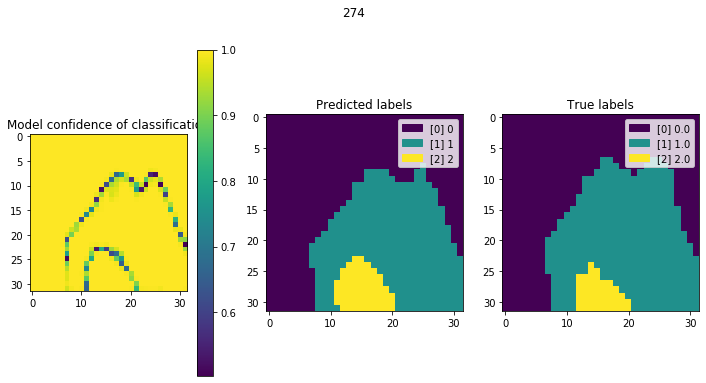

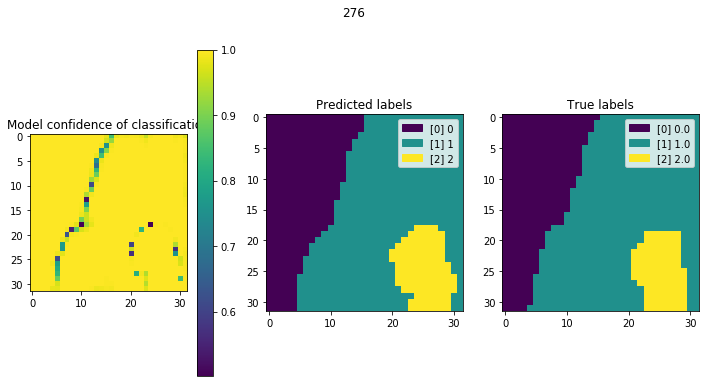

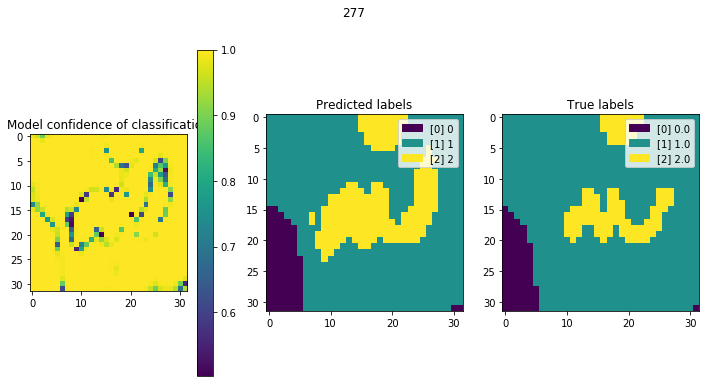

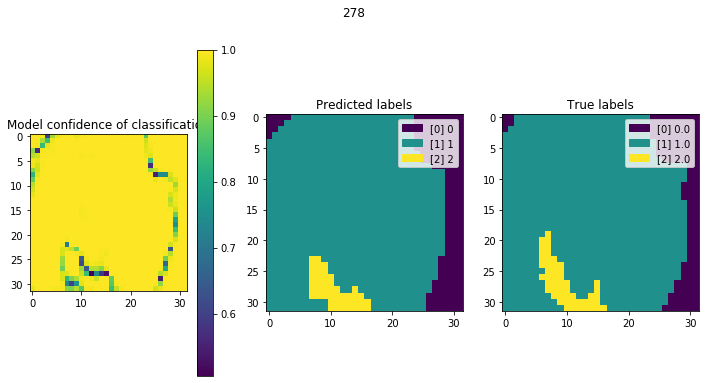

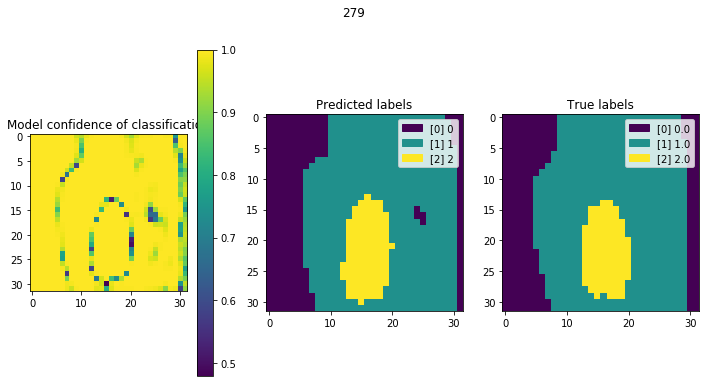

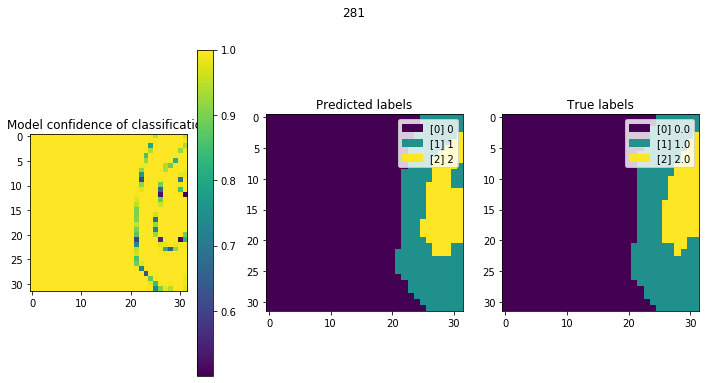

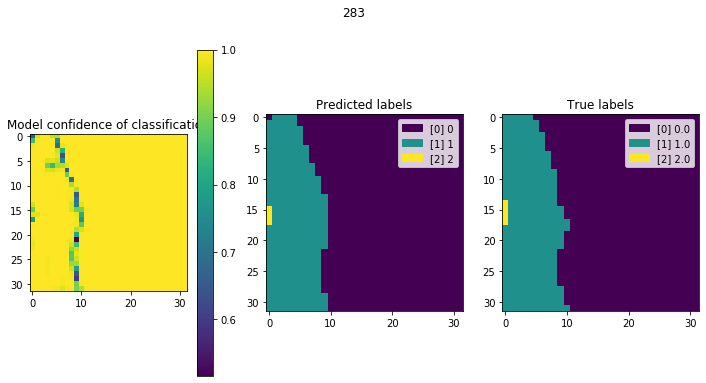

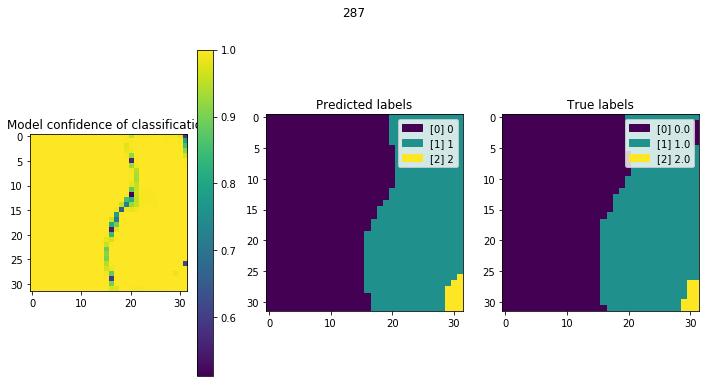

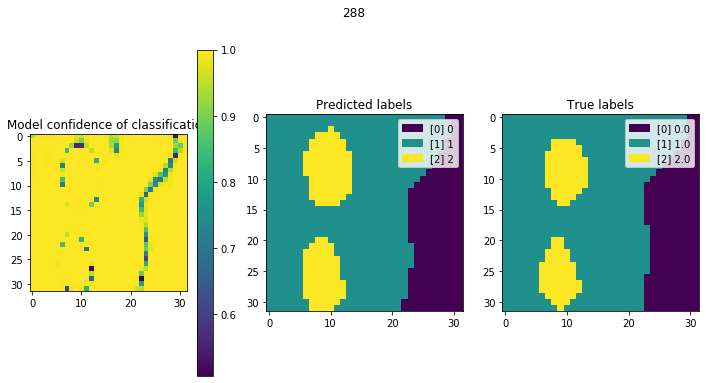

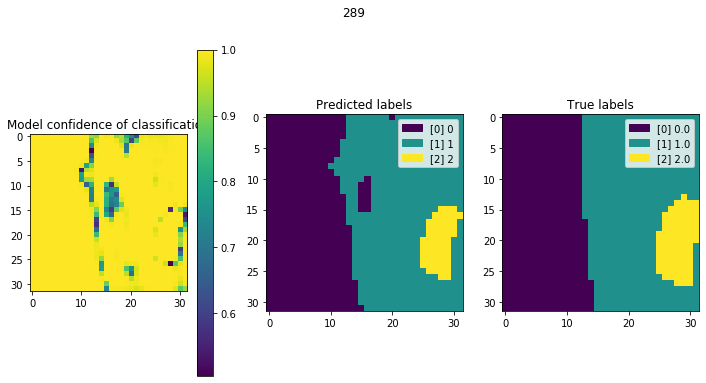

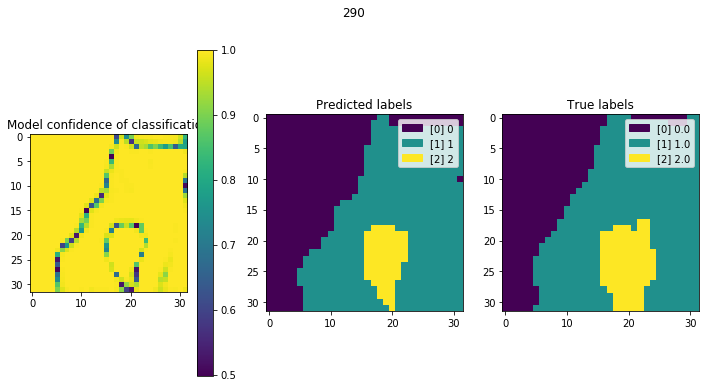

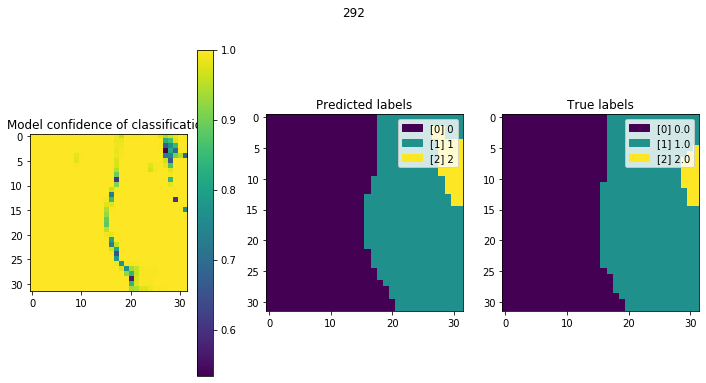

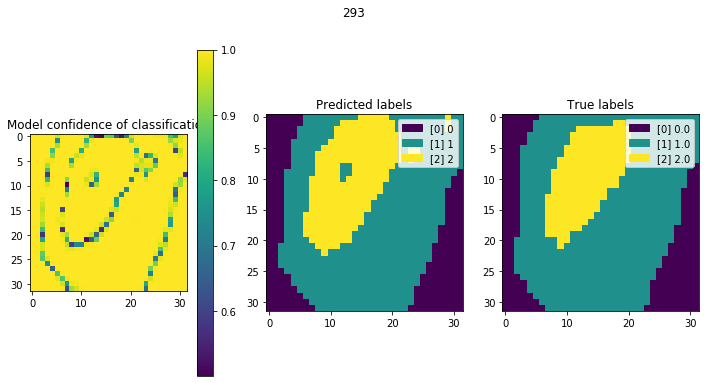

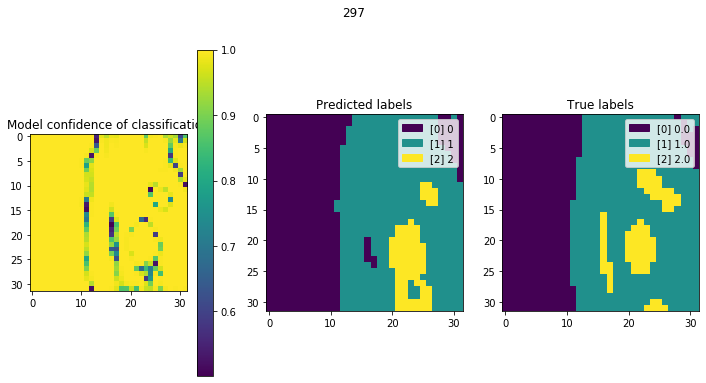

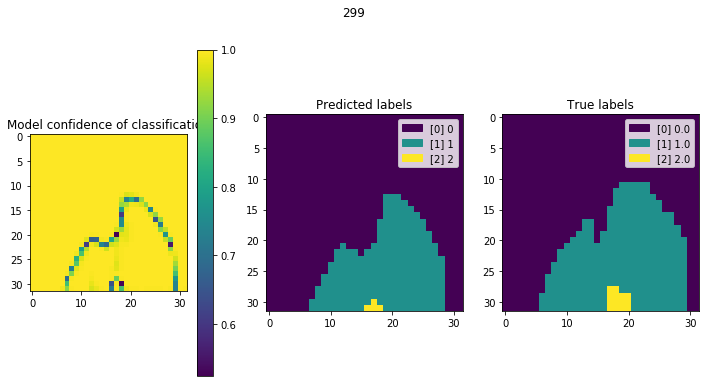

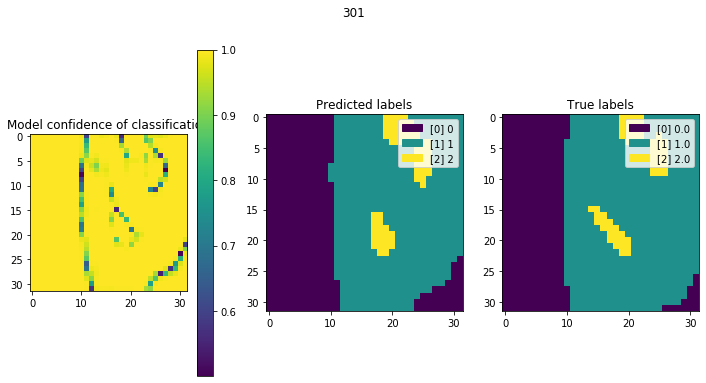

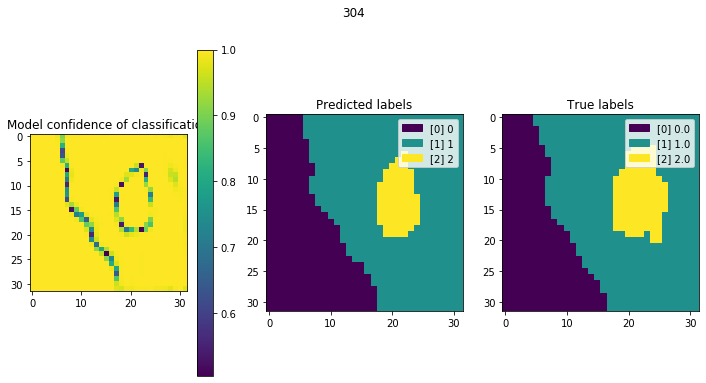

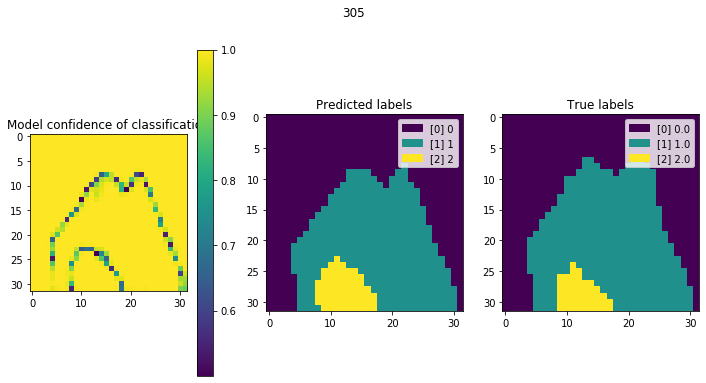

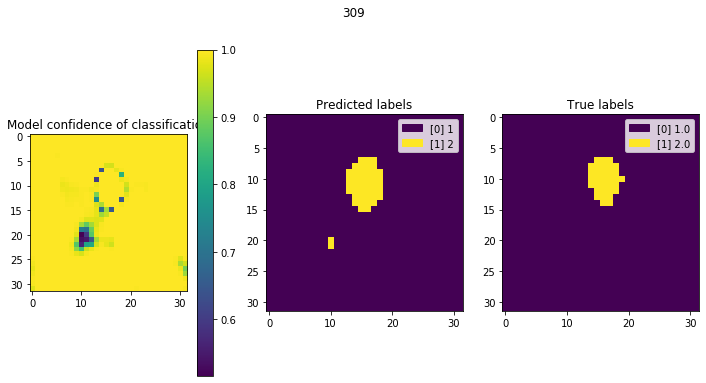

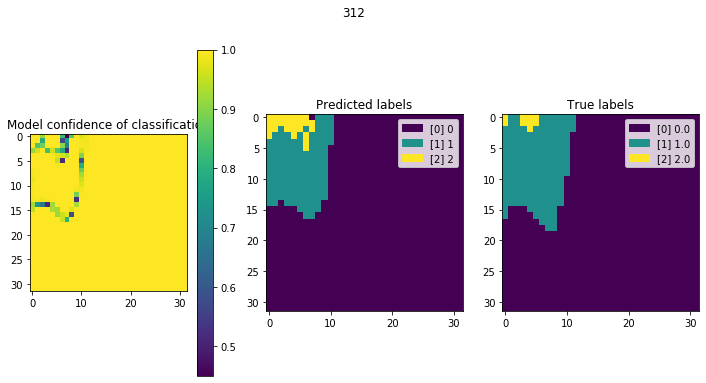

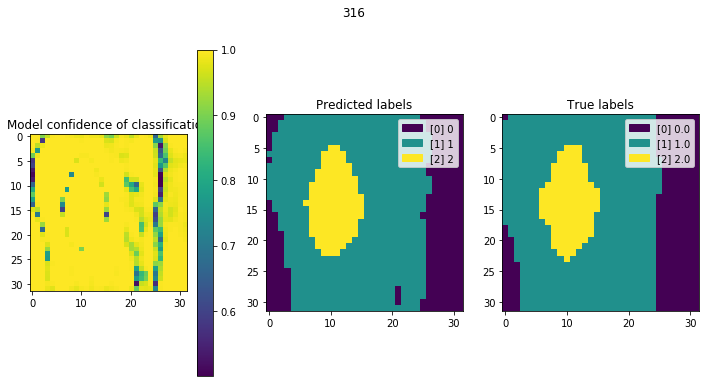

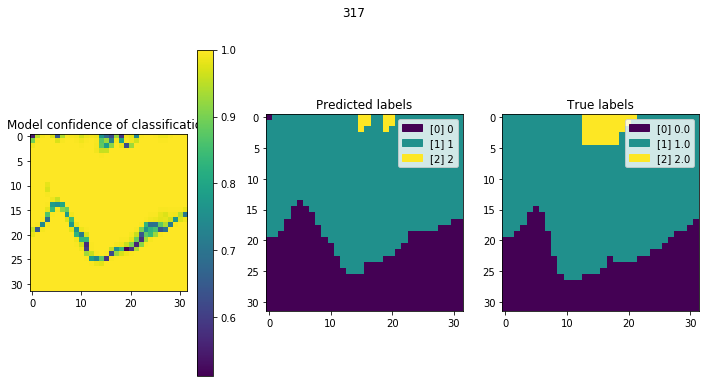

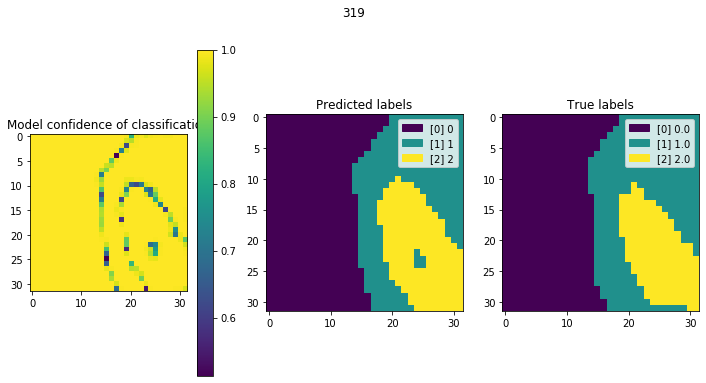

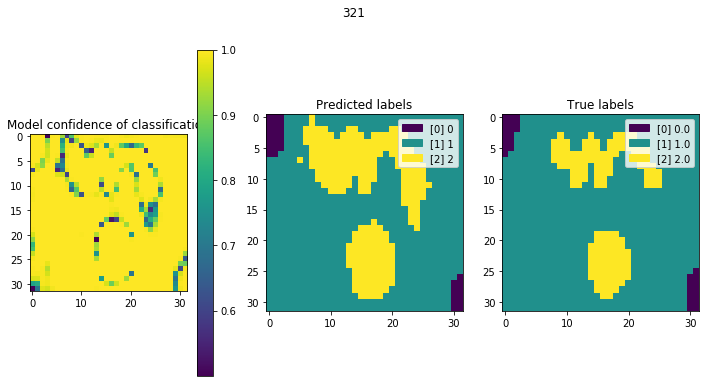

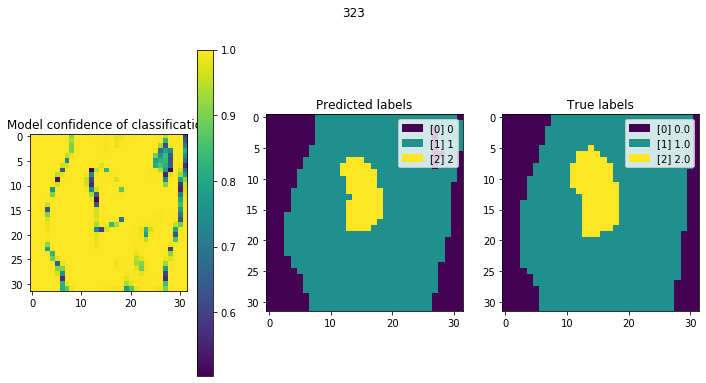

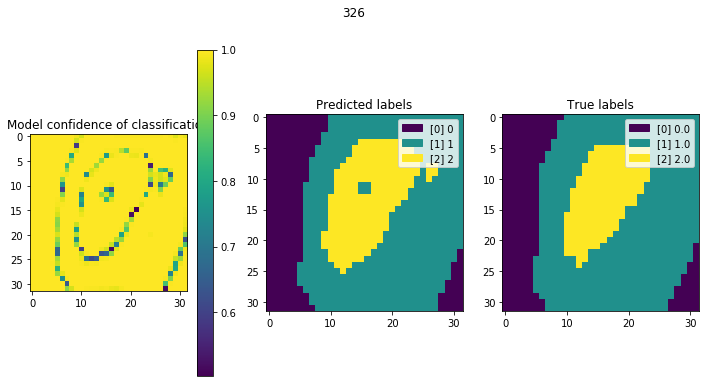

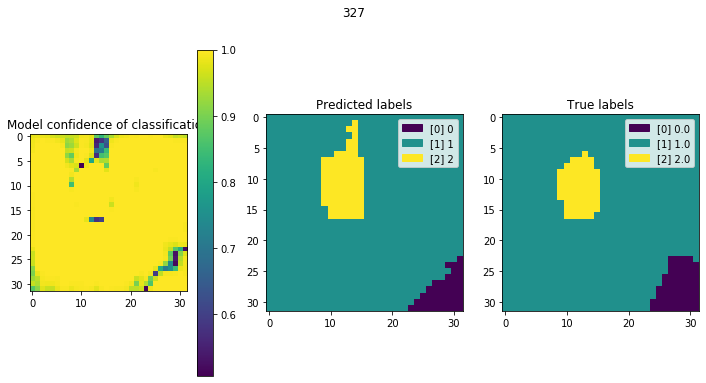

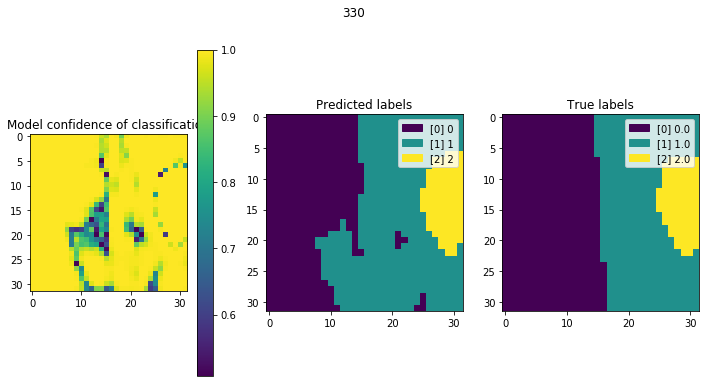

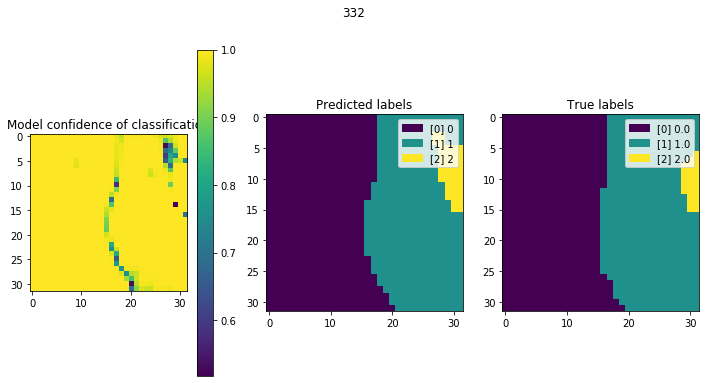

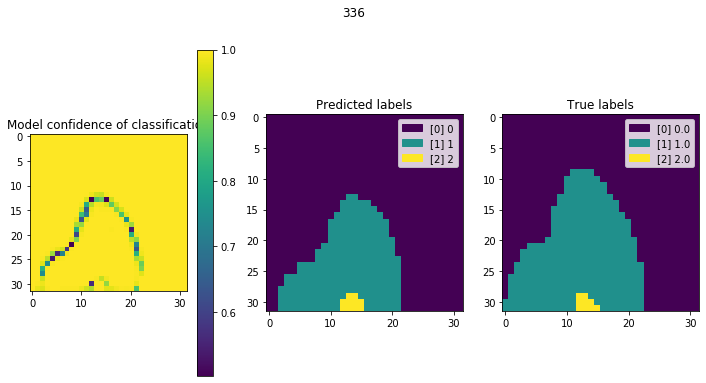

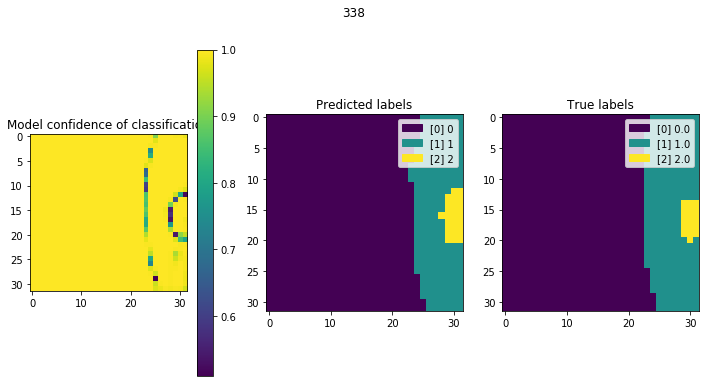

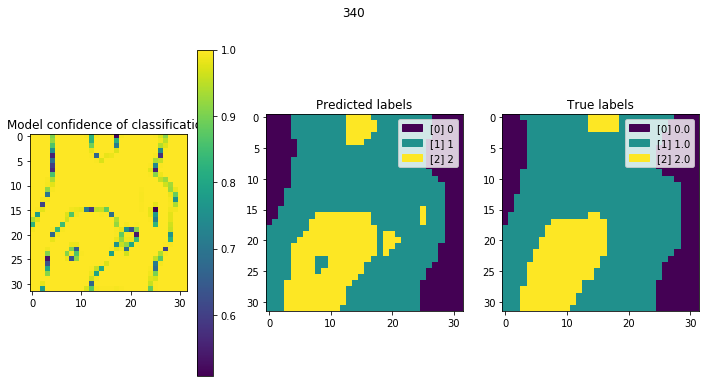

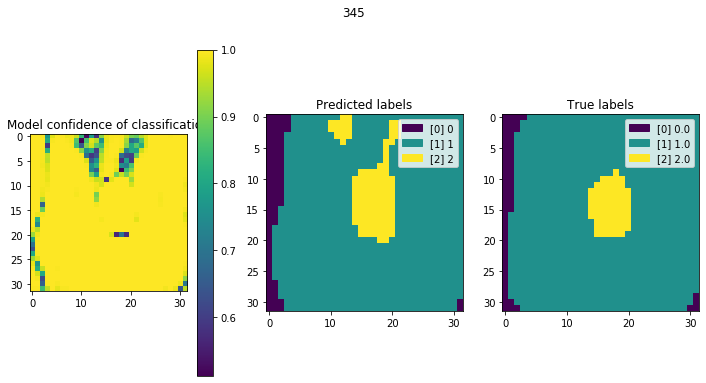

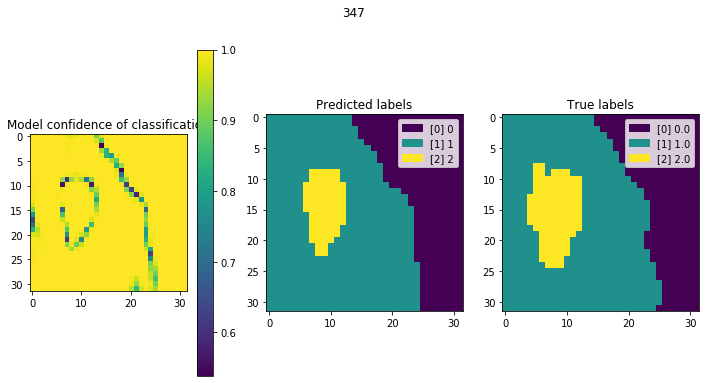

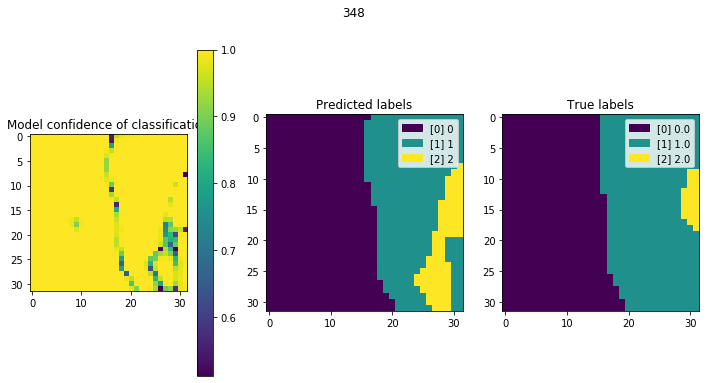

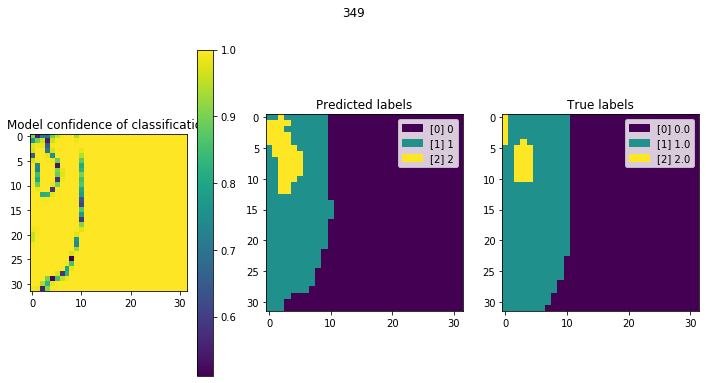

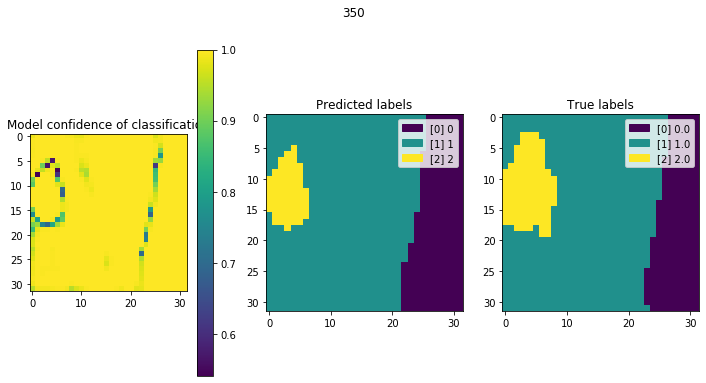

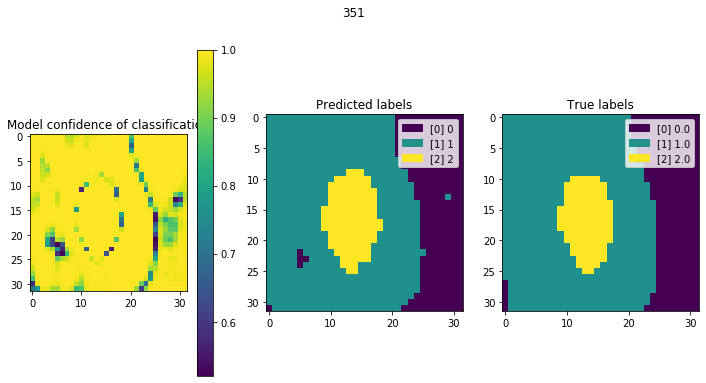

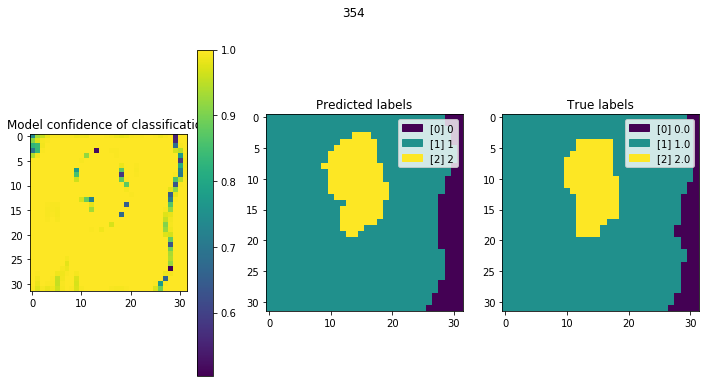

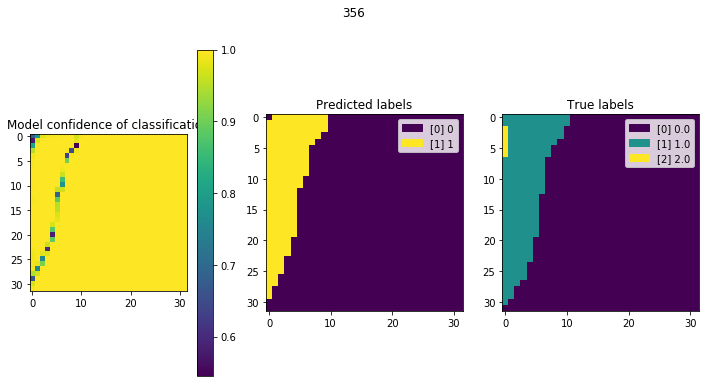

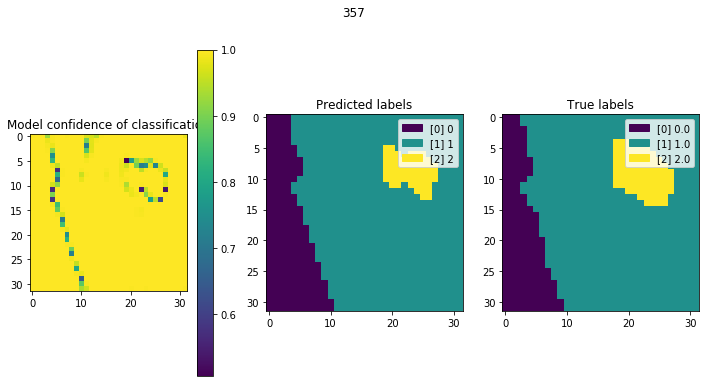

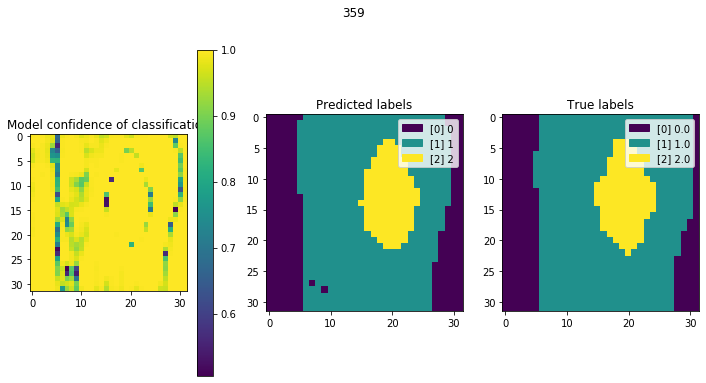

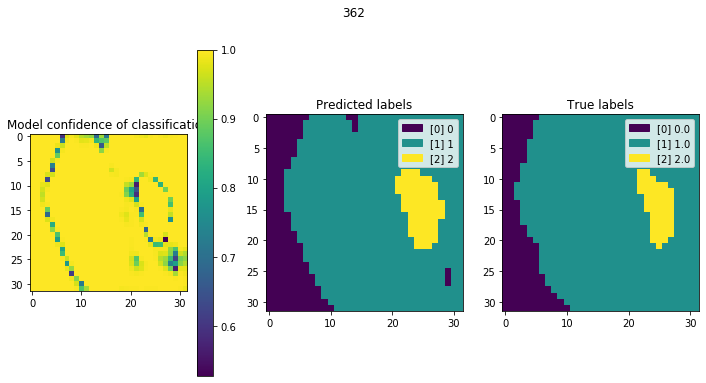

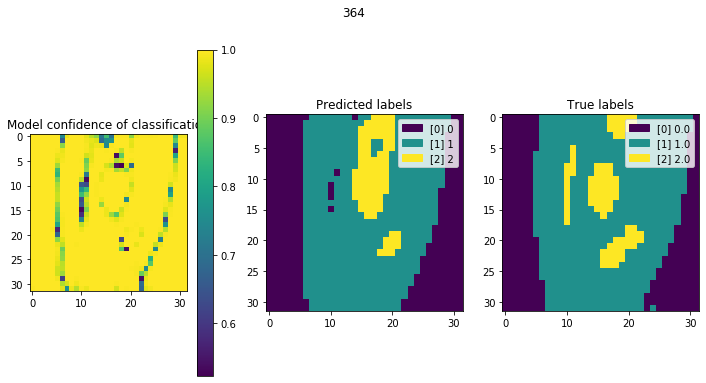

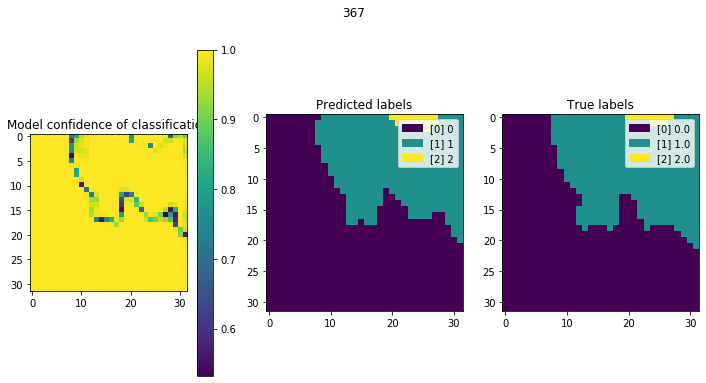

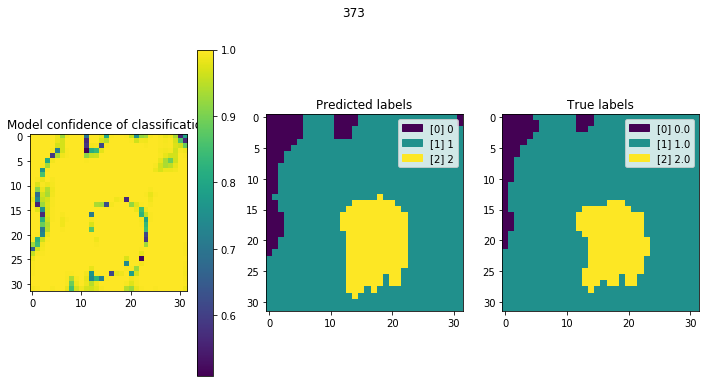

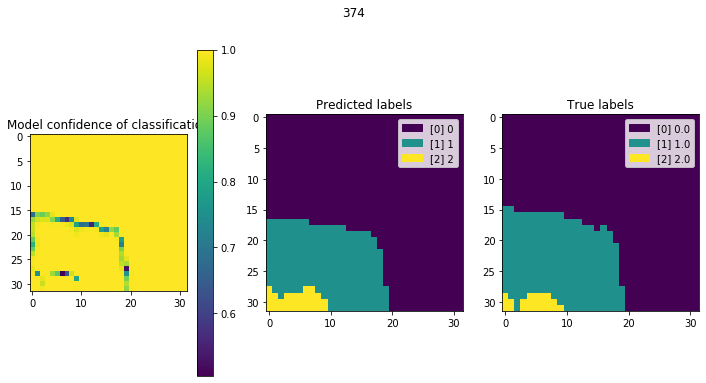

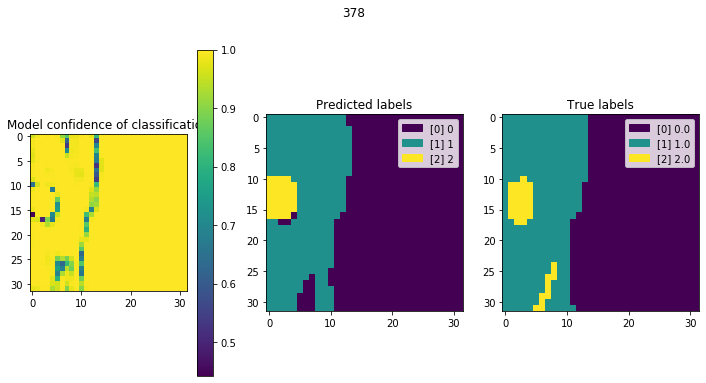

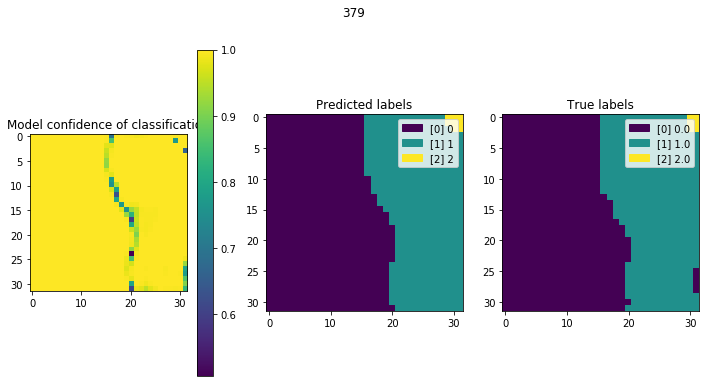

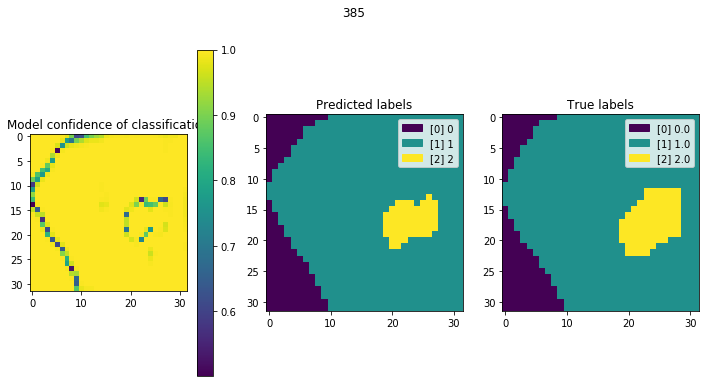

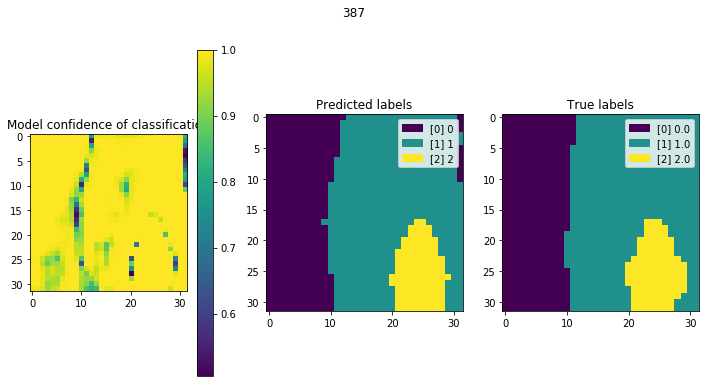

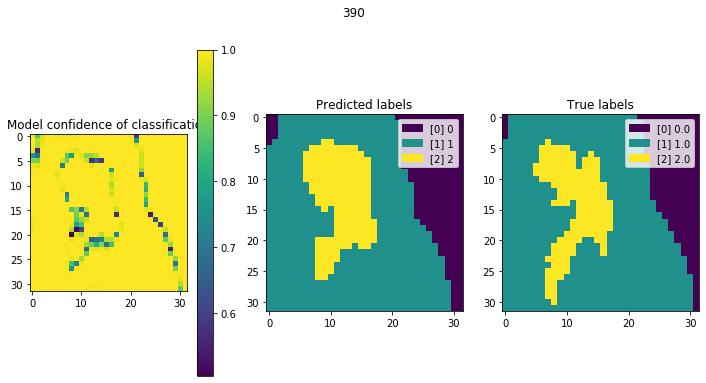

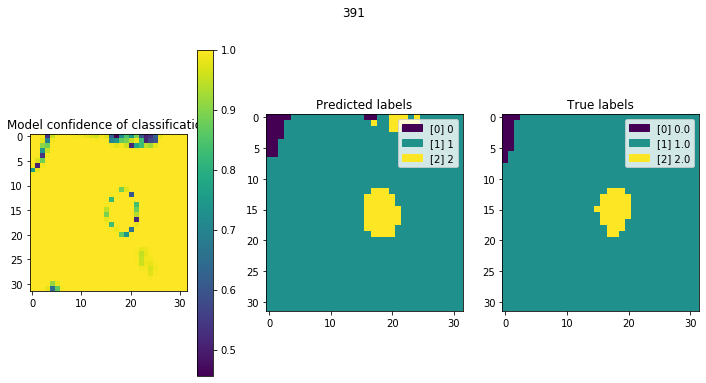

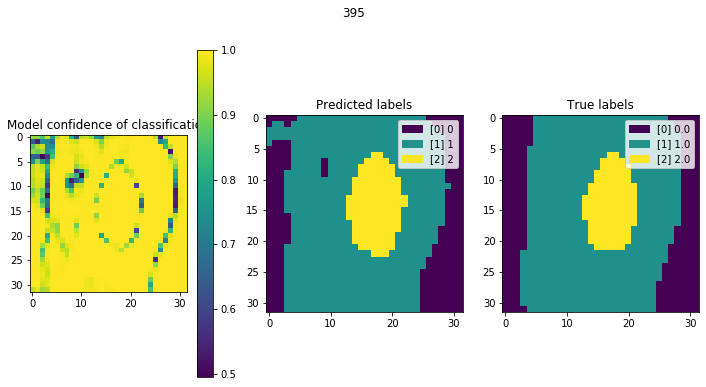

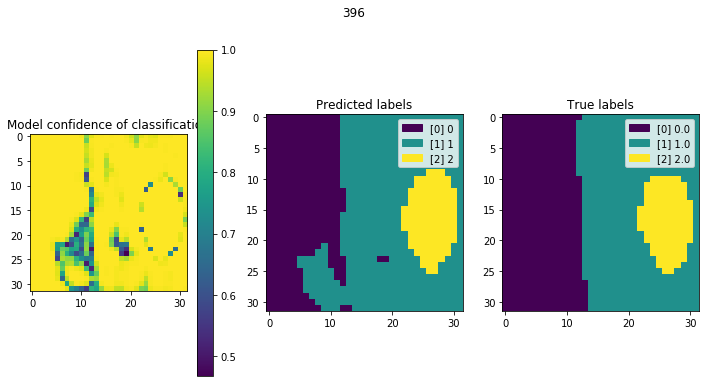

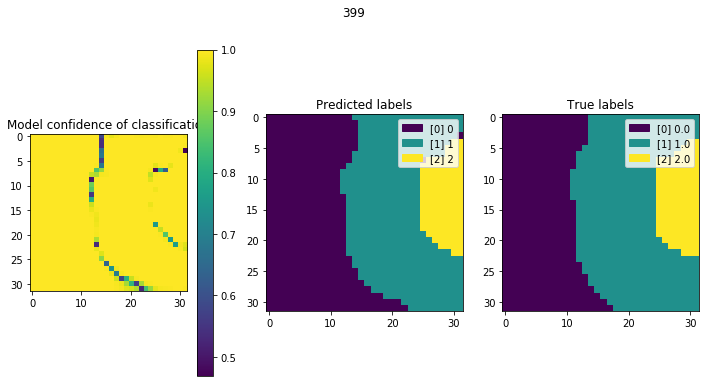

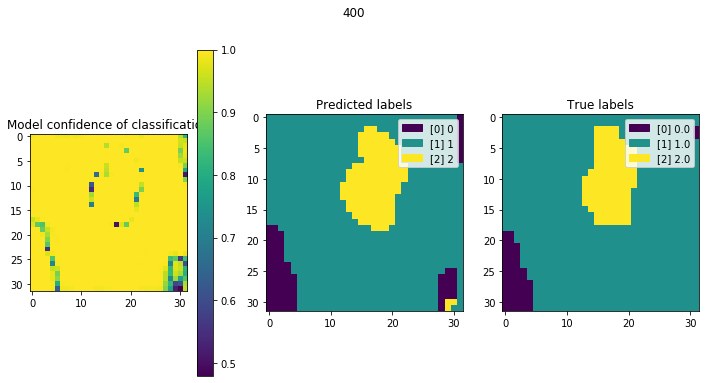

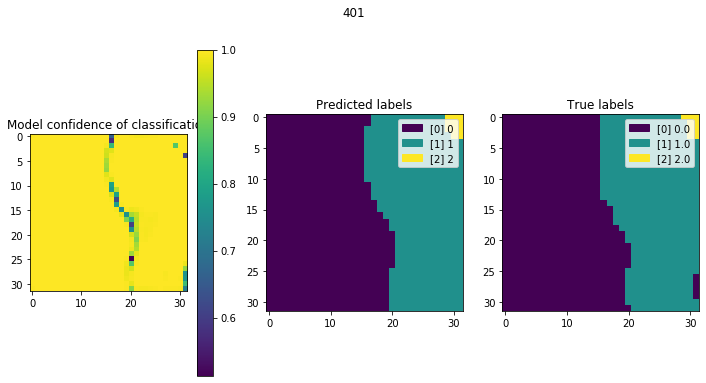

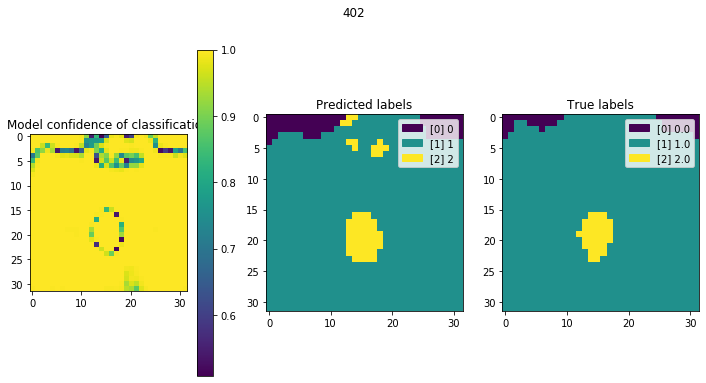

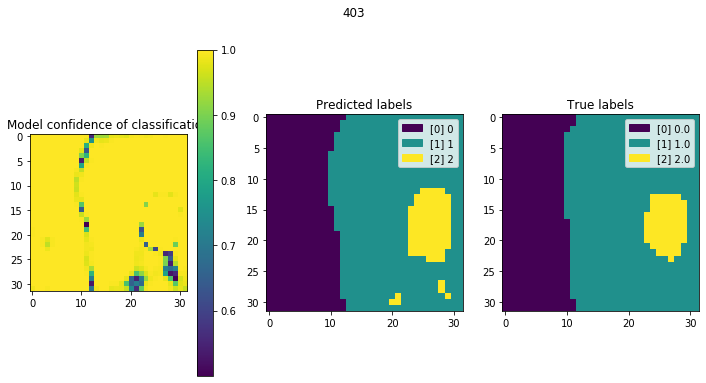

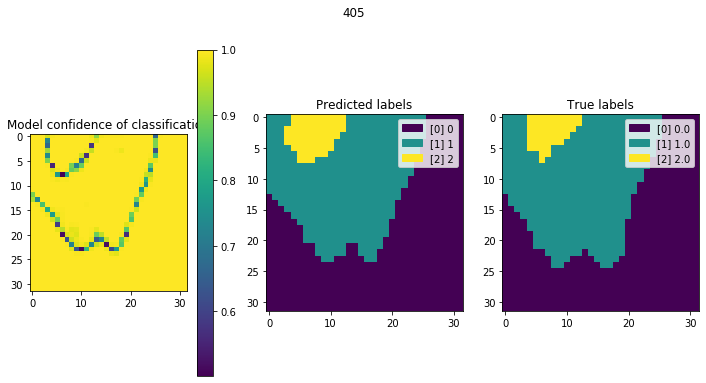

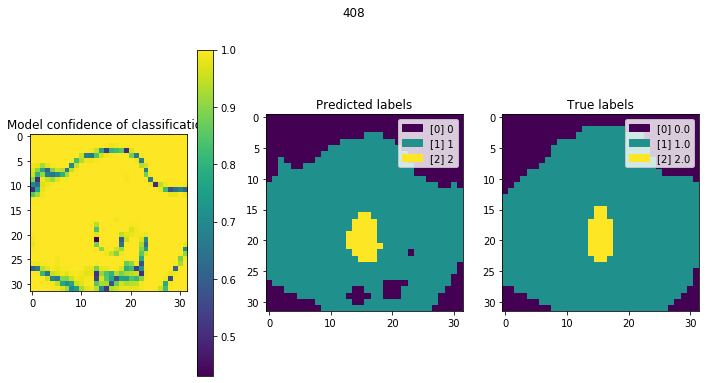

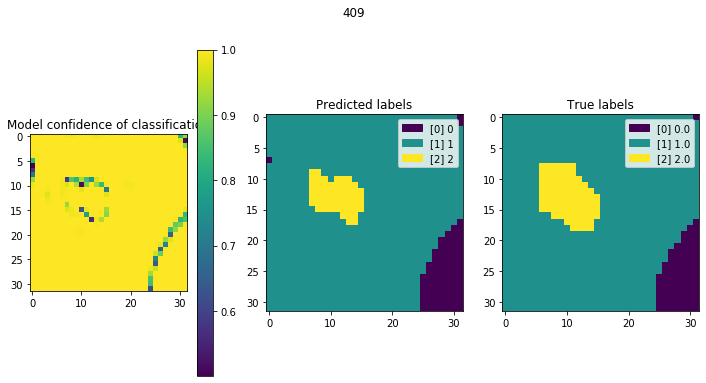

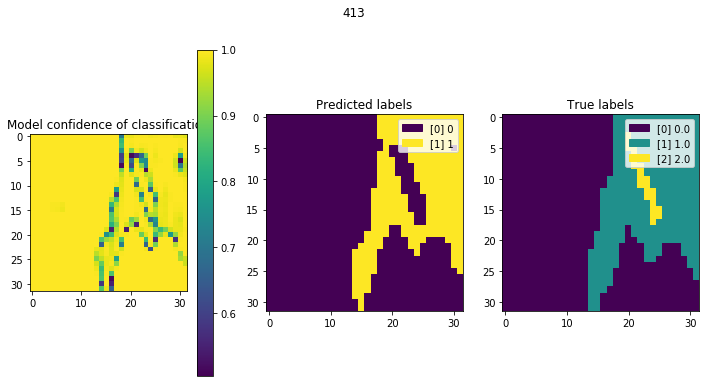

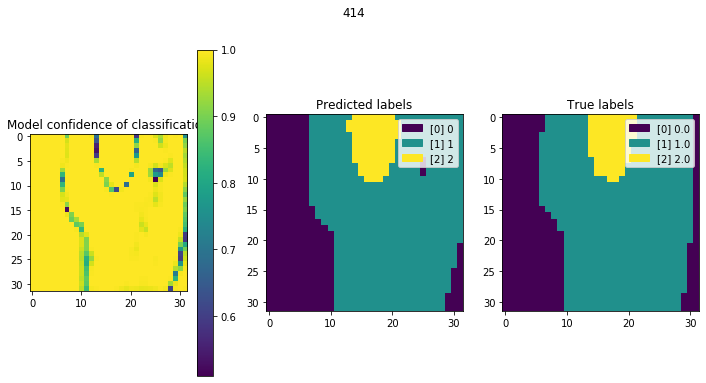

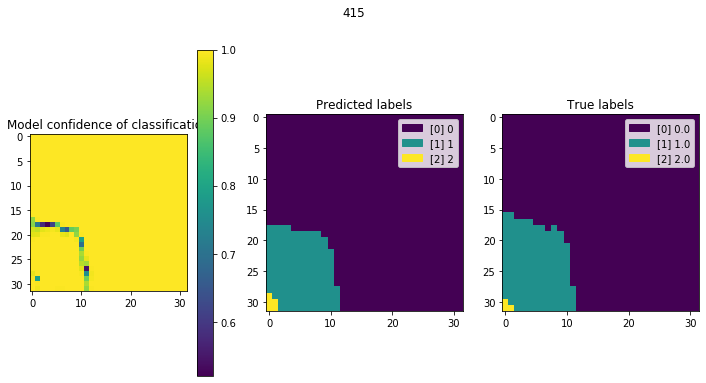

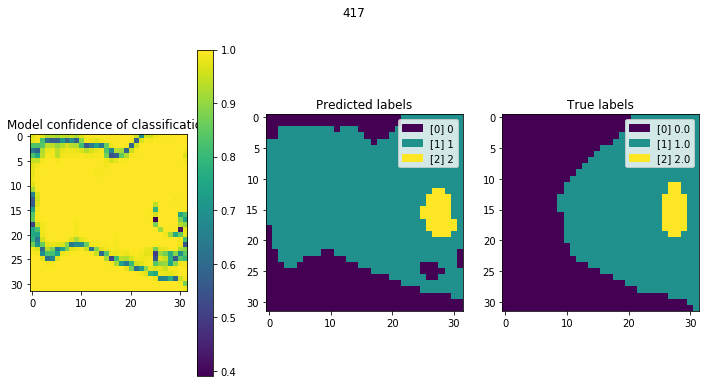

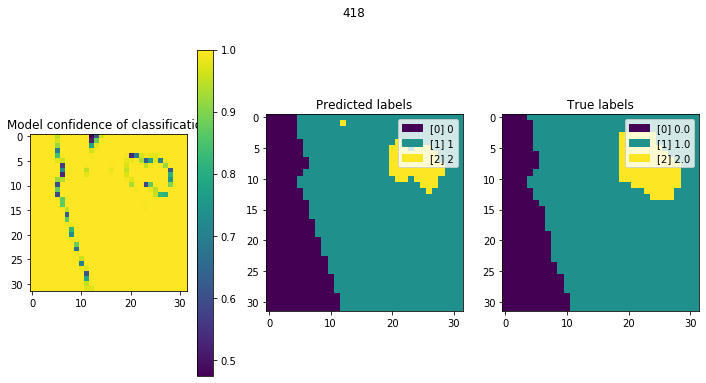

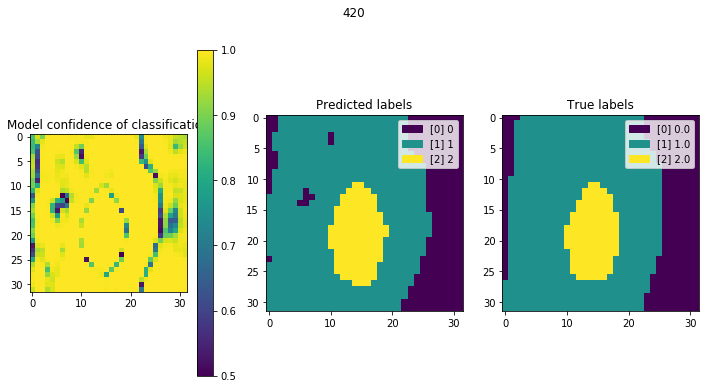

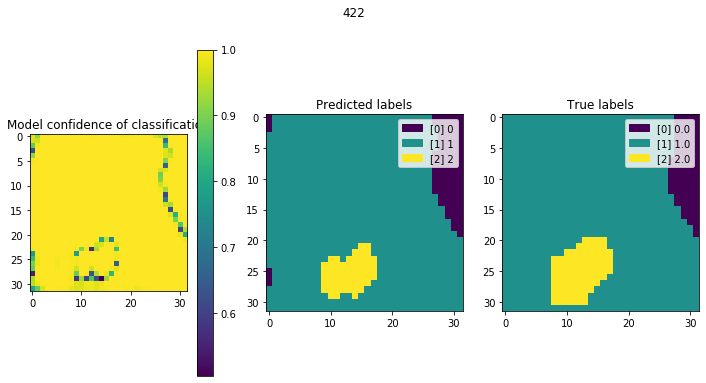

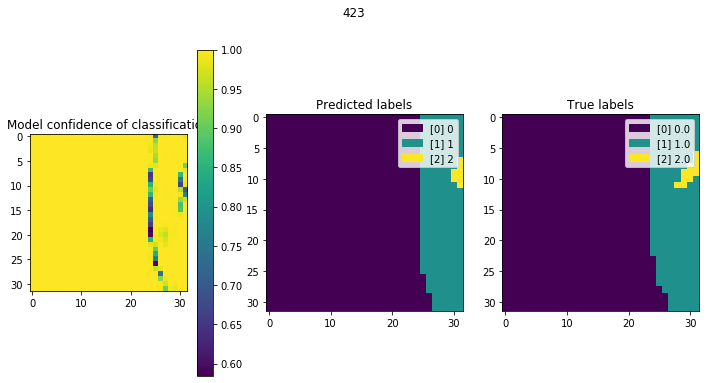

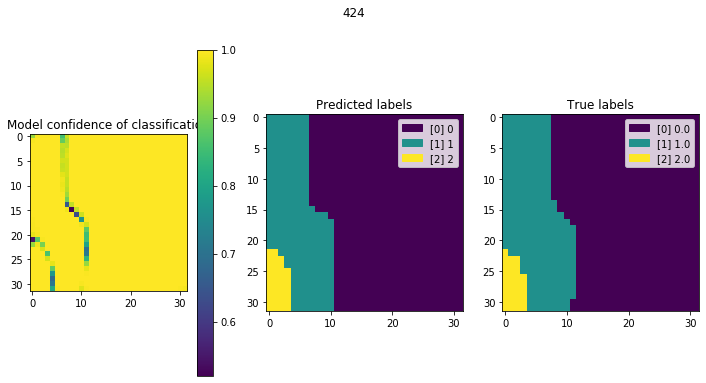

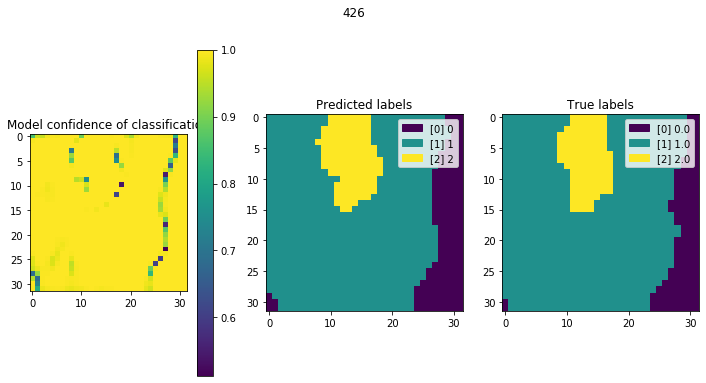

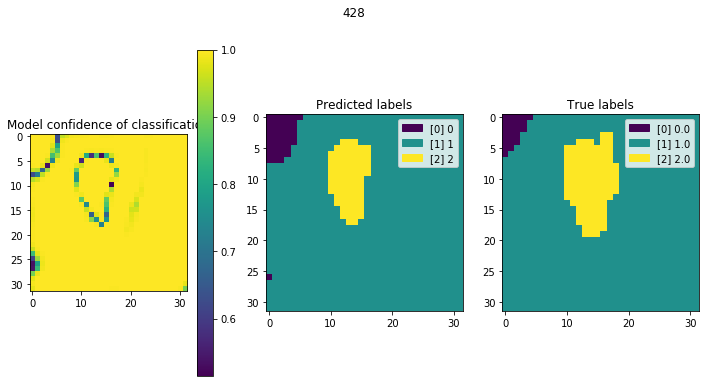

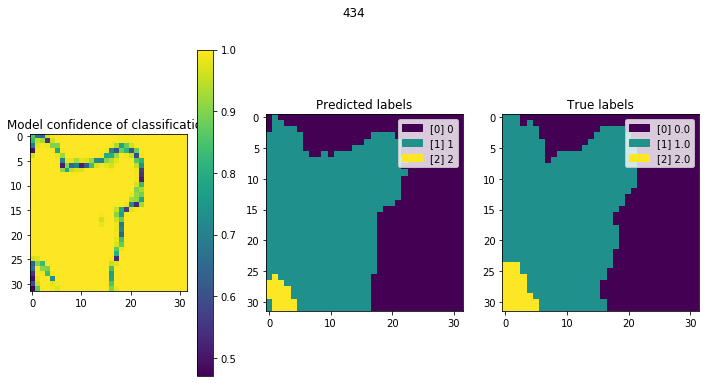

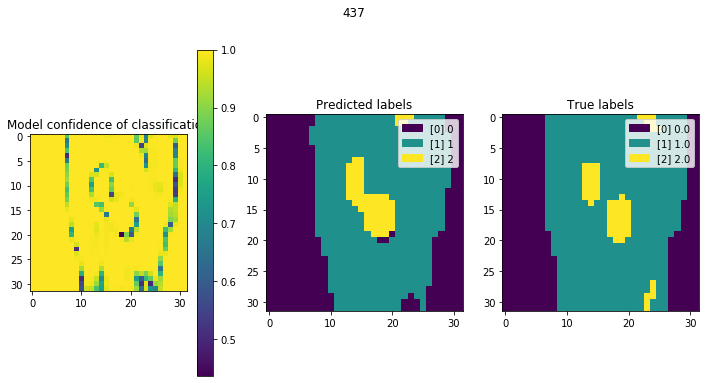

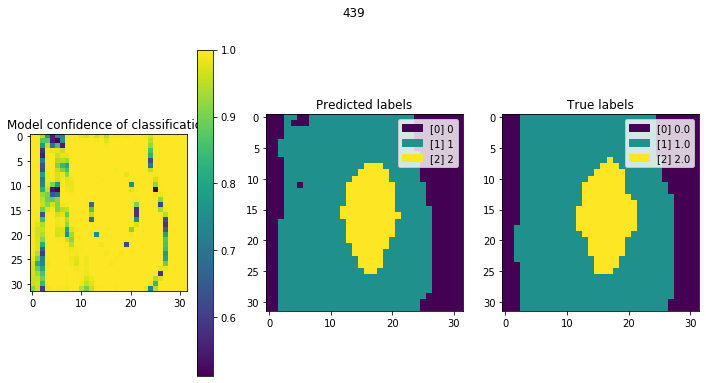

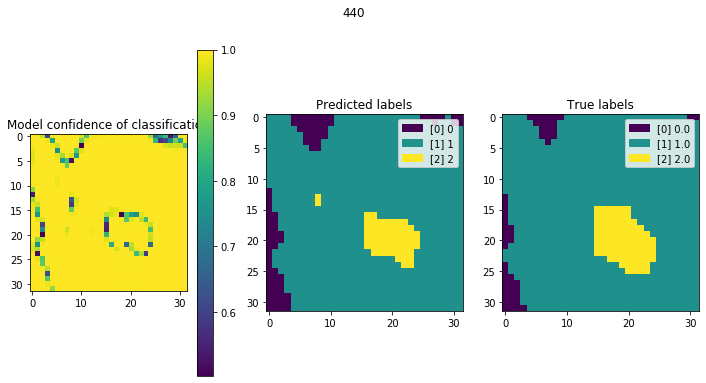

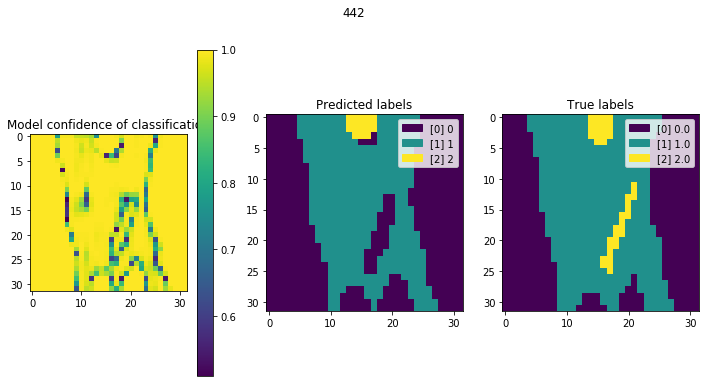

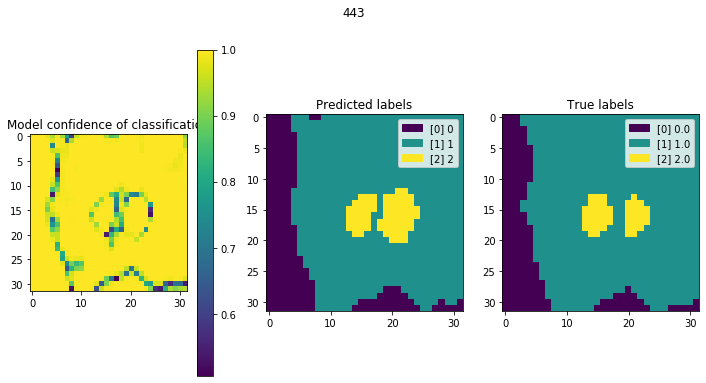

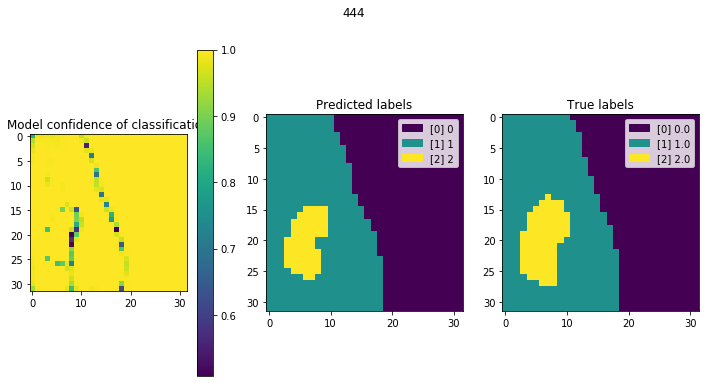

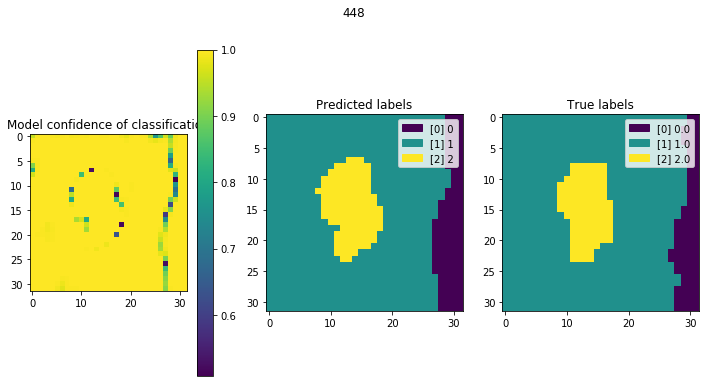

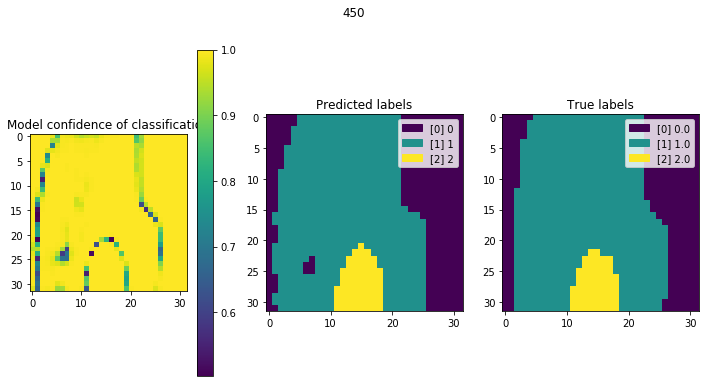

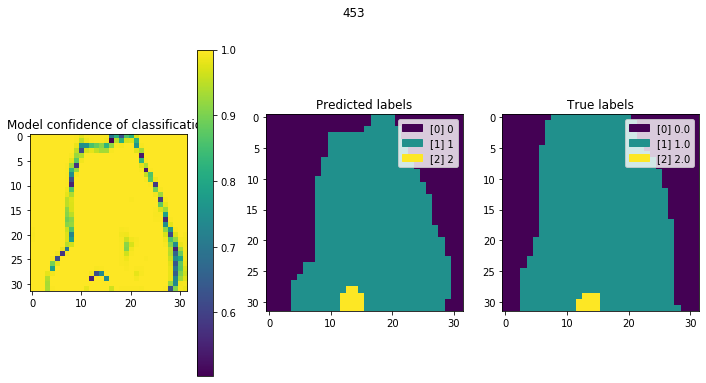

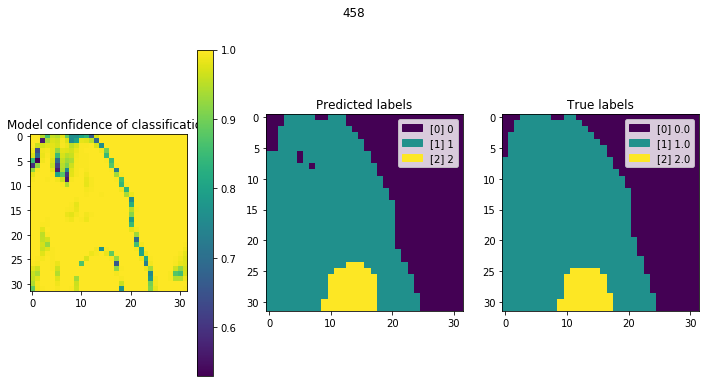

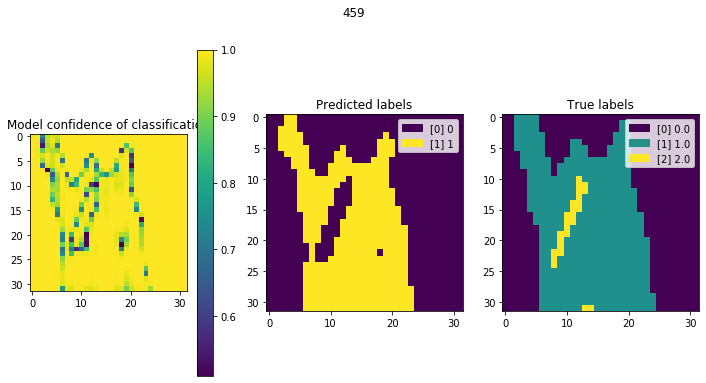

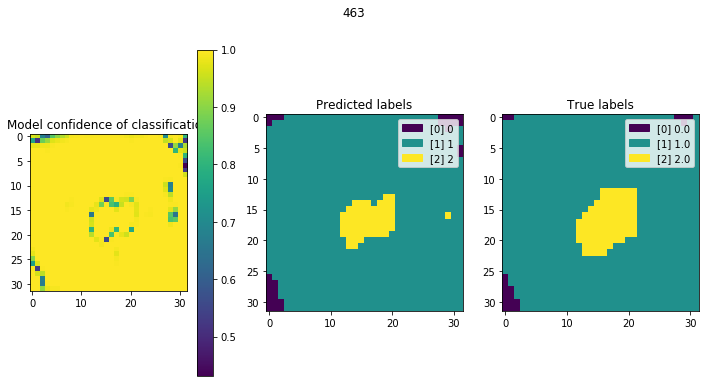

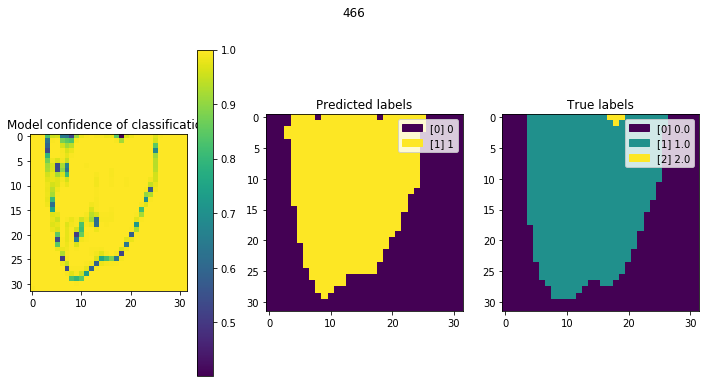

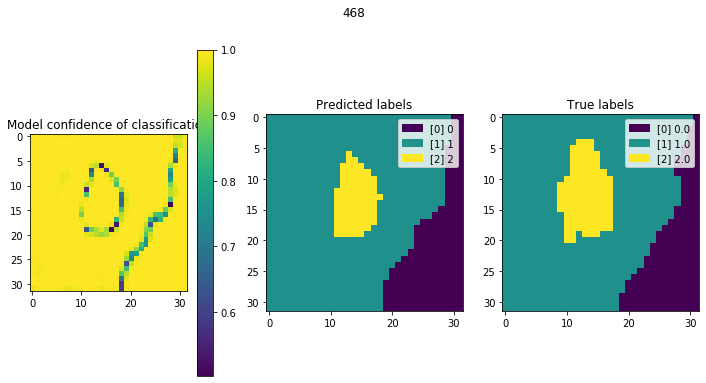

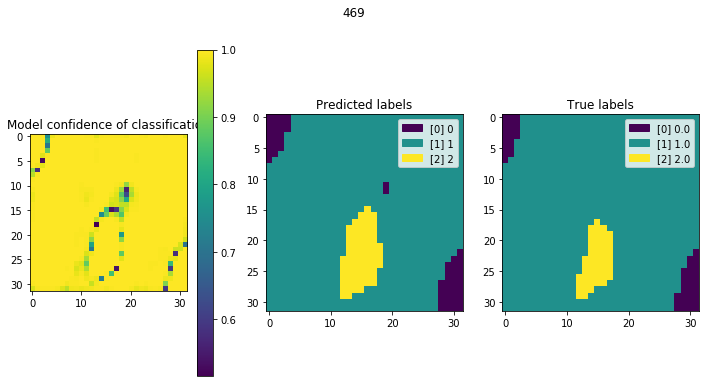

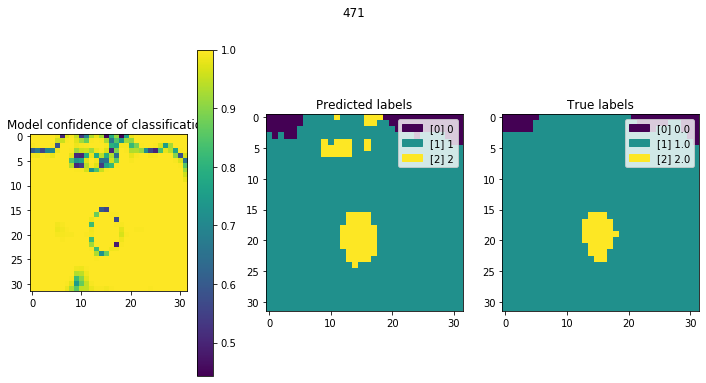

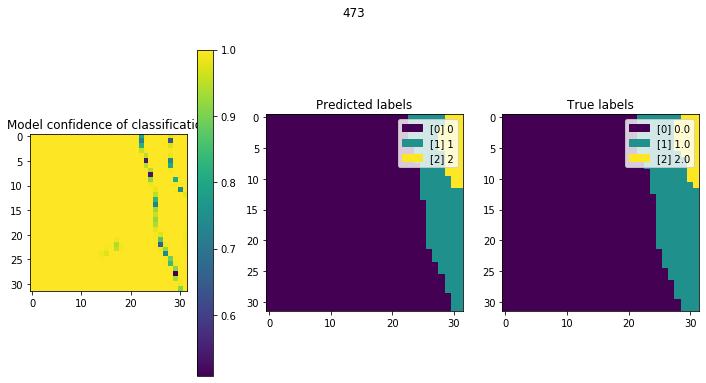

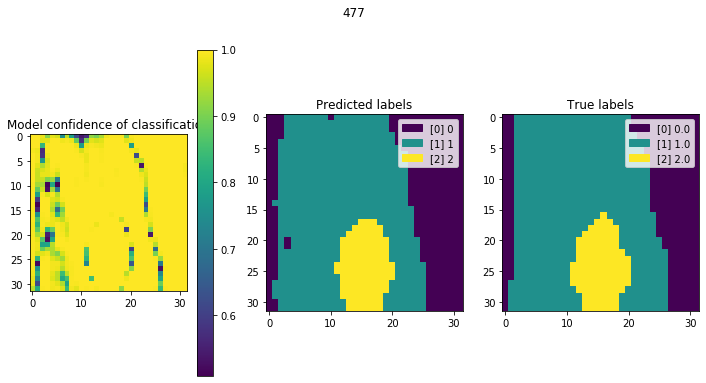

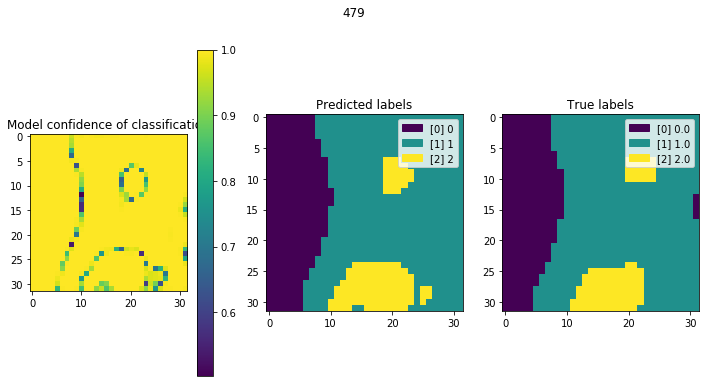

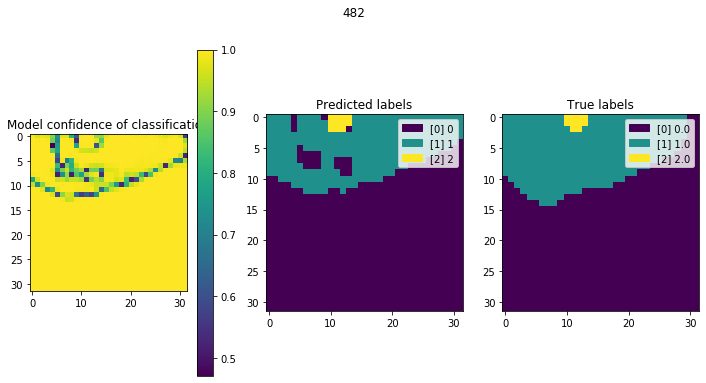

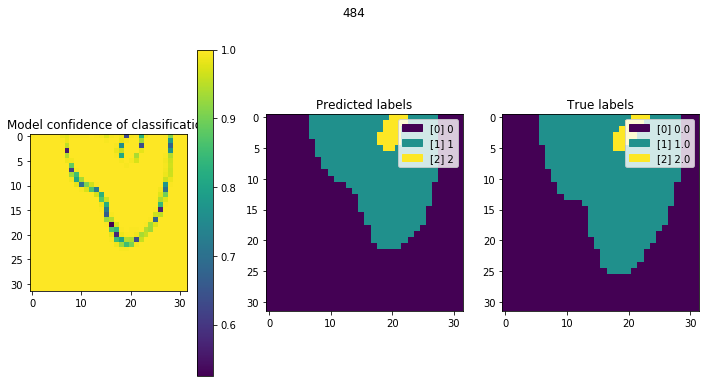

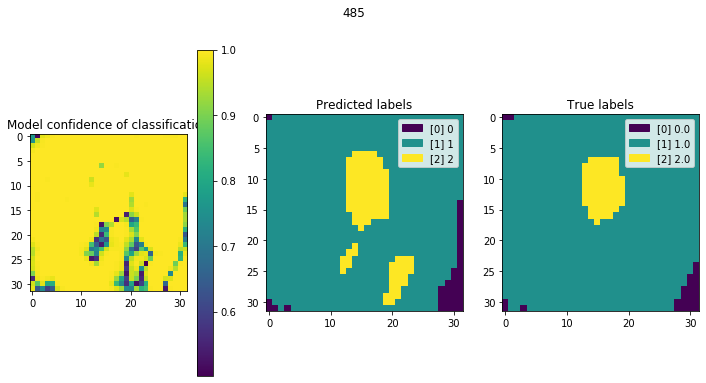

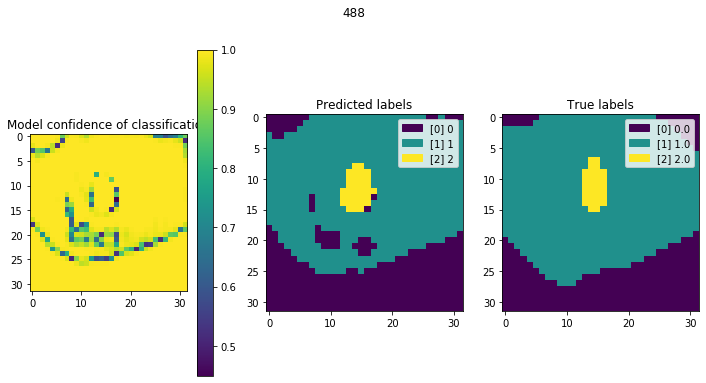

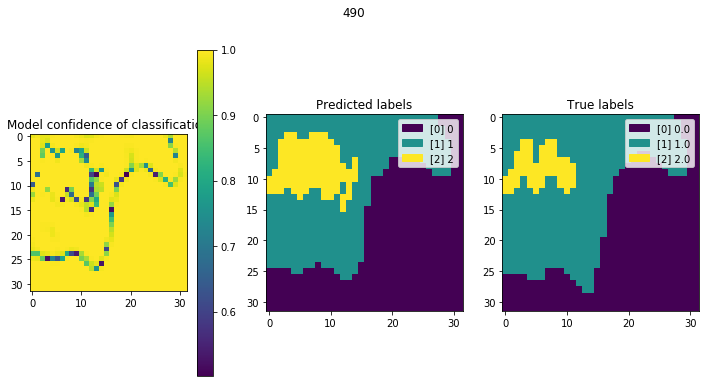

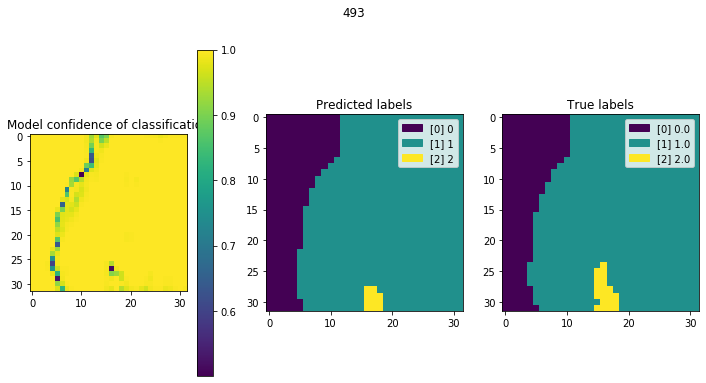

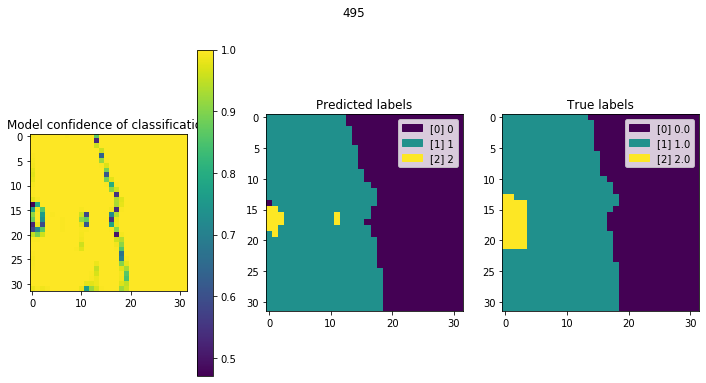

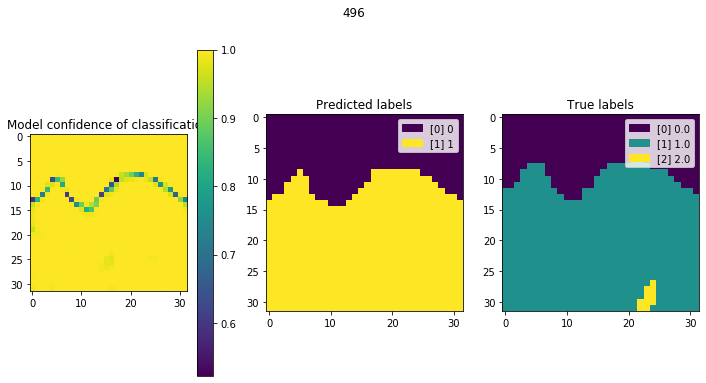

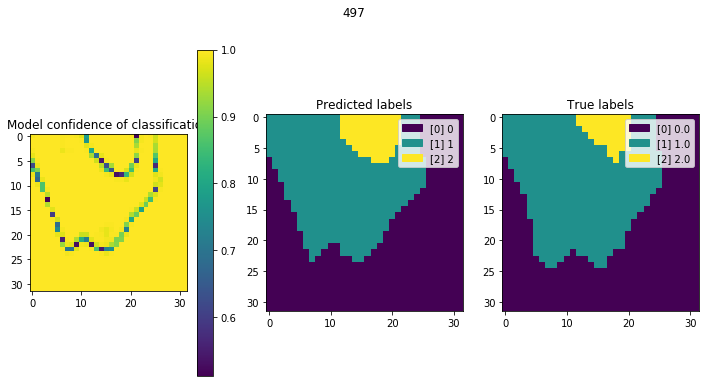

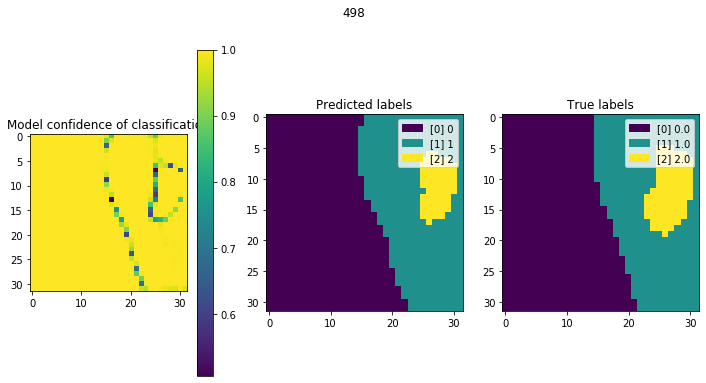

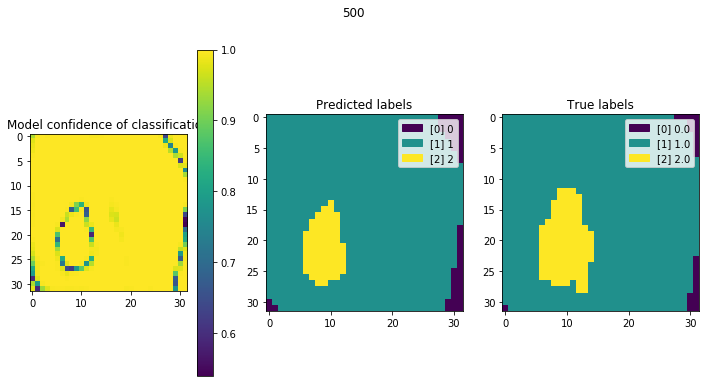

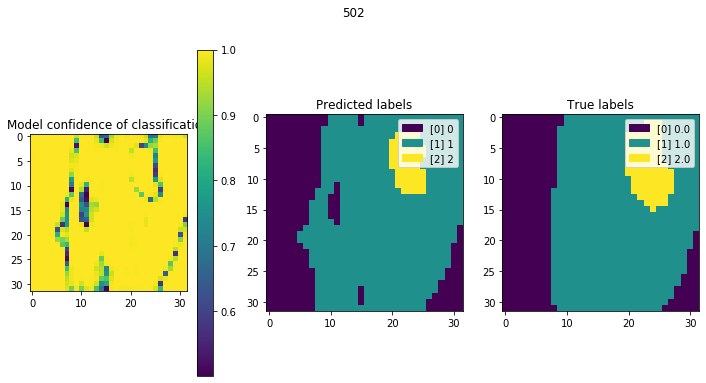

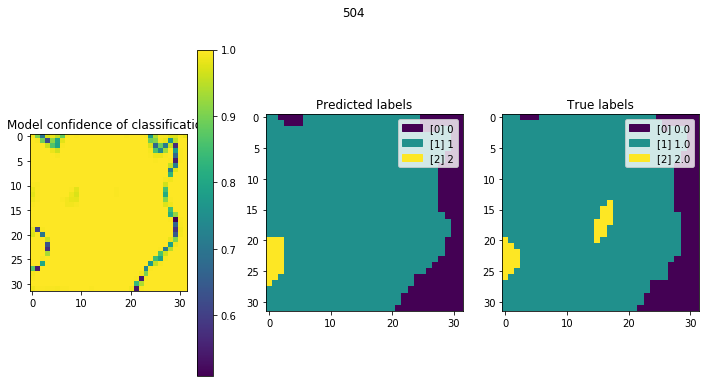

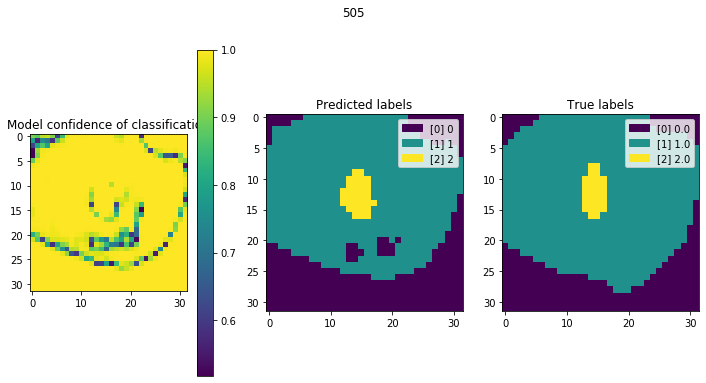

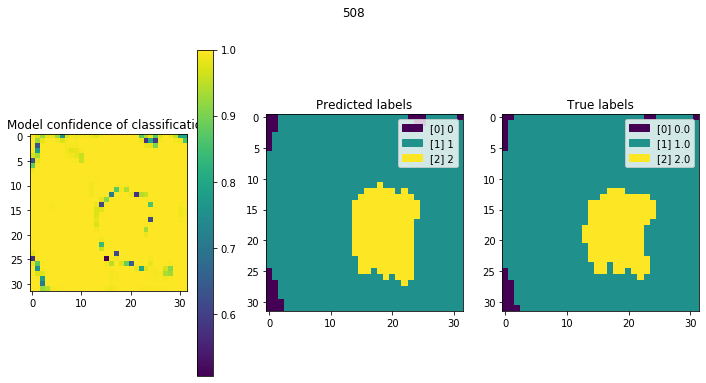

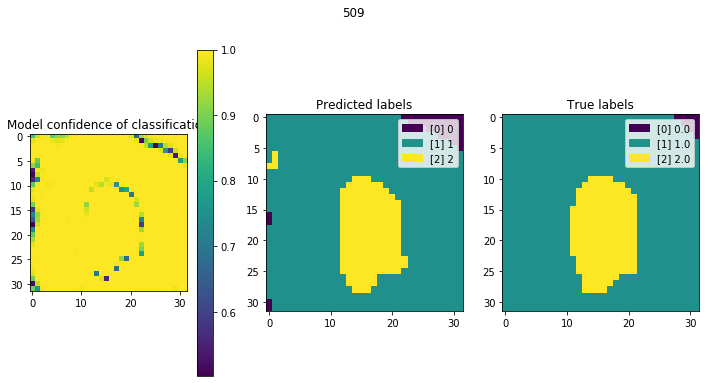

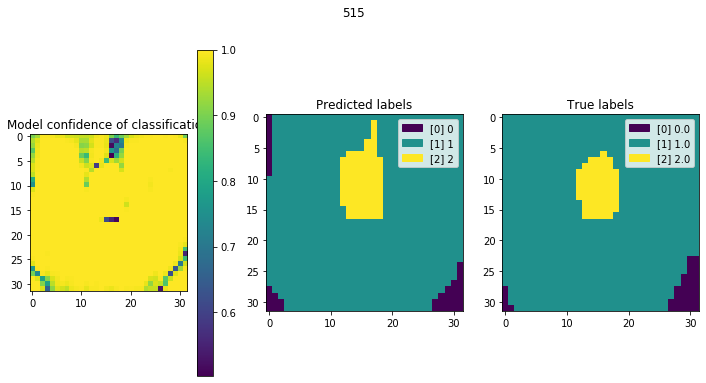

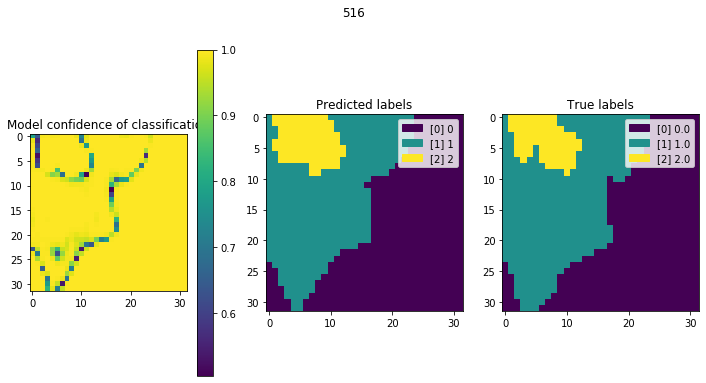

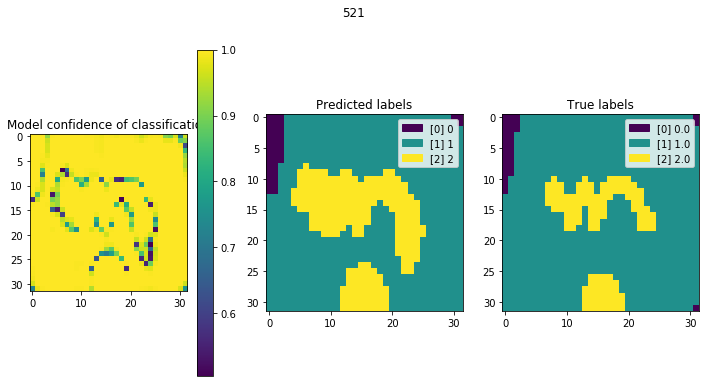

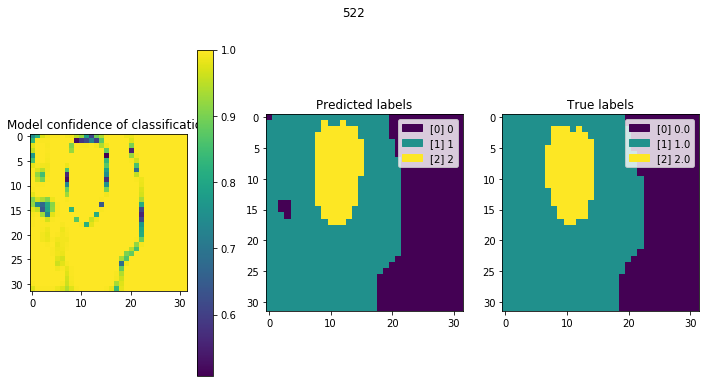

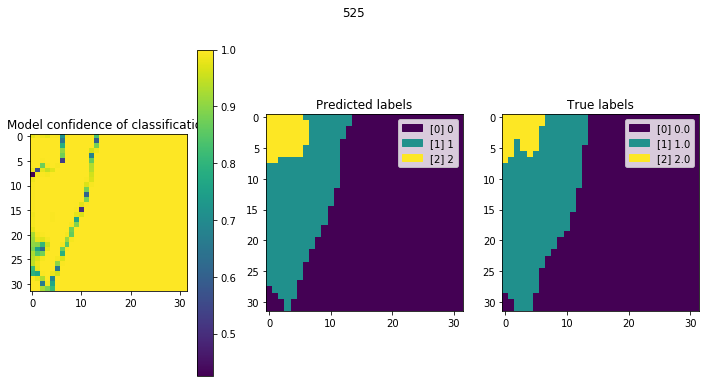

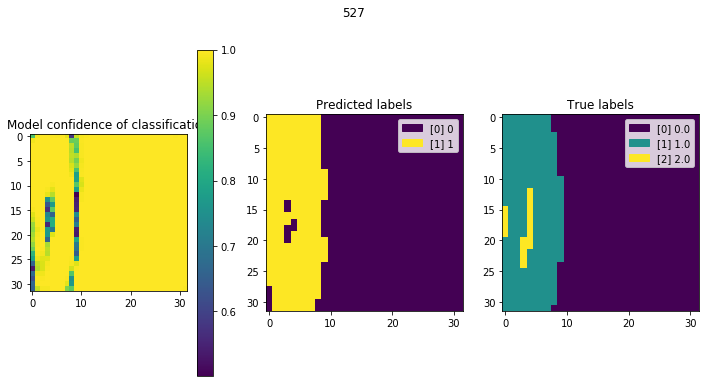

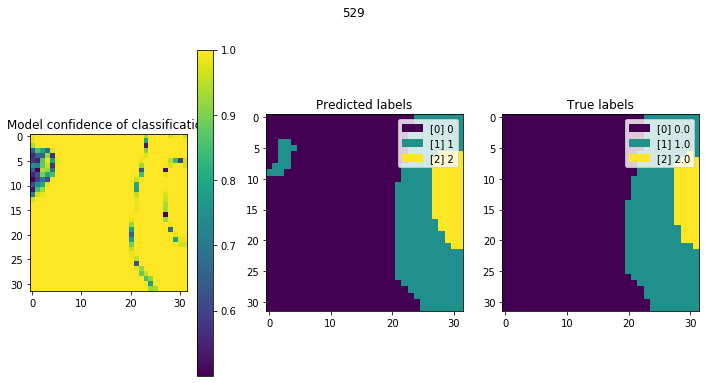

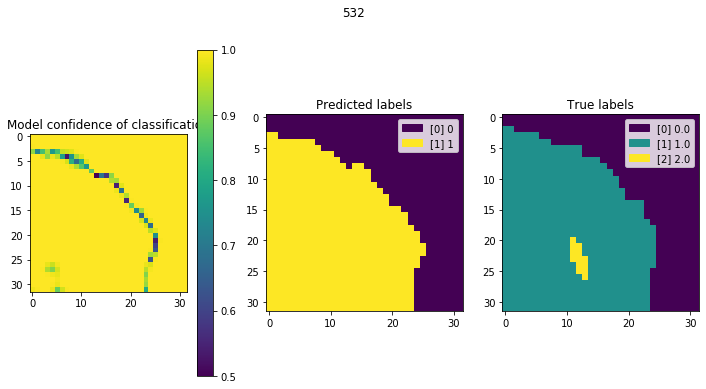

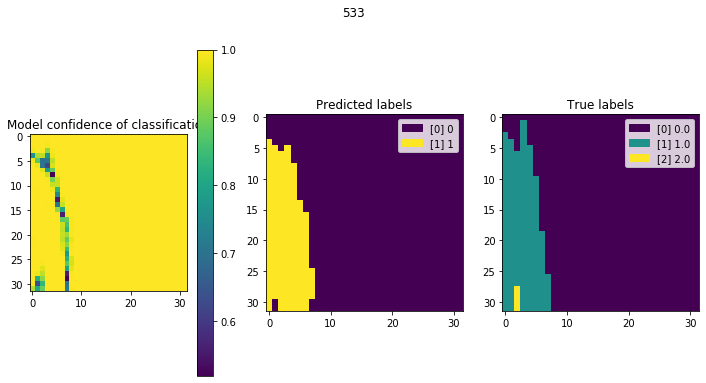

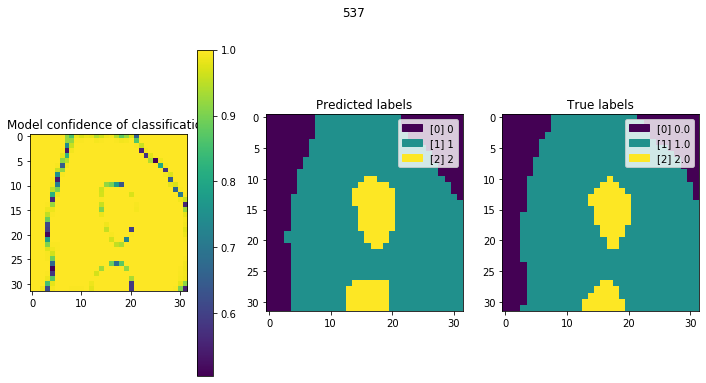

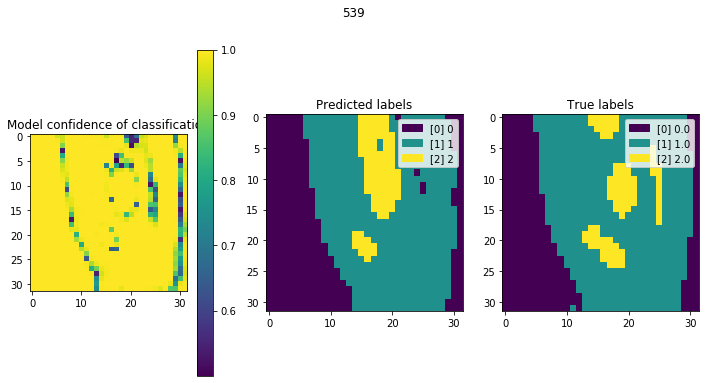

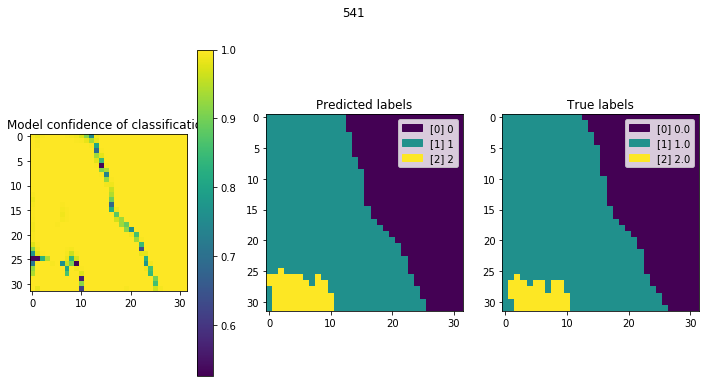

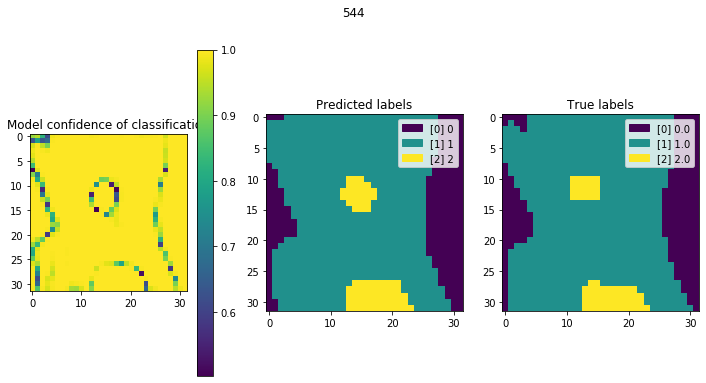

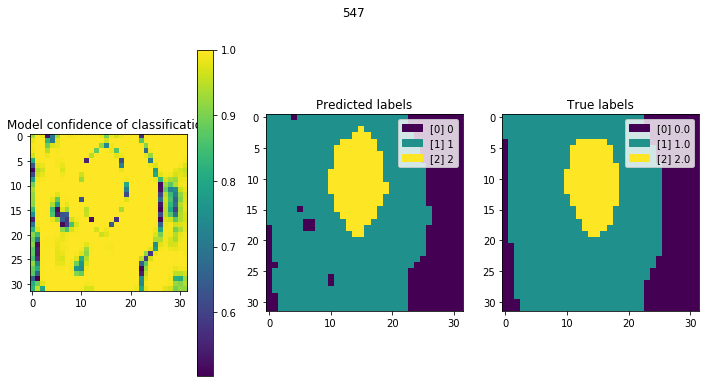

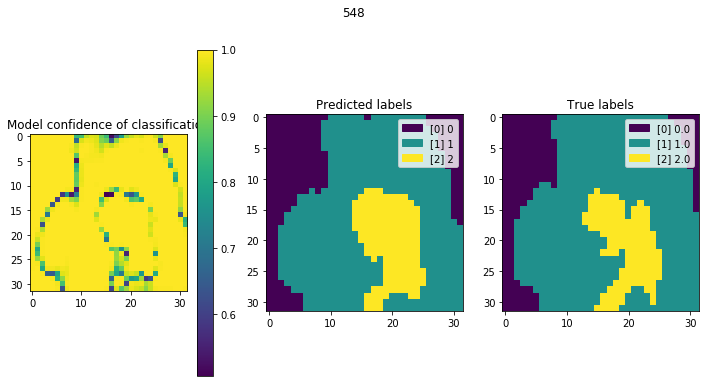

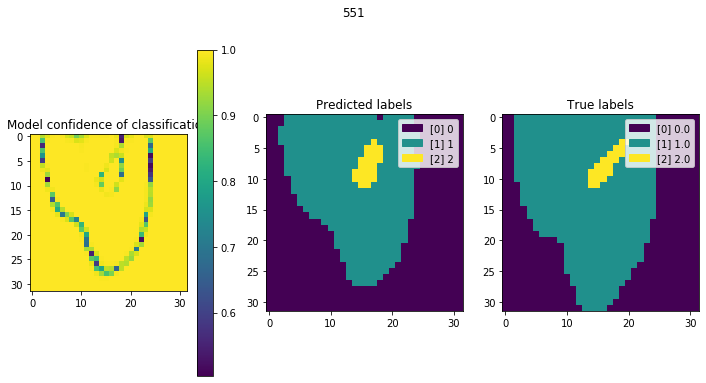

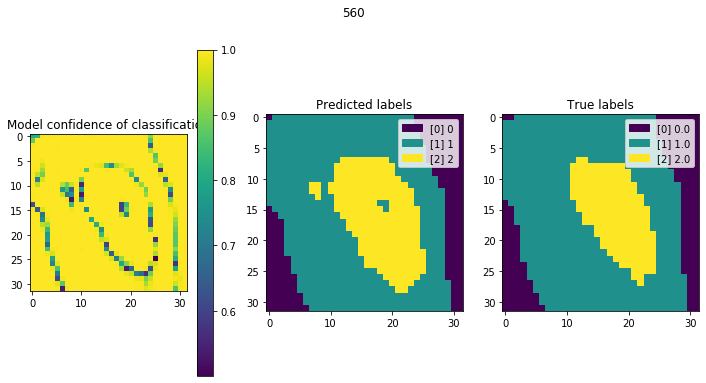

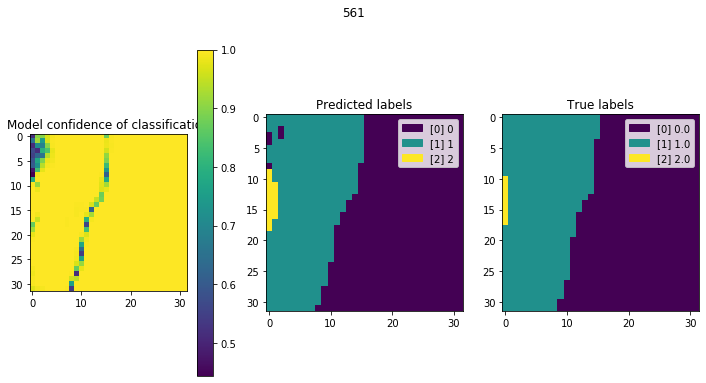

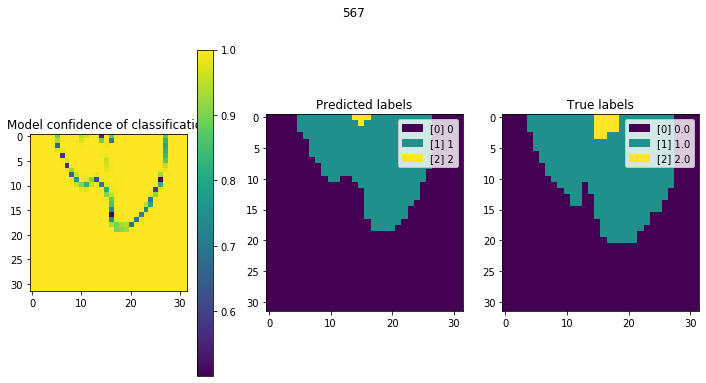

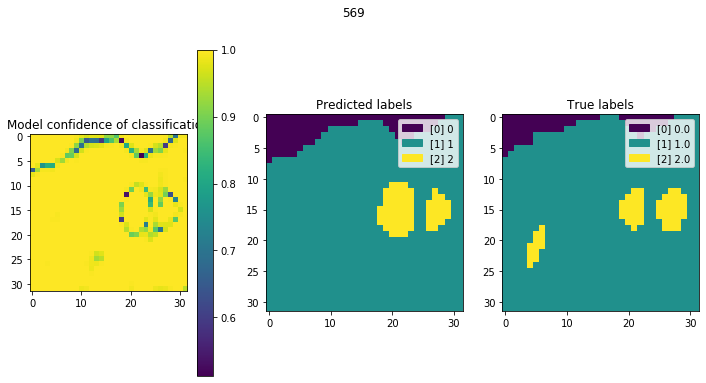

In [23]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y, img)
    plt.title("True labels")

# y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        plt.suptitle(i)
        

Number of layers in the base model:  49


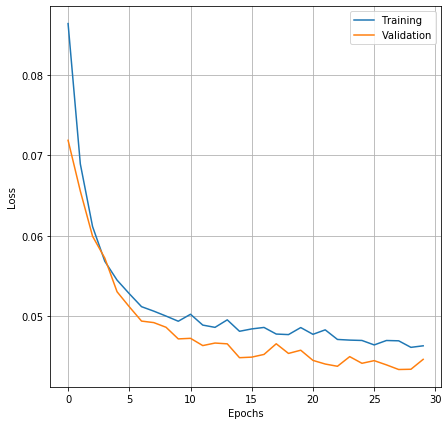

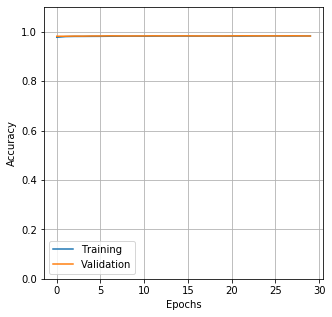

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 0.4985 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    363781
           1       0.98      0.96      0.97    203584
           2       0.83      0.84      0.84     16315

    accuracy                           0.98    583680
   macro avg       0.93      0.93      0.93    583680
weighted avg       0.98      0.98      0.98    583680



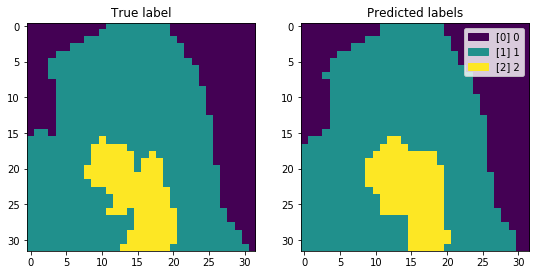

Fasle positive blobs 62.
Fasle positive blobs per image 0.1088


In [24]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

##################################
# Additional HybridSN prediction #
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     20294
         1.0       0.92      0.90      0.91     12956
         2.0       0.76      0.78      0.77      3230

    accuracy                           0.94     36480
   macro avg       0.88      0.89      0.89     36480
weighted avg       0.94      0.94      0.94     36480



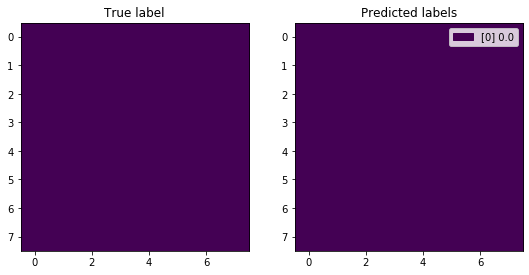

Elapsed time: 291.7663 seconds
Fasle positive blobs 129.
Fasle positive blobs per image 0.2263


In [25]:
model_hsn = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)

print("##################################")
print("# Additional HybridSN prediction #")
timer.start()
Y_hat = model_hsn.predict(X_test, Y_test)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test)

Summary runtimes
HybridSN
    X_test_HS -> (57, 56, 56, 208)
    586.6562 seconds
    10.2922 sec per image

X_test -> (570, 32, 32, 1)

SVM RBF    - 2109.1566 seconds -> 3.7003
SVM Linear - 3243.4765 seconds -> 5.6903

LR l2 - 0.3546 seconds -> 0.0006
LR l1 - 

SpectralUNet - 7.3087 seconds -> 0.0128
UNet - 1.0001 seconds -> 0.0018
UNet +DL - 1.2491     -> 0,0022
UNet +DL+CCE - 1.1801 -> 0,0021